In [108]:
import ROOT as r
import os
import sqlite3
import sys
import subprocess
%jsroot off

In [2]:
f_base = r.TFile.Open("/nashome/m/micarrig/icarus/hitTuning/test/hist_output_shower166767_0.root", "READ")
f_base.ls()

TFile**		/nashome/m/micarrig/icarus/hitTuning/test/hist_output_shower166767_0.root	
 TFile*		/nashome/m/micarrig/icarus/hitTuning/test/hist_output_shower166767_0.root	
  KEY: TDirectoryFile	Hits_WW;1	Hits_WW
  KEY: TDirectoryFile	Hits_WE;1	Hits_WE
  KEY: TDirectoryFile	Hits_EW;1	Hits_EW
  KEY: TDirectoryFile	Hits_EE;1	Hits_EE
  KEY: TCanvas	WireWaveformWithHits;1	Wire Waveform with Hits


In [2]:
# Path to your .db file (update this path)
db_path = "/nashome/m/micarrig/icarus/hitTuning/hitTuning_shower166767.db"
if not os.path.exists(db_path):
    raise FileNotFoundError(f"DB file not found: {db_path}")

def fetch_row_as_dict(dbfile, row_id, table='runs', id_column='id'):
    if row_id is None:
        raise ValueError("row_id must be provided")
    with sqlite3.connect(dbfile) as conn:
        cur = conn.cursor()
        # Ensure table exists
        cur.execute(
            "SELECT name FROM sqlite_master WHERE type='table' AND name=?",
            (table,)
        )
        if cur.fetchone() is None:
            raise ValueError(f"Table '{table}' not found in database")
        # Column names
        cols = [row[1] for row in cur.execute(f"PRAGMA table_info('{table}')")]
        # Fetch row
        cur.execute(f"SELECT * FROM '{table}' WHERE {id_column} = ?", (row_id,))
        row = cur.fetchone()
        if row is None:
            return None
        return {col: row[i] for i, col in enumerate(cols)}

# Fetch lines from DB - only 'runs' table
row_dict = fetch_row_as_dict(db_path, 1, table='runs', id_column='id')

row_dict

{'id': 1,
 'timestamp': '2025-11-26T16:46:22.717160',
 'fcl_filename': './fclFiles/hitTuning_shower166767_0.fcl',
 'output_filename': 'test/output_shower166767_0.root',
 'hist_filename': None,
 'roiThreshold_0': 5.0,
 'roiThreshold_1': 5.0,
 'roiThreshold_2': 5.0,
 'minPulseHeight_0': 2.0,
 'minPulseHeight_1': 2.0,
 'minPulseHeight_2': 2.0,
 'minPulseSigma_0': 1.0,
 'minPulseSigma_1': 1.0,
 'minPulseSigma_2': 1.0,
 'LongMaxHits_0': 1,
 'LongMaxHits_1': 1,
 'LongMaxHits_2': 1,
 'LongPulseWidth_0': 10.0,
 'LongPulseWidth_1': 10.0,
 'LongPulseWidth_2': 10.0,
 'PulseHeightCuts_0': 3.0,
 'PulseHeightCuts_1': 3.0,
 'PulseHeightCuts_2': 3.0,
 'PulseWidthCuts_0': 2.0,
 'PulseWidthCuts_1': 1.5,
 'PulseWidthCuts_2': 1.0,
 'PulseRatioCuts_0': 0.35,
 'PulseRatioCuts_1': 0.4,
 'PulseRatioCuts_2': 0.2,
 'MaxMultiHit': 5,
 'Chi2NDF': 500.0,
 'notes': ''}

0.9 0.9 0.7 0.9


NameError: name 'fetch_row_as_dict' is not defined

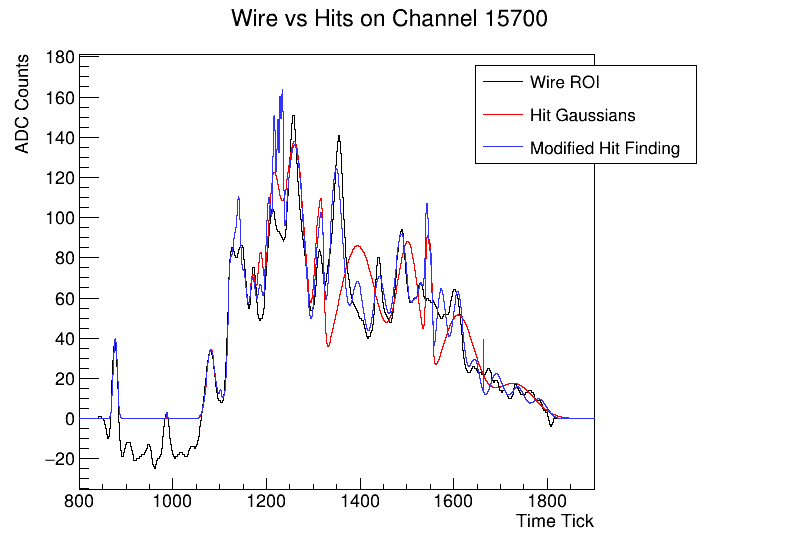

In [107]:
id = 6

f_base = r.TFile.Open("/nashome/m/micarrig/icarus/hitTuning/fclFiles/hist_output_tuneInd1_7.root", "READ")
#f_base = r.TFile.Open("/nashome/m/micarrig/icarus/hitTuning/test/hist_output_test_6.root", "READ")

c_base = f_base.Get('WireWaveformWithHits')
c_base.Draw()
f_mod = r.TFile.Open(f"/nashome/m/micarrig/icarus/hitTuning/fclFiles/hist_output_tuneInd1_{id}.root", "READ")
c_mod = f_mod.Get('WireWaveformWithHits')
for x in c_base.GetListOfPrimitives():
    if isinstance(x, r.TLegend):
        x.SetX1NDC(0.9)
        x.SetX2NDC(0.9)
        x.SetY1NDC(0.7)
        x.SetY2NDC(0.9)
        l1 = x
    if x.GetName() == "hWire":
        x.SetLineColor(r.kBlack)

for x in c_mod.GetListOfPrimitives():
    if x.GetName() == 'hHits':  
        x.SetLineColor(r.kBlue-4)
        c_base.cd()
        x.Draw("same")
        l1.AddEntry(x, "Modified Hit Finding", "l")
c_base.cd()

c_base.SetLeftMargin(0.1)
c_base.SetRightMargin(0.25)
print(l1.GetX1NDC(), l1.GetX2NDC(), l1.GetY1NDC(), l1.GetY2NDC())

c_base.Draw()
p_base = fetch_row_as_dict(db_path, 1, table='runs', id_column='id')
#p_base = fetch_row_as_dict('/nashome/m/micarrig/icarus/hitTuning/hitTuning_test.db', 7, table='runs', id_column='id')
p_mod = fetch_row_as_dict('/nashome/m/micarrig/icarus/hitTuning/hitTuning_test.db', id+1, table='runs', id_column='id')

startY = 0.65
ignore_keys = ['timestamp', 'note', 'output_filename', 'fcl_filename']
for (k, v_base), v_mod in zip(p_base.items(), p_mod.values()):
    if k in ignore_keys:
        continue
    if v_base != v_mod:
        print(f'{k}: {v_base} -> {v_mod}', startY)
        t = r.TLatex()
        t.SetTextSize(0.02)
        t.DrawLatexNDC(0.77, startY, f'{k}: {v_base} -> {v_mod}')
        startY = startY-0.03



In [3]:
def compareHits(h_wire, h_hits, id, db_path=db_path):
    c = r.TCanvas(f"c_{id}", "Comparison Canvas", 800, 600)
    c.SetLeftMargin(0.1)
    c.SetRightMargin(0.25)
    c.cd()
    
    h_wire.Draw()
    h_hits.Draw("same")

    # Create legend and explicitly set NDC coordinates
    l1 = r.TLegend(0.1, 0.7, 0.3, 0.9)
    l1.SetX1NDC(0.1)
    l1.SetY1NDC(0.7)
    l1.SetX2NDC(0.3)
    l1.SetY2NDC(0.9)
    l1.AddEntry(h_wire, "Wire ROI", "l")
    l1.AddEntry(h_hits, "Original Hit Finding", "l")

    f_mod = r.TFile.Open(f"/nashome/m/micarrig/icarus/hitTuning/test/hist_output_shower166767_{id-1}.root", "READ")
    c_mod = f_mod.Get('WireWaveformWithHits')

    for x in c_mod.GetListOfPrimitives():
        if x.GetName() == 'hHits':  
            x.SetLineColor(r.kBlue-4)
            c.cd()
            x.Draw("same")
            l1.AddEntry(x, "Modified Hit Finding", "l")
            break
    
    f_mod.Close()
    c.cd()

    l1.Draw()
    
    # Store legend on canvas to prevent garbage collection
    c.legend = l1
    
    c.Update()
    
    # Store TLatex objects to prevent garbage collection
    c.latex_list = []
    
    p_base = fetch_row_as_dict(db_path, 1, table='runs', id_column='id')
    p_mod = fetch_row_as_dict(db_path, id, table='runs', id_column='id')

    startY = 0.65
    ignore_keys = ['timestamp', 'note', 'output_filename', 'fcl_filename', 'hist_filename']
    for (k, v_base), v_mod in zip(p_base.items(), p_mod.values()):
        if k in ignore_keys:
            continue
        if v_base != v_mod:
            t = r.TLatex()
            t.SetTextSize(0.02)
            t.DrawLatexNDC(0.77, startY, f'{k}: {v_base} -> {v_mod}')
            c.latex_list.append(t)
            startY = startY-0.03
    
    c.Modified()
    c.Update()
    return c


In [239]:
f_base = r.TFile.Open("/nashome/m/micarrig/icarus/hitTuning/test/hist_output_shower166767_0.root", "READ")
c_base = f_base.Get('WireWaveformWithHits')
hWire = None
hHits = None
for x in c_base.GetListOfPrimitives():
    if x.GetName() == "hWire":
        print("got hwire")
        x.SetLineColor(r.kBlack)
        hWire = x.Clone()
    if x.GetName() == "hHits":
        print("got hhits")
        x.SetLineColor(r.kRed)
        hHits = x.Clone()

minTrial, maxTrial = 1, 925
for trial in range (minTrial, maxTrial):
    print("trial", trial)
    try:
        c = compareHits(hWire, hHits, trial)
        if trial==minTrial:
            c.SaveAs("/nashome/m/micarrig/icarus/hitTuning/compareHits_allTrials.pdf(")
        elif trial==maxTrial-1:
            c.SaveAs("/nashome/m/micarrig/icarus/hitTuning/compareHits_allTrials.pdf)")
        else:
            c.SaveAs("/nashome/m/micarrig/icarus/hitTuning/compareHits_allTrials.pdf")
    except:
        print("failed to get file for trial", trial)

OSError: Failed to open file /nashome/m/micarrig/icarus/hitTuning/test/hist_output_shower166767_0.root

Error in <TFile::TFile>: file /nashome/m/micarrig/icarus/hitTuning/test/hist_output_shower166767_0.root does not exist


### compare metrics

In [240]:
fin = r.TFile.Open("/nashome/m/micarrig/icarus/hitTuning/dummy.root", "READ")

h_hitEnergy = fin.Get("h_hitEnergy")
h_ideEnergy = fin.Get("h_ideEnergy")
h_energyRatio = fin.Get("h_energyRatio")

# Create canvas and manually place two pads with different heights
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1200, 1200)
c1.Divide(1,2)

c1.cd(1)
h_hitEnergy.SetLineColor(r.kRed)
h_hitEnergy.Draw()
h_ideEnergy.SetLineColor(r.kBlue)
h_ideEnergy.Draw("same")
r.gPad.SetLogy()

l = r.TLegend(0.70, 0.70, 0.90, 0.90)
l.AddEntry(h_hitEnergy, "Hit Energy (BackTracker)", "l")
l.AddEntry(h_ideEnergy, "IDE Energy (SimChannel)", "l")
l.Draw()

#h_ratio = r.TRatioPlot(h_hitEnergy, h_ideEnergy)
#h_ratio.GetUpperPad().SetLogy()

#c1.cd(2)
#h_ratio.Draw()

c1.cd(2)
h_energyRatio.SetLineColor(r.kBlack)
h_energyRatio.Draw()
r.gPad.SetLogy()

c1.Update()
c1.Draw()

OSError: Failed to open file /nashome/m/micarrig/icarus/hitTuning/dummy.root

Error in <TFile::ReadBuffer>: error reading all requested bytes from file /nashome/m/micarrig/icarus/hitTuning/dummy.root, got 216 of 300
Error in <TFile::Init>: /nashome/m/micarrig/icarus/hitTuning/dummy.root failed to read the file type data.


Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 256 points have been skipped


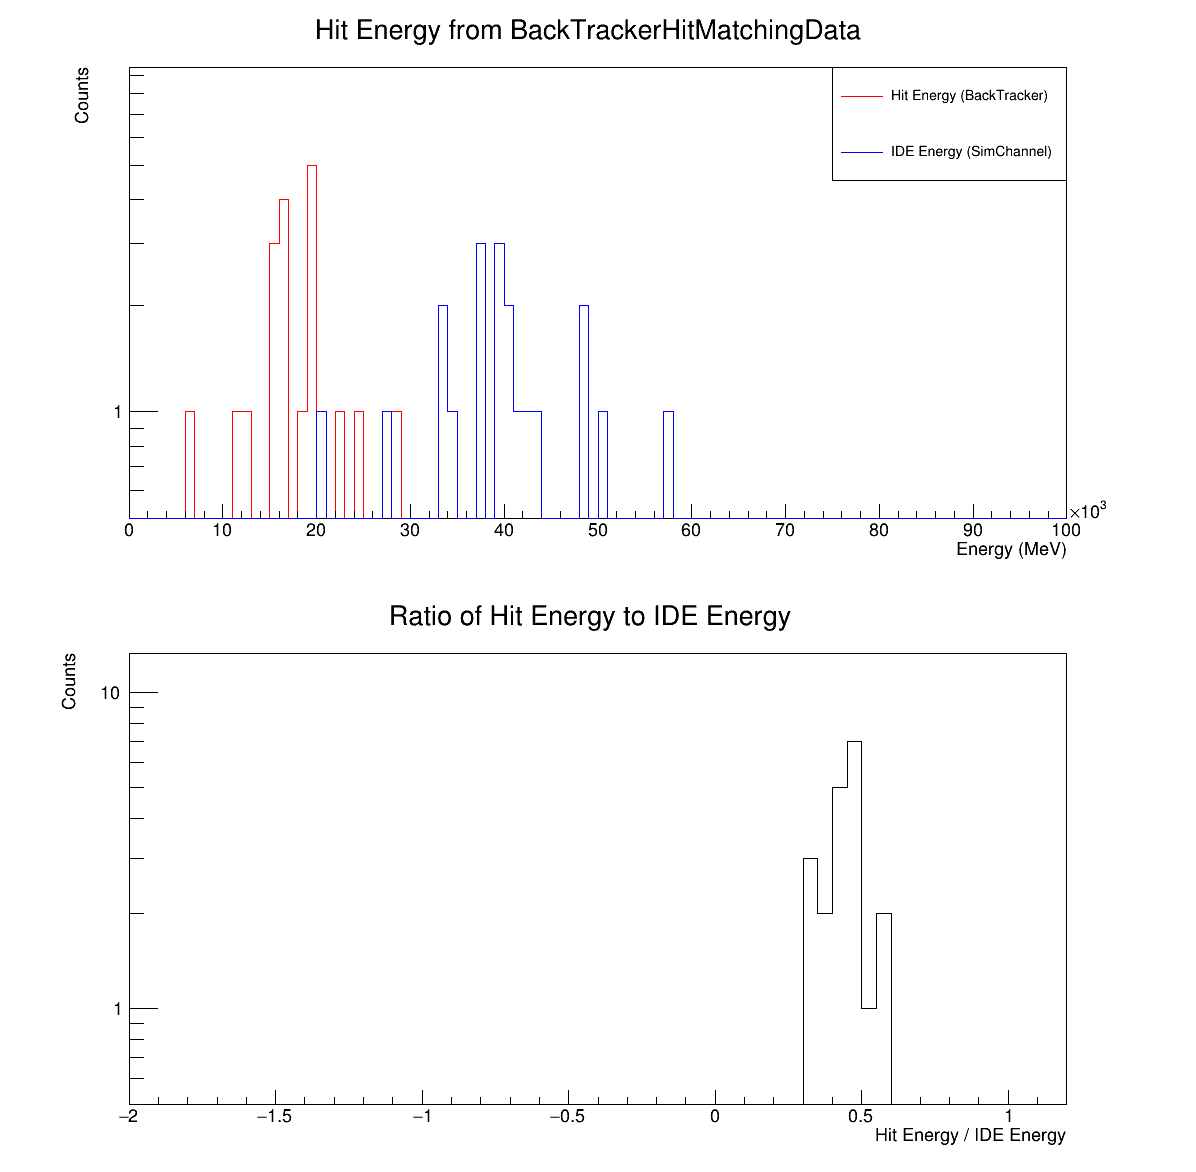

In [3]:
h_ratio = r.TRatioPlot(h_hitEnergy, h_ideEnergy)
#h_ratio.GetUpperPad().SetLogy()
c1.cd(2)
r.gPad.SetLogy()
h_ratio.Draw()
c1.Draw()

In [36]:
fin = r.TFile.Open("root://fndcadoor.fnal.gov:/icarus/scratch/users/micarrig/hitTuning/mc/stage1/hist_output_MC_12.root", "READ")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


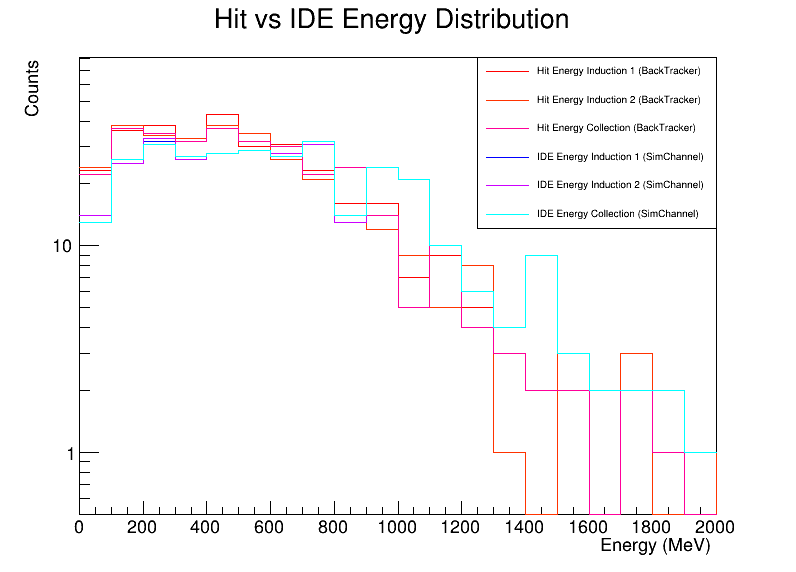

In [37]:

c1 = r.TCanvas("c1", "Hit Energy Comparison", 800, 600)

h_hit0 = fin.Get("AllParticles/h_hitEnergy_plane0")
h_hit1 = fin.Get("AllParticles/h_hitEnergy_plane1")
h_hit2 = fin.Get("AllParticles/h_hitEnergy_plane2")

h_ide0 = fin.Get("AllParticles/h_ideEnergy_plane0")
h_ide1 = fin.Get("AllParticles/h_ideEnergy_plane1")
h_ide2 = fin.Get("AllParticles/h_ideEnergy_plane2")

h_hit0.GetXaxis().SetRangeUser(0, 2000)
h_hit0.SetTitle("Hit vs IDE Energy Distribution;Energy (MeV);Counts")
h_hit0.SetLineColor(r.kRed)
h_hit1.SetLineColor(r.kOrange+10)
h_hit2.SetLineColor(r.kPink+10)
h_ide0.SetLineColor(r.kBlue)
h_ide1.SetLineColor(r.kViolet)
h_ide2.SetLineColor(r.kCyan)
h_hit0.Draw()
h_ide0.Draw("same")
h_hit1.Draw("same")
h_ide1.Draw("same")
h_hit2.Draw("same")
h_ide2.Draw("same")
r.gPad.SetLogy()    

l1 = r.TLegend(0.60, 0.60, 0.90, 0.90)
l1.AddEntry(h_hit0, "Hit Energy Induction 1 (BackTracker)", "l")
l1.AddEntry(h_hit1, "Hit Energy Induction 2 (BackTracker)", "l")
l1.AddEntry(h_hit2, "Hit Energy Collection (BackTracker)", "l")
l1.AddEntry(h_ide0, "IDE Energy Induction 1 (SimChannel)", "l")
l1.AddEntry(h_ide1, "IDE Energy Induction 2 (SimChannel)", "l")
l1.AddEntry(h_ide2, "IDE Energy Collection (SimChannel)", "l")
l1.Draw()

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


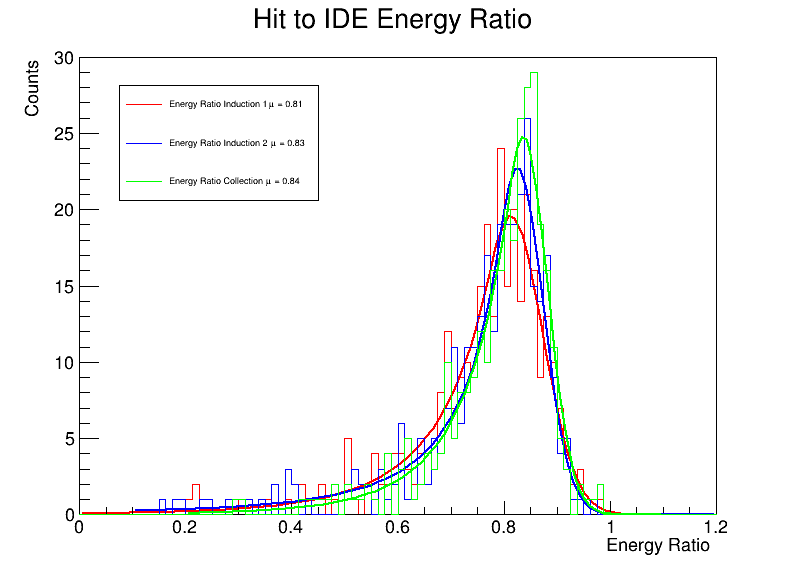

In [38]:
h_ratio0 = fin.Get("AllParticles/h_energyRatio_plane0")
h_ratio1 = fin.Get("AllParticles/h_energyRatio_plane1")
h_ratio2 = fin.Get("AllParticles/h_energyRatio_plane2")

c1 = r.TCanvas("c1", "Hit Energy Comparison", 800, 600)

h_ratio0.SetTitle("Hit to IDE Energy Ratio;Energy Ratio;Counts")
h_ratio0.GetYaxis().SetRangeUser(0, 30)
h_ratio0.SetLineColor(r.kRed)
h_ratio1.SetLineColor(r.kBlue)
h_ratio2.SetLineColor(r.kGreen)


f0 = r.TF1("f0", "crystalball", 0, 1)
f0.SetParameters(1, 0, 1, 2, 0.5)
h_ratio0.Fit(f0, "LESMRQ", "", 0, 1.2)
f1 = r.TF1("f1", "crystalball", 0, 1)
f1.SetParameters(1, 0, 1, 2, 0.5)
f1.SetLineColor(r.kBlue)
h_ratio1.Fit(f1, "LESMRQ", "", 0.1, 1.2)
f2 = r.TF1("f2", "crystalball", 0, 1)
f2.SetParameters(1, 0, 1, 2, 0.5)
f2.SetLineColor(r.kGreen)
h_ratio2.Fit(f2, "LESMRQ", "", 0.2, 1.1)

# h_ratio0.Rebin(2)
# h_ratio1.Rebin(2)
# h_ratio2.Rebin(2)

h_ratio0.GetXaxis().SetRangeUser(0, 1.2)

h_ratio0.Draw()
h_ratio1.Draw("same")
h_ratio2.Draw("same")

l1 = r.TLegend(0.15, 0.65, 0.40, 0.85)
l1.AddEntry(h_ratio0, f"Energy Ratio Induction 1 #mu = {f0.GetParameter(1):.2f}", "l")
l1.AddEntry(h_ratio1, f"Energy Ratio Induction 2 #mu = {f1.GetParameter(1):.2f}", "l")
l1.AddEntry(h_ratio2, f"Energy Ratio Collection #mu = {f2.GetParameter(1):.2f}", "l")
l1.Draw()

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


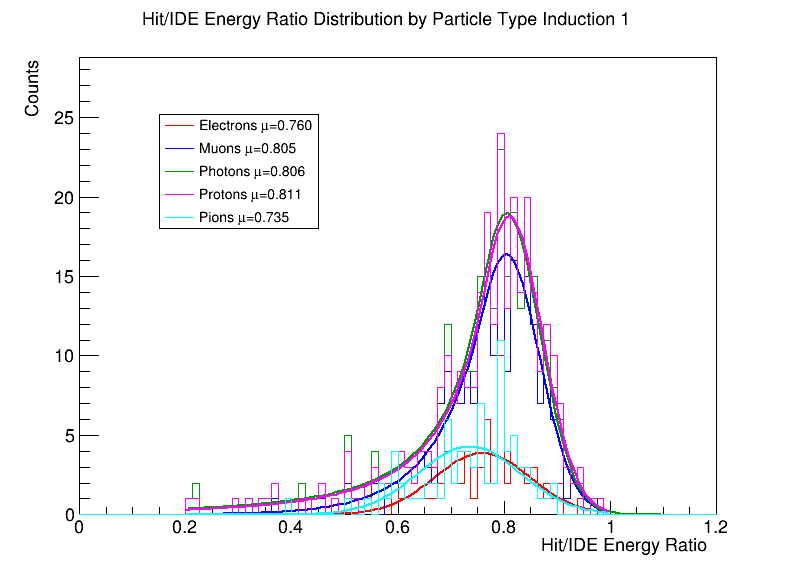

In [39]:
plotName = "h_energyRatio"
plane = 0
title = "Hit/IDE Energy Ratio Distribution by Particle Type Induction 1;Hit/IDE Energy Ratio;Counts"
xmin = 0
xmax = 1.2
scale = False
SetLogy = False
setYbounds = True

c1 = r.TCanvas("c1", "Particle Comparison", 800, 600)
h_ele = fin.Get(f"Electrons/{plotName}_ele_plane{plane}")
h_gam = fin.Get(f"Photons/{plotName}_gamma_plane{plane}")
h_mu = fin.Get(f"Muons/{plotName}_mu_plane{plane}")
h_p = fin.Get(f"Protons/{plotName}_p_plane{plane}")
h_pi = fin.Get(f"Pions/{plotName}_pi_plane{plane}")
c1.Clear()

if scale:
    h_ele.Scale(1.0/h_ele.Integral())
    h_mu.Scale(1.0/h_mu.Integral())
    h_gam.Scale(1.0/h_gam.Integral())
    h_p.Scale(1.0/h_p.Integral())
    h_pi.Scale(1.0/h_pi.Integral())

f_ele = r.TF1("fele", "gaus", 0.4, 1)
f_pi = r.TF1("fpi", "gaus", 0.2, 1)

f_gam = r.TF1("fgam", "crystalball", 0.2, 1.1)
f_gam.SetParameters(1, 0, 1, 2, 0.5)
f_mu = r.TF1("fmu", "crystalball", 0.2, 1)
f_mu.SetParameters(1, 0, 1, 2, 0.5)
f_p = r.TF1("fp", "crystalball", 0.2, 1)
f_p.SetParameters(1, 0, 1, 2, 0.5)

h_ele.Fit(f_ele, "LESMRSQ", "", 0.2, 1.1)
h_gam.Fit(f_gam, "LESMRSQ", "", 0.2, 1.1)
h_mu.Fit(f_mu, "LESMRSQ", "", 0.2, 1.1)
h_p.Fit(f_p, "LESMRSQ", "", 0.2, 1.1)
h_pi.Fit(f_pi, "LESMRSQ", "", 0.2, 1.1)

h_ele.SetTitle(title)
h_ele.GetXaxis().SetRangeUser(xmin, xmax)

h_ele.SetLineColor(r.kRed)
f_ele.SetLineColor(r.kRed)
h_mu.SetLineColor(r.kBlue)
f_mu.SetLineColor(r.kBlue)
h_gam.SetLineColor(r.kGreen+2)
f_gam.SetLineColor(r.kGreen+2)
h_p.SetLineColor(r.kMagenta)
f_p.SetLineColor(r.kMagenta)
h_pi.SetLineColor(r.kCyan)
f_pi.SetLineColor(r.kCyan)

if setYbounds:
    maxY = max(h_ele.GetMaximum(), h_mu.GetMaximum(), h_gam.GetMaximum(), h_p.GetMaximum(), h_pi.GetMaximum())
    h_ele.GetYaxis().SetRangeUser(0, maxY*1.2)

h_ele.Draw('hist')
f_ele.Draw("same")
h_mu.Draw("same hist")
f_mu.Draw("same")
h_gam.Draw("same hist")
f_gam.Draw("same")
h_p.Draw("same hist")
f_p.Draw("same")
h_pi.Draw("same hist")
f_pi.Draw("same")
if SetLogy:
    r.gPad.SetLogy()
l1 = r.TLegend(0.20, 0.60, 0.40, 0.80)
l1.AddEntry(h_ele, f"Electrons #mu={f_ele.GetParameter(1):.3f}", "l")
l1.AddEntry(h_mu, f"Muons #mu={f_mu.GetParameter(1):.3f}", "l")
l1.AddEntry(h_gam, f"Photons #mu={f_gam.GetParameter(1):.3f}", "l")
l1.AddEntry(h_p, f"Protons #mu={f_p.GetParameter(1):.3f}", "l")
l1.AddEntry(h_pi, f"Pions #mu={f_pi.GetParameter(1):.3f}", "l")
l1.Draw("same")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


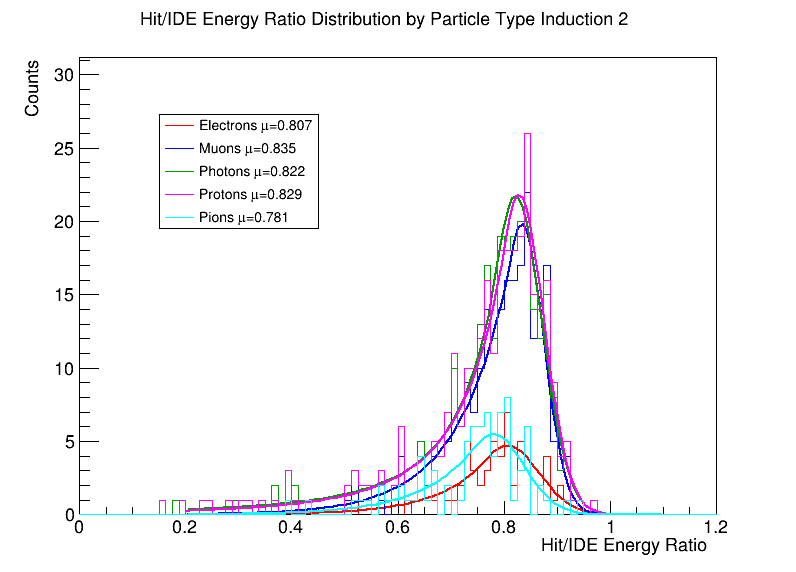

In [63]:
plotName = "h_energyRatio"
plane = 1
title = "Hit/IDE Energy Ratio Distribution by Particle Type Induction 2;Hit/IDE Energy Ratio;Counts"
xmin = 0
xmax = 1.2
scale = False
SetLogy = False
setYbounds = False

c1 = r.TCanvas("c1", "Particle Comparison", 800, 600)
h_ele = fin.Get(f"Electrons/{plotName}_ele_plane{plane}")
h_gam = fin.Get(f"Photons/{plotName}_gamma_plane{plane}")
h_mu = fin.Get(f"Muons/{plotName}_mu_plane{plane}")
h_p = fin.Get(f"Protons/{plotName}_p_plane{plane}")
h_pi = fin.Get(f"Pions/{plotName}_pi_plane{plane}")
c1.Clear()

if scale:
    h_ele.Scale(1.0/h_ele.Integral())
    h_mu.Scale(1.0/h_mu.Integral())
    h_gam.Scale(1.0/h_gam.Integral())
    h_p.Scale(1.0/h_p.Integral())
    h_pi.Scale(1.0/h_pi.Integral())

f_ele = r.TF1("fele", "crystalball", 0.2, 1.1)
f_ele.SetParameters(10, 0.8, 0.1, 1, 1)
f_pi = r.TF1("fpi", "crystalball", 0.2, 1.1)
f_pi.SetParameters(10, 0.8, 0.1, 1, 1)
f_gam = r.TF1("fgam", "crystalball", 0.2, 1.1)
f_gam.SetParameters(10, 1, 0.1, 1, 1)
f_mu = r.TF1("fmu", "crystalball", 0.2, 1)
f_mu.SetParameters(10, 1, 0.1, 1, 1)
f_p = r.TF1("fp", "crystalball", 0.2, 1)
f_p.SetParameters(10, 1, 0.1, 1, 1)

h_ele.Fit(f_ele, "LESMRSQ", "", 0.2, 1.2)
h_gam.Fit(f_gam, "LESMRSQ", "", 0.2, 1.2)
h_mu.Fit(f_mu, "LESMRSQ", "", 0.2, 1.2)
h_p.Fit(f_p, "LESMRSQ", "", 0.2, 1.2)
h_pi.Fit(f_pi, "LESMRSQ", "", 0.2, 1.2)

h_ele.SetTitle(title)
h_ele.GetXaxis().SetRangeUser(xmin, xmax)

h_ele.SetLineColor(r.kRed)
f_ele.SetLineColor(r.kRed)
h_mu.SetLineColor(r.kBlue)
f_mu.SetLineColor(r.kBlue)
h_gam.SetLineColor(r.kGreen+2)
f_gam.SetLineColor(r.kGreen+2)
h_p.SetLineColor(r.kMagenta)
f_p.SetLineColor(r.kMagenta)
h_pi.SetLineColor(r.kCyan)
f_pi.SetLineColor(r.kCyan)

if setYbounds:
    maxY = max(h_ele.GetMaximum(), h_mu.GetMaximum(), h_gam.GetMaximum(), h_p.GetMaximum(), h_pi.GetMaximum())
    h_ele.GetYaxis().SetRangeUser(0, maxY*1.2)

h_ele.Draw('hist')
f_ele.Draw("same")
h_mu.Draw("same hist")
f_mu.Draw("same")
h_gam.Draw("same hist")
f_gam.Draw("same")
h_p.Draw("same hist")
f_p.Draw("same")
h_pi.Draw("same hist")
f_pi.Draw("same")
if SetLogy:
    r.gPad.SetLogy()
l1 = r.TLegend(0.20, 0.60, 0.40, 0.80)
l1.AddEntry(h_ele, f"Electrons #mu={f_ele.GetParameter(1):.3f}", "l")
l1.AddEntry(h_mu, f"Muons #mu={f_mu.GetParameter(1):.3f}", "l")
l1.AddEntry(h_gam, f"Photons #mu={f_gam.GetParameter(1):.3f}", "l")
l1.AddEntry(h_p, f"Protons #mu={f_p.GetParameter(1):.3f}", "l")
l1.AddEntry(h_pi, f"Pions #mu={f_pi.GetParameter(1):.3f}", "l")
l1.Draw("same")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


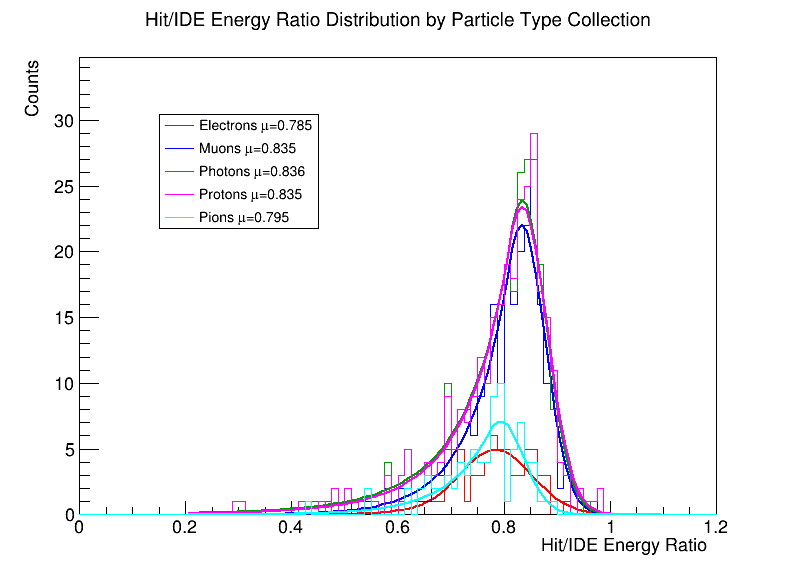

In [41]:
plotName = "h_energyRatio"
plane = 2
title = "Hit/IDE Energy Ratio Distribution by Particle Type Collection;Hit/IDE Energy Ratio;Counts"
xmin = 0
xmax = 1.2
scale = False
SetLogy = False
setYbounds = True

c1 = r.TCanvas("c1", "Particle Comparison", 800, 600)
h_ele = fin.Get(f"Electrons/{plotName}_ele_plane{plane}")
h_gam = fin.Get(f"Photons/{plotName}_gamma_plane{plane}")
h_mu = fin.Get(f"Muons/{plotName}_mu_plane{plane}")
h_p = fin.Get(f"Protons/{plotName}_p_plane{plane}")
h_pi = fin.Get(f"Pions/{plotName}_pi_plane{plane}")
c1.Clear()

if scale:
    h_ele.Scale(1.0/h_ele.Integral())
    h_mu.Scale(1.0/h_mu.Integral())
    h_gam.Scale(1.0/h_gam.Integral())
    h_p.Scale(1.0/h_p.Integral())
    h_pi.Scale(1.0/h_pi.Integral())

f_ele = r.TF1("fele", "crystalball", 0.2, 1.1)
f_ele.SetParameters(10, 0.8, 0.05, 1, 1)
f_pi = r.TF1("fpi", "crystalball", 0.2, 1.1)
f_pi.SetParameters(10, 0.8, 0.05, 1, 1)
f_gam = r.TF1("fgam", "crystalball", 0.2, 1.1)
f_gam.SetParameters(25, 0.9, 0.05, 1, 1)
f_mu = r.TF1("fmu", "crystalball", 0.2, 1.1)
f_mu.SetParameters(25, 0.9, 0.05, 1, 1)
f_p = r.TF1("fp", "crystalball", 0.2, 1.1)
f_p.SetParameters(25, 0.9, 0.05, 1, 1)

h_ele.Fit(f_ele, "LESMRSQ", "", 0.3, 1.1)
h_gam.Fit(f_gam, "LESMRSQ", "", 0.3, 1.1)
h_mu.Fit(f_mu, "LESMRSQ", "", 0.3, 1.1)
h_p.Fit(f_p, "LESMRSQ", "", 0.3, 1.1)
h_pi.Fit(f_pi, "LESMRSQ", "", 0.2, 1.1)

h_ele.SetTitle(title)

h_ele.SetLineColor(r.kRed)
f_ele.SetLineColor(r.kRed)
h_mu.SetLineColor(r.kBlue)
f_mu.SetLineColor(r.kBlue)
h_gam.SetLineColor(r.kGreen+2)
f_gam.SetLineColor(r.kGreen+2)
h_p.SetLineColor(r.kMagenta)
f_p.SetLineColor(r.kMagenta)
h_pi.SetLineColor(r.kCyan)
f_pi.SetLineColor(r.kCyan)

if setYbounds:
    maxY = max(h_ele.GetMaximum(), h_mu.GetMaximum(), h_gam.GetMaximum(), h_p.GetMaximum(), h_pi.GetMaximum())
    h_ele.GetYaxis().SetRangeUser(0, maxY*1.2)

h_ele.GetXaxis().SetRangeUser(xmin, xmax)

h_ele.Draw('hist')
f_ele.Draw("same")
h_mu.Draw("same hist")
f_mu.Draw("same")
h_gam.Draw("same hist")
f_gam.Draw("same")
h_p.Draw("same hist")
f_p.Draw("same")
h_pi.Draw("same hist")
f_pi.Draw("same")
if SetLogy:
    r.gPad.SetLogy()
l1 = r.TLegend(0.20, 0.60, 0.40, 0.80)
l1.AddEntry(h_ele, f"Electrons #mu={f_ele.GetParameter(1):.3f}", "l")
l1.AddEntry(h_mu, f"Muons #mu={f_mu.GetParameter(1):.3f}", "l")
l1.AddEntry(h_gam, f"Photons #mu={f_gam.GetParameter(1):.3f}", "l")
l1.AddEntry(h_p, f"Protons #mu={f_p.GetParameter(1):.3f}", "l")
l1.AddEntry(h_pi, f"Pions #mu={f_pi.GetParameter(1):.3f}", "l")
l1.Draw("same")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


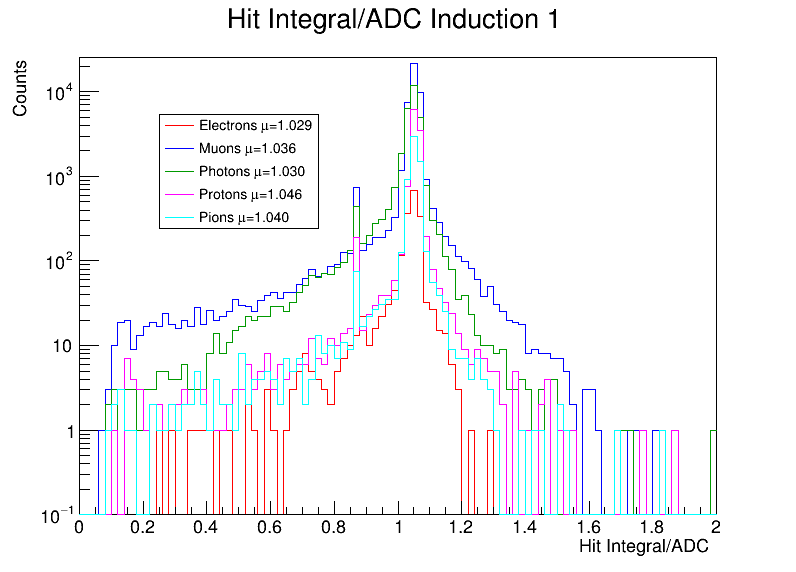

In [42]:
plotName = "h_hitAreaRatio"
plane = 0
title = "Hit Integral/ADC Induction 1;Hit Integral/ADC;Counts"
xmin = 0.0
xmax = 2.0
scale = False
SetLogy = True
setYbounds = True

c1 = r.TCanvas("c1", "Particle Comparison", 800, 600)
h_ele = fin.Get(f"Electrons/{plotName}_ele_plane{plane}")
h_gam = fin.Get(f"Photons/{plotName}_gamma_plane{plane}")
h_mu = fin.Get(f"Muons/{plotName}_mu_plane{plane}")
h_p = fin.Get(f"Protons/{plotName}_p_plane{plane}")
h_pi = fin.Get(f"Pions/{plotName}_pi_plane{plane}")
c1.Clear()

if scale:
    h_ele.Scale(1.0/h_ele.Integral())
    h_mu.Scale(1.0/h_mu.Integral())
    h_gam.Scale(1.0/h_gam.Integral())
    h_p.Scale(1.0/h_p.Integral())
    h_pi.Scale(1.0/h_pi.Integral())

h_ele.SetTitle(title)

h_ele.SetLineColor(r.kRed)
h_mu.SetLineColor(r.kBlue)
h_gam.SetLineColor(r.kGreen+2)
h_p.SetLineColor(r.kMagenta)
h_pi.SetLineColor(r.kCyan)

if setYbounds:
    maxY = max(h_ele.GetMaximum(), h_mu.GetMaximum(), h_gam.GetMaximum(), h_p.GetMaximum(), h_pi.GetMaximum())
    h_ele.GetYaxis().SetRangeUser(1e-1, maxY*1.2)

h_ele.GetXaxis().SetRangeUser(xmin, xmax)

h_ele.Draw('hist')
h_mu.Draw("same hist")
h_gam.Draw("same hist")
h_p.Draw("same hist")
h_pi.Draw("same hist")
if SetLogy:
    r.gPad.SetLogy()
l1 = r.TLegend(0.20, 0.60, 0.40, 0.80)
l1.AddEntry(h_ele, f"Electrons #mu={h_ele.GetMean():.3f}", "l")
l1.AddEntry(h_mu, f"Muons #mu={h_mu.GetMean():.3f}", "l")
l1.AddEntry(h_gam, f"Photons #mu={h_gam.GetMean():.3f}", "l")
l1.AddEntry(h_p, f"Protons #mu={h_p.GetMean():.3f}", "l")
l1.AddEntry(h_pi, f"Pions #mu={h_pi.GetMean():.3f}", "l")
l1.Draw("same")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


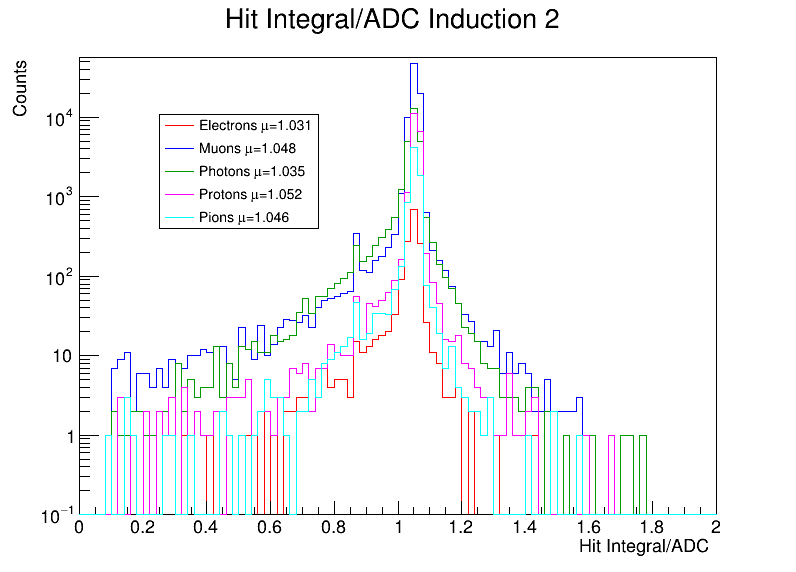

In [43]:
plotName = "h_hitAreaRatio"
plane = 1
title = "Hit Integral/ADC Induction 2;Hit Integral/ADC;Counts"
xmin = 0.0
xmax = 2.0
scale = False
SetLogy = True
setYbounds = True

c1 = r.TCanvas("c1", "Particle Comparison", 800, 600)
h_ele = fin.Get(f"Electrons/{plotName}_ele_plane{plane}")
h_gam = fin.Get(f"Photons/{plotName}_gamma_plane{plane}")
h_mu = fin.Get(f"Muons/{plotName}_mu_plane{plane}")
h_p = fin.Get(f"Protons/{plotName}_p_plane{plane}")
h_pi = fin.Get(f"Pions/{plotName}_pi_plane{plane}")
c1.Clear()

if scale:
    h_ele.Scale(1.0/h_ele.Integral())
    h_mu.Scale(1.0/h_mu.Integral())
    h_gam.Scale(1.0/h_gam.Integral())
    h_p.Scale(1.0/h_p.Integral())
    h_pi.Scale(1.0/h_pi.Integral())

h_ele.SetTitle(title)

h_ele.SetLineColor(r.kRed)
h_mu.SetLineColor(r.kBlue)
h_gam.SetLineColor(r.kGreen+2)
h_p.SetLineColor(r.kMagenta)
h_pi.SetLineColor(r.kCyan)

if setYbounds:
    maxY = max(h_ele.GetMaximum(), h_mu.GetMaximum(), h_gam.GetMaximum(), h_p.GetMaximum(), h_pi.GetMaximum())
    h_ele.GetYaxis().SetRangeUser(1e-1, maxY*1.2)

h_ele.GetXaxis().SetRangeUser(xmin, xmax)

h_ele.Draw('hist')
h_mu.Draw("same hist")
h_gam.Draw("same hist")
h_p.Draw("same hist")
h_pi.Draw("same hist")
if SetLogy:
    r.gPad.SetLogy()
l1 = r.TLegend(0.20, 0.60, 0.40, 0.80)
l1.AddEntry(h_ele, f"Electrons #mu={h_ele.GetMean():.3f}", "l")
l1.AddEntry(h_mu, f"Muons #mu={h_mu.GetMean():.3f}", "l")
l1.AddEntry(h_gam, f"Photons #mu={h_gam.GetMean():.3f}", "l")
l1.AddEntry(h_p, f"Protons #mu={h_p.GetMean():.3f}", "l")
l1.AddEntry(h_pi, f"Pions #mu={h_pi.GetMean():.3f}", "l")
l1.Draw("same")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


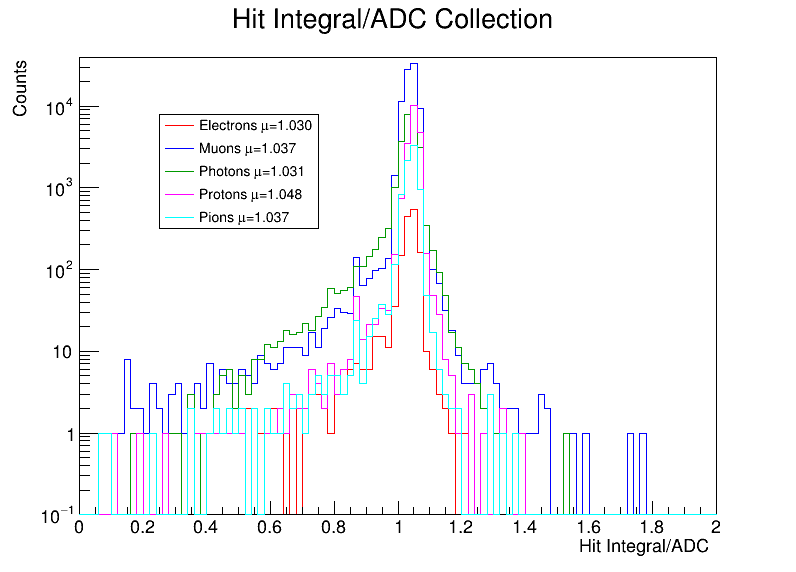

In [44]:
plotName = "h_hitAreaRatio"
plane = 2
title = "Hit Integral/ADC Collection;Hit Integral/ADC;Counts"
xmin = 0.0
xmax = 2.0
scale = False
SetLogy = True
setYbounds = True

c1 = r.TCanvas("c1", "Particle Comparison", 800, 600)
h_ele = fin.Get(f"Electrons/{plotName}_ele_plane{plane}")
h_gam = fin.Get(f"Photons/{plotName}_gamma_plane{plane}")
h_mu = fin.Get(f"Muons/{plotName}_mu_plane{plane}")
h_p = fin.Get(f"Protons/{plotName}_p_plane{plane}")
h_pi = fin.Get(f"Pions/{plotName}_pi_plane{plane}")
c1.Clear()

if scale:
    h_ele.Scale(1.0/h_ele.Integral())
    h_mu.Scale(1.0/h_mu.Integral())
    h_gam.Scale(1.0/h_gam.Integral())
    h_p.Scale(1.0/h_p.Integral())
    h_pi.Scale(1.0/h_pi.Integral())

h_ele.SetTitle(title)

h_ele.SetLineColor(r.kRed)
h_mu.SetLineColor(r.kBlue)
h_gam.SetLineColor(r.kGreen+2)
h_p.SetLineColor(r.kMagenta)
h_pi.SetLineColor(r.kCyan)

if setYbounds:
    maxY = max(h_ele.GetMaximum(), h_mu.GetMaximum(), h_gam.GetMaximum(), h_p.GetMaximum(), h_pi.GetMaximum())
    h_ele.GetYaxis().SetRangeUser(1e-1, maxY*1.2)

h_ele.GetXaxis().SetRangeUser(xmin, xmax)

h_ele.Draw('hist')
h_mu.Draw("same hist")
h_gam.Draw("same hist")
h_p.Draw("same hist")
h_pi.Draw("same hist")
if SetLogy:
    r.gPad.SetLogy()
l1 = r.TLegend(0.20, 0.60, 0.40, 0.80)
l1.AddEntry(h_ele, f"Electrons #mu={h_ele.GetMean():.3f}", "l")
l1.AddEntry(h_mu, f"Muons #mu={h_mu.GetMean():.3f}", "l")
l1.AddEntry(h_gam, f"Photons #mu={h_gam.GetMean():.3f}", "l")
l1.AddEntry(h_p, f"Protons #mu={h_p.GetMean():.3f}", "l")
l1.AddEntry(h_pi, f"Pions #mu={h_pi.GetMean():.3f}", "l")
l1.Draw("same")
c1.Draw()

 FCN=133.832 FROM MINOS     STATUS=SUCCESSFUL     25 CALLS         287 TOTAL
                     EDM=1.73199e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.40582e+02   1.46753e+01   8.51732e-02  -5.41112e-08
   2  p1          -2.42021e+01   5.69334e-01   5.69334e-01  -1.28697e-05
                               ERR DEF= 0.5
 FCN=3155 FROM MINOS     STATUS=SUCCESSFUL     12 CALLS         168 TOTAL
                     EDM=6.72198e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.02625e+03   5.76516e+01   9.08679e-05  -1.50608e-09
   2  p1          -2.34345e+01   1.35809e-01   1.35809e-01   1.55847e-04
                               ERR DEF= 0.5
 FCN=1941.01 FROM MIN

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


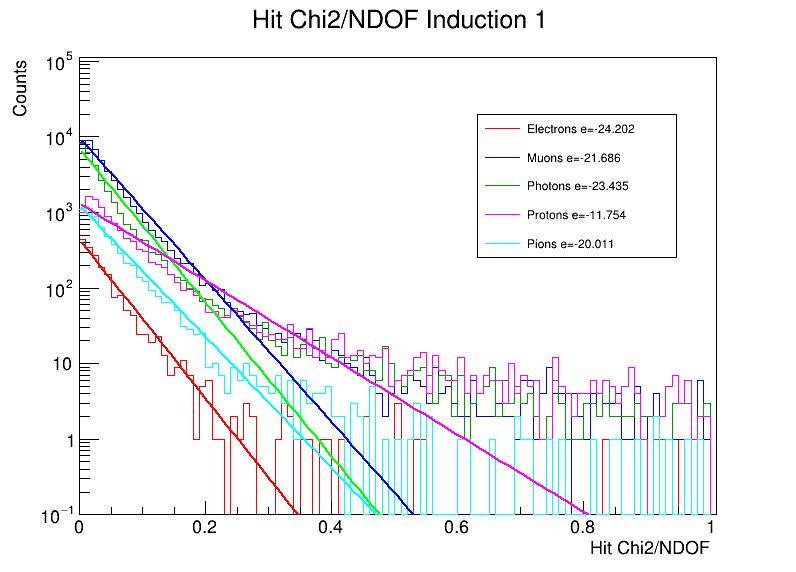

In [60]:
plotName = "h_hitFit"
plane = 0
title = "Hit Chi2/NDOF Induction 1;Hit Chi2/NDOF;Counts"
xmin = 0.0
xmax = 2.0
scale = False
SetLogy = True
setYbounds = True

c1 = r.TCanvas("c1", "Particle Comparison", 800, 600)
h_ele = fin.Get(f"Electrons/{plotName}_ele_plane{plane}")
h_gam = fin.Get(f"Photons/{plotName}_gamma_plane{plane}")
h_mu = fin.Get(f"Muons/{plotName}_mu_plane{plane}")
h_p = fin.Get(f"Protons/{plotName}_p_plane{plane}")
h_pi = fin.Get(f"Pions/{plotName}_pi_plane{plane}")
c1.Clear()

if scale:
    h_ele.Scale(1.0/h_ele.Integral())
    h_mu.Scale(1.0/h_mu.Integral())
    h_gam.Scale(1.0/h_gam.Integral())
    h_p.Scale(1.0/h_p.Integral())
    h_pi.Scale(1.0/h_pi.Integral())

h_ele.SetTitle(title)

f_ele = r.TF1("fele", "[0]*exp(x*[1])", 0, 1)
f_ele.SetParameters(1000, -0.5)
f_pi = r.TF1("fpi", "[0]*exp(x*[1])", 0, 1)
f_pi.SetParameters(1000, -0.5)
f_gam = r.TF1("fgam", "[0]*exp(x*[1])", 0, 1)
f_gam.SetParameters(1000, -0.5)
f_mu = r.TF1("fmu", "[0]*exp(x*[1])", 0, 1)
f_mu.SetParameters(1000, -0.5)
f_p = r.TF1("fp", "[0]*exp(x*[1])", 0, 1)
f_p.SetParameters(1000, -0.5)

h_ele.SetLineColor(r.kRed)
h_mu.SetLineColor(r.kBlue)
h_gam.SetLineColor(r.kGreen+2)
h_p.SetLineColor(r.kMagenta)
h_pi.SetLineColor(r.kCyan)

h_ele.Fit(f_ele, "LESMRS", "", 0, 2)
h_gam.Fit(f_gam, "LESMRS", "", 0, 2)
h_mu.Fit(f_mu, "LESMRS", "", 0, 2)
h_p.Fit(f_p, "LESMRS", "", 0, 2)
h_pi.Fit(f_pi, "LESMRS", "", 0, 2)

if setYbounds:
    maxY = max(h_ele.GetMaximum(), h_mu.GetMaximum(), h_gam.GetMaximum(), h_p.GetMaximum(), h_pi.GetMaximum())
    h_ele.GetYaxis().SetRangeUser(1e-1, maxY*1.2)

h_ele.GetXaxis().SetRangeUser(xmin, xmax)

h_ele.Draw('hist')
h_mu.Draw("same hist")
h_gam.Draw("same hist")
h_p.Draw("same hist")
h_pi.Draw("same hist")

f_ele.SetLineColor(r.kRed)
f_mu.SetLineColor(r.kBlue)
f_gam.SetLineColor(r.kGreen)
f_p.SetLineColor(r.kMagenta)
f_pi.SetLineColor(r.kCyan)
f_ele.Draw("same")
f_mu.Draw("same")
f_gam.Draw("same")
f_p.Draw("same")
f_pi.Draw("same")

if SetLogy:
    r.gPad.SetLogy()
l1 = r.TLegend(0.6, 0.55, 0.85, 0.80)
l1.AddEntry(h_ele, f"Electrons e={f_ele.GetParameter(1):.3f}", "l")
l1.AddEntry(h_mu, f"Muons e={f_mu.GetParameter(1):.3f}", "l")
l1.AddEntry(h_gam, f"Photons e={f_gam.GetParameter(1):.3f}", "l")
l1.AddEntry(h_p, f"Protons e={f_p.GetParameter(1):.3f}", "l")
l1.AddEntry(h_pi, f"Pions e={f_pi.GetParameter(1):.3f}", "l")
l1.Draw("same")
c1.Draw()

 FCN=194.654 FROM MINOS     STATUS=SUCCESSFUL     26 CALLS         234 TOTAL
                     EDM=1.11764e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.37075e+02   2.68396e+01   1.64686e-01  -9.72053e-08
   2  p1          -4.70876e+01   1.20676e+00   1.20676e+00  -8.96316e-06
                               ERR DEF= 0.5
 FCN=5080.29 FROM MINOS     STATUS=SUCCESSFUL     12 CALLS         173 TOTAL
                     EDM=7.26661e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.19754e+04   1.02552e+02   1.19356e-02  -1.90291e-08
   2  p1          -4.25982e+01   2.56960e-01   2.56960e-01   8.50303e-05
                               ERR DEF= 0.5
 FCN=5354.83 FROM 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


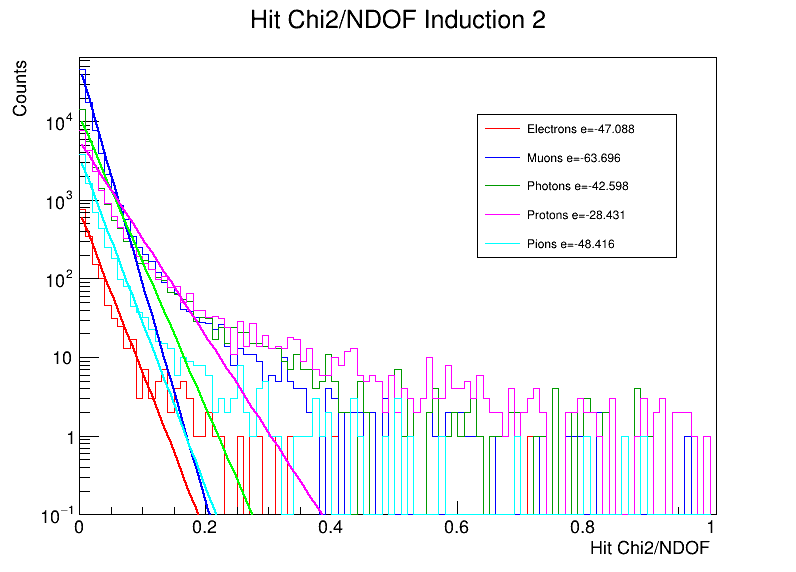

In [61]:
plotName = "h_hitFit"
plane = 1
title = "Hit Chi2/NDOF Induction 2;Hit Chi2/NDOF;Counts"
xmin = 0.0
xmax = 2.0
scale = False
SetLogy = True
setYbounds = True

c1 = r.TCanvas("c1", "Particle Comparison", 800, 600)
h_ele = fin.Get(f"Electrons/{plotName}_ele_plane{plane}")
h_gam = fin.Get(f"Photons/{plotName}_gamma_plane{plane}")
h_mu = fin.Get(f"Muons/{plotName}_mu_plane{plane}")
h_p = fin.Get(f"Protons/{plotName}_p_plane{plane}")
h_pi = fin.Get(f"Pions/{plotName}_pi_plane{plane}")
c1.Clear()

if scale:
    h_ele.Scale(1.0/h_ele.Integral())
    h_mu.Scale(1.0/h_mu.Integral())
    h_gam.Scale(1.0/h_gam.Integral())
    h_p.Scale(1.0/h_p.Integral())
    h_pi.Scale(1.0/h_pi.Integral())

h_ele.SetTitle(title)

f_ele = r.TF1("fele", "[0]*exp(x*[1])", 0, 1)
f_ele.SetParameters(1000, -0.5)
f_pi = r.TF1("fpi", "[0]*exp(x*[1])", 0, 1)
f_pi.SetParameters(1000, -0.5)
f_gam = r.TF1("fgam", "[0]*exp(x*[1])", 0, 1)
f_gam.SetParameters(1000, -0.5)
f_mu = r.TF1("fmu", "[0]*exp(x*[1])", 0, 1)
f_mu.SetParameters(1000, -0.5)
f_p = r.TF1("fp", "[0]*exp(x*[1])", 0, 1)
f_p.SetParameters(1000, -0.5)

h_ele.SetLineColor(r.kRed)
h_mu.SetLineColor(r.kBlue)
h_gam.SetLineColor(r.kGreen+2)
h_p.SetLineColor(r.kMagenta)
h_pi.SetLineColor(r.kCyan)

h_ele.Fit(f_ele, "LESMRS", "", 0, 2)
h_gam.Fit(f_gam, "LESMRS", "", 0, 2)
h_mu.Fit(f_mu, "LESMRS", "", 0, 2)
h_p.Fit(f_p, "LESMRS", "", 0, 2)
h_pi.Fit(f_pi, "LESMRS", "", 0, 2)

if setYbounds:
    maxY = max(h_ele.GetMaximum(), h_mu.GetMaximum(), h_gam.GetMaximum(), h_p.GetMaximum(), h_pi.GetMaximum())
    h_ele.GetYaxis().SetRangeUser(1e-1, maxY*1.2)

h_ele.GetXaxis().SetRangeUser(xmin, xmax)

h_ele.Draw('hist')
h_mu.Draw("same hist")
h_gam.Draw("same hist")
h_p.Draw("same hist")
h_pi.Draw("same hist")

f_ele.SetLineColor(r.kRed)
f_mu.SetLineColor(r.kBlue)
f_gam.SetLineColor(r.kGreen)
f_p.SetLineColor(r.kMagenta)
f_pi.SetLineColor(r.kCyan)
f_ele.Draw("same")
f_mu.Draw("same")
f_gam.Draw("same")
f_p.Draw("same")
f_pi.Draw("same")

if SetLogy:
    r.gPad.SetLogy()
l1 = r.TLegend(0.6, 0.55, 0.85, 0.80)
l1.AddEntry(h_ele, f"Electrons e={f_ele.GetParameter(1):.3f}", "l")
l1.AddEntry(h_mu, f"Muons e={f_mu.GetParameter(1):.3f}", "l")
l1.AddEntry(h_gam, f"Photons e={f_gam.GetParameter(1):.3f}", "l")
l1.AddEntry(h_p, f"Protons e={f_p.GetParameter(1):.3f}", "l")
l1.AddEntry(h_pi, f"Pions e={f_pi.GetParameter(1):.3f}", "l")
l1.Draw("same")
c1.Draw()

 FCN=492.882 FROM MINOS     STATUS=SUCCESSFUL     26 CALLS         263 TOTAL
                     EDM=3.49256e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.08943e+02   1.52740e+01   9.54909e-02   4.86934e-07
   2  p1          -2.81489e+01   7.42189e-01   7.42189e-01  -1.39236e-05
                               ERR DEF= 0.5
 FCN=7152.36 FROM MINOS     STATUS=SUCCESSFUL     14 CALLS         175 TOTAL
                     EDM=2.47428e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           8.53204e+03   7.23109e+01   2.60145e-03  -1.41496e-07
   2  p1          -3.01795e+01   1.80517e-01   1.80517e-01   1.07561e-04
                               ERR DEF= 0.5
 FCN=5180.23 FROM 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


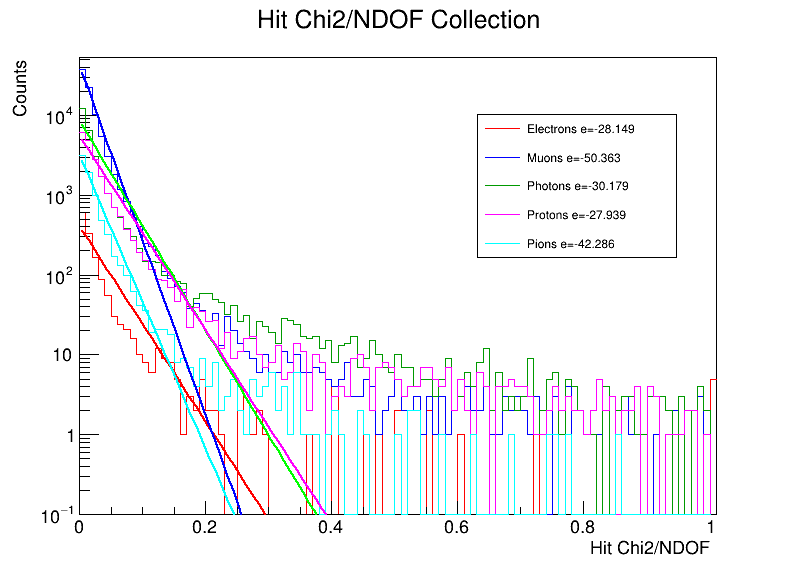

In [62]:
plotName = "h_hitFit"
plane = 2
title = "Hit Chi2/NDOF Collection;Hit Chi2/NDOF;Counts"
xmin = 0.0
xmax = 2.0
scale = False
SetLogy = True
setYbounds = True

c1 = r.TCanvas("c1", "Particle Comparison", 800, 600)
h_ele = fin.Get(f"Electrons/{plotName}_ele_plane{plane}")
h_gam = fin.Get(f"Photons/{plotName}_gamma_plane{plane}")
h_mu = fin.Get(f"Muons/{plotName}_mu_plane{plane}")
h_p = fin.Get(f"Protons/{plotName}_p_plane{plane}")
h_pi = fin.Get(f"Pions/{plotName}_pi_plane{plane}")
c1.Clear()

if scale:
    h_ele.Scale(1.0/h_ele.Integral())
    h_mu.Scale(1.0/h_mu.Integral())
    h_gam.Scale(1.0/h_gam.Integral())
    h_p.Scale(1.0/h_p.Integral())
    h_pi.Scale(1.0/h_pi.Integral())

h_ele.SetTitle(title)

f_ele = r.TF1("fele", "[0]*exp(x*[1])", 0, 1)
f_ele.SetParameters(1000, -0.5)
f_pi = r.TF1("fpi", "[0]*exp(x*[1])", 0, 1)
f_pi.SetParameters(1000, -0.5)
f_gam = r.TF1("fgam", "[0]*exp(x*[1])", 0, 1)
f_gam.SetParameters(1000, -0.5)
f_mu = r.TF1("fmu", "[0]*exp(x*[1])", 0, 1)
f_mu.SetParameters(1000, -0.5)
f_p = r.TF1("fp", "[0]*exp(x*[1])", 0, 1)
f_p.SetParameters(1000, -0.5)

h_ele.SetLineColor(r.kRed)
h_mu.SetLineColor(r.kBlue)
h_gam.SetLineColor(r.kGreen+2)
h_p.SetLineColor(r.kMagenta)
h_pi.SetLineColor(r.kCyan)

h_ele.Fit(f_ele, "LESMRS", "", 0, 2)
h_gam.Fit(f_gam, "LESMRS", "", 0, 2)
h_mu.Fit(f_mu, "LESMRS", "", 0, 2)
h_p.Fit(f_p, "LESMRS", "", 0, 2)
h_pi.Fit(f_pi, "LESMRS", "", 0, 2)

if setYbounds:
    maxY = max(h_ele.GetMaximum(), h_mu.GetMaximum(), h_gam.GetMaximum(), h_p.GetMaximum(), h_pi.GetMaximum())
    h_ele.GetYaxis().SetRangeUser(1e-1, maxY*1.2)

h_ele.GetXaxis().SetRangeUser(xmin, xmax)

h_ele.Draw('hist')
h_mu.Draw("same hist")
h_gam.Draw("same hist")
h_p.Draw("same hist")
h_pi.Draw("same hist")

f_ele.SetLineColor(r.kRed)
f_mu.SetLineColor(r.kBlue)
f_gam.SetLineColor(r.kGreen)
f_p.SetLineColor(r.kMagenta)
f_pi.SetLineColor(r.kCyan)
f_ele.Draw("same")
f_mu.Draw("same")
f_gam.Draw("same")
f_p.Draw("same")
f_pi.Draw("same")

if SetLogy:
    r.gPad.SetLogy()
l1 = r.TLegend(0.6, 0.55, 0.85, 0.80)
l1.AddEntry(h_ele, f"Electrons e={f_ele.GetParameter(1):.3f}", "l")
l1.AddEntry(h_mu, f"Muons e={f_mu.GetParameter(1):.3f}", "l")
l1.AddEntry(h_gam, f"Photons e={f_gam.GetParameter(1):.3f}", "l")
l1.AddEntry(h_p, f"Protons e={f_p.GetParameter(1):.3f}", "l")
l1.AddEntry(h_pi, f"Pions e={f_pi.GetParameter(1):.3f}", "l")
l1.Draw("same")
c1.Draw()

### Analyze sqlite DB 

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

db_path = "/nashome/m/micarrig/icarus/hitTuning/hitTuning_merged_v2.db"
table = 'runs'

# Connect to the DB
conn = sqlite3.connect(db_path)

# Load whole table into a DataFrame
df = pd.read_sql_query(f"SELECT * FROM {table}", conn)

conn.close()

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.set_option('display.width', 0)

#note job num 0 (and 1) are the default configs

default = df[df['jobNum'] == 0]

df

,id,jobNum,timestamp,fcl_filename,output_filename,hist_filename,roiThreshold_0,roiThreshold_1,roiThreshold_2,minPulseHeight_0,minPulseHeight_1,minPulseHeight_2,minPulseSigma_0,minPulseSigma_1,minPulseSigma_2,LongMaxHits_0,LongMaxHits_1,LongMaxHits_2,LongPulseWidth_0,LongPulseWidth_1,LongPulseWidth_2,PulseHeightCuts_0,PulseHeightCuts_1,PulseHeightCuts_2,PulseWidthCuts_0,PulseWidthCuts_1,PulseWidthCuts_2,PulseRatioCuts_0,PulseRatioCuts_1,PulseRatioCuts_2,MaxMultiHit,Chi2NDF,notes,ratio_total,ratio_total0,ratio_total1,ratio_total2,ratio_ele,ratio_ele0,ratio_ele1,ratio_ele2,ratio_gamma,ratio_gamma0,ratio_gamma1,ratio_gamma2,ratio_mu,ratio_mu0,ratio_mu1,ratio_mu2,ratio_p,ratio_p0,ratio_p1,ratio_p2,ratio_pi,ratio_pi0,ratio_pi1,ratio_pi2
0,1,63,2025-12-16T21:35:49.796090,/cvmfs/fifeuser1.opensciencegrid.org/sw/icarus...,/srv/no_xfer/0/TRANSFERRED_INPUT_FILES/output_...,None,6.0,6.0,6.0,2.0,2.0,2.0,1.0,1.0,1.0,3,3,3,5.0,5.0,5.0,3.0,3.0,3.0,2.0,1.5,1.0,0.35,0.4,0.2,6,2000.0,,0.783605,0.767635,0.781765,0.801421,0.771252,0.757664,0.771890,0.784229,0.782383,0.765984,0.780858,0.800308,0.786643,0.769235,0.785374,0.805324,0.783614,0.767474,0.782298,0.801080,0.763300,0.753416,0.758709,0.777777
1,2,290,2025-12-17T01:05:30.137753,/cvmfs/fifeuser1.opensciencegrid.org/sw/icarus...,/srv/no_xfer/0/TRANSFERRED_INPUT_FILES/output_...,None,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,3,3,3,5.0,5.0,5.0,3.0,3.0,3.0,2.0,1.5,1.0,0.35,0.4,0.2,6,2500.0,,0.783292,0.765112,0.784497,0.800283,0.770990,0.755377,0.774303,0.783328,0.782140,0.763454,0.783808,0.799175,0.786172,0.766391,0.788017,0.804125,0.783285,0.764881,0.785059,0.799934,0.762333,0.749631,0.760910,0.776474
2,3,423,2025-12-17T03:39:03.219225,/cvmfs/fifeuser1.opensciencegrid.org/sw/icarus...,/srv/no_xfer/0/TRANSFERRED_INPUT_FILES/output_...,None,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,2,2,2,5.0,5.0,5.0,3.0,3.0,3.0,2.0,1.5,1.0,0.35,0.4,0.2,10,2000.0,,0.785994,0.772624,0.787585,0.797788,0.774747,0.765281,0.778687,0.780321,0.784817,0.771194,0.786580,0.796695,0.788824,0.774031,0.791194,0.801269,0.786015,0.772429,0.788180,0.797456,0.765716,0.756796,0.765123,0.775247
3,4,433,2025-12-17T03:53:48.679290,/cvmfs/fifeuser1.opensciencegrid.org/sw/icarus...,/srv/no_xfer/0/TRANSFERRED_INPUT_FILES/output_...,None,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,3,3,3,5.0,5.0,5.0,3.0,3.0,3.0,2.0,1.5,1.0,0.35,0.4,0.2,7,2000.0,,0.783707,0.766845,0.786018,0.798281,0.771167,0.756539,0.775426,0.781583,0.782509,0.765268,0.785088,0.797195,0.786495,0.767859,0.789642,0.802012,0.783690,0.766602,0.786574,0.797918,0.763038,0.752170,0.762345,0.774616
4,5,312,2025-12-17T01:28:13.502587,/cvmfs/fifeuser1.opensciencegrid.org/sw/icarus...,/srv/no_xfer/0/TRANSFERRED_INPUT_FILES/output_...,None,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1,1,1,5.0,5.0,5.0,3.0,3.0,3.0,2.0,1.5,1.0,0.35,0.4,0.2,6,1750.0,,0.784430,0.765911,0.786226,0.801174,0.771475,0.754808,0.776525,0.783145,0.783173,0.764236,0.785251,0.800050,0.787301,0.767454,0.790029,0.804449,0.784416,0.765671,0.786785,0.800813,0.761841,0.746052,0.762096,0.777399
5,6,408,2025-12-17T03:18:01.917154,/cvmfs/fifeuser1.opensciencegrid.org/sw/icarus...,/srv/no_xfer/0/TRANSFERRED_INPUT_FILES/output_...,None,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,2,2,2,5.0,5.0,5.0,3.0,3.0,3.0,2.0,1.5,1.0,0.35,0.4,0.2,7,2000.0,,0.782396,0.764273,0.785519,0.797422,0.771463,0.757853,0.776539,0.780044,0.781076,0.762956,0.784223,0.796071,0.784955,0.764989,0.789050,0.800854,0.782404,0.764039,0.786124,0.797082,0.762102,0.748459,0.762850,0.775028
6,7,399,2025-12-17T03:09:36.150063,/cvmfs/fifeuser1.opensciencegrid.org/sw/icarus...,/srv/no_xfer/0/TRANSFERRED_INPUT_FILES/output_...,None,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1,1,1,5.0,5.0,5.0,3.0,3.0,3.0,2.0,1.5,1.0,0.35,0.4,0.2,10,2250.0,,0.789150,0.776852,0.788193,0.802412,0.776098,0.764319,0.779127,0.784887,0.787950,0.775332,0.787215,0.801313,0.792202,0.778902,0.791887,0.805835,0.789180,0.776746,0.788729,0.802073,0.768044,0.760103,0.764999,0.779036
7,8,355,2025-12-17T02:29:30.349952,/cvmfs/fifeuser1.opensci

In [4]:
df.to_csv("/nashome/m/micarrig/icarus/hitTuning/hitTuning_results_summary_v2.csv", index=False)

In [5]:
def plotRatios(name, title, range, bins, color):
    plt.figure(figsize=(20,16))

    col_names = [f'ratio_{name}', f'ratio_{name}0', f'ratio_{name}1', f'ratio_{name}2']
    planes = ['All Planes', 'Induction 1', 'Induction 2', 'Collection']

    for ic, c in enumerate(col_names):

        plt.subplot(2, 2, ic+1)
        counts, bins, patches = plt.hist(
            df[c],
            range=range,
            bins=bins,
            alpha=0.7,
            color=color,
            edgecolor='black'
        )

        # Example: pick a value of interest and point at the bin containing it
        value = default[c].iloc[0]  # change to the ratio you care about
        bin_index = np.digitize([value], bins)[0] - 1
        bin_index = max(0, min(bin_index, len(counts)-1))

        x_bin_center = 0.5 * (bins[bin_index] + bins[bin_index+1])
        y_bin_height = counts[bin_index]

        plt.annotate(
            f"{value:.2f}",
            xy=(x_bin_center, y_bin_height),
            xytext=(x_bin_center, y_bin_height * 1.2),
            arrowprops=dict(arrowstyle="->", color="red", lw=2),
            ha="center",
            color="red"
        )
        plt.title(f'Sum of Hit/IDE Energy per Event {title} ({planes[ic]})')
        plt.xlabel('Ratio Event Hit/IDE Energy')
        plt.ylabel('Trials')
    plt.show()

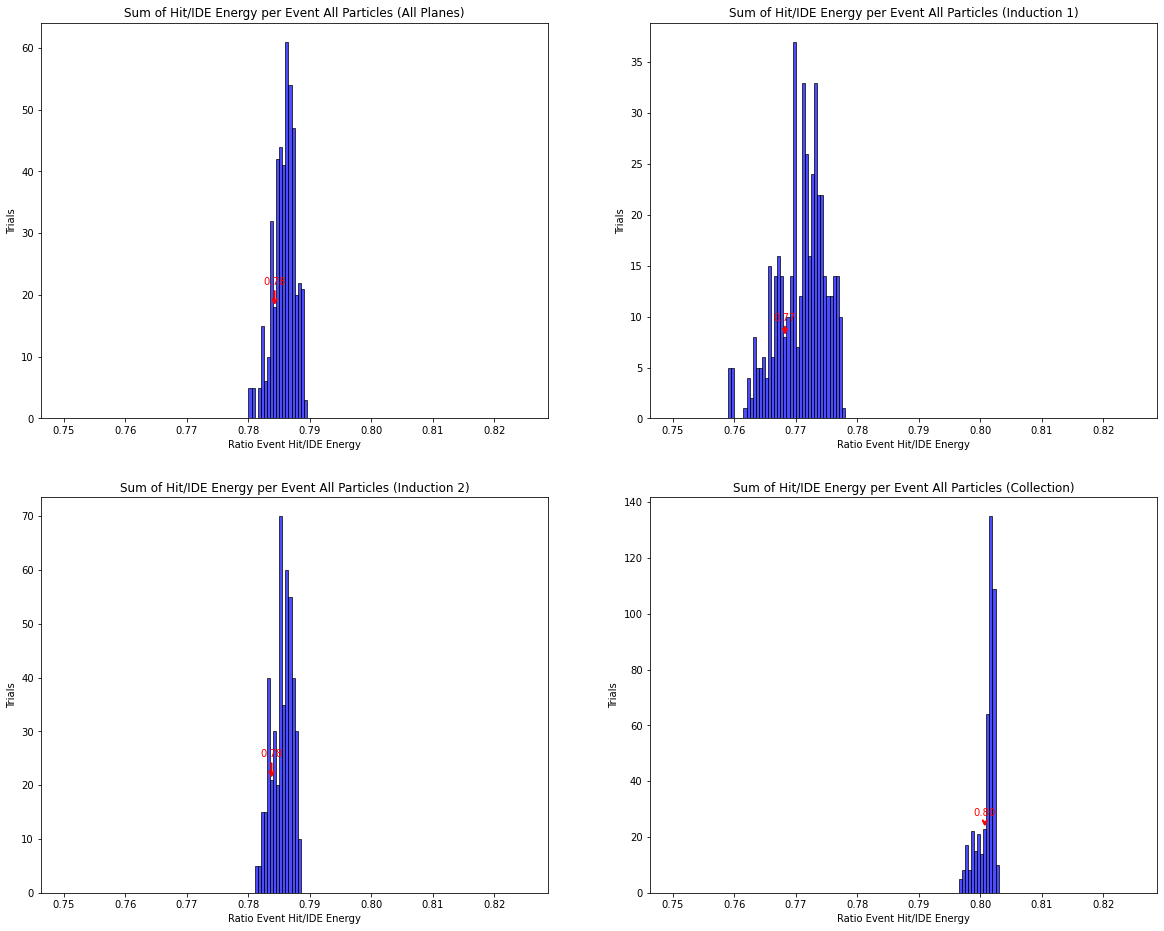

In [6]:
plotRatios('total', 'All Particles', (0.750, 0.825), 150, 'blue')

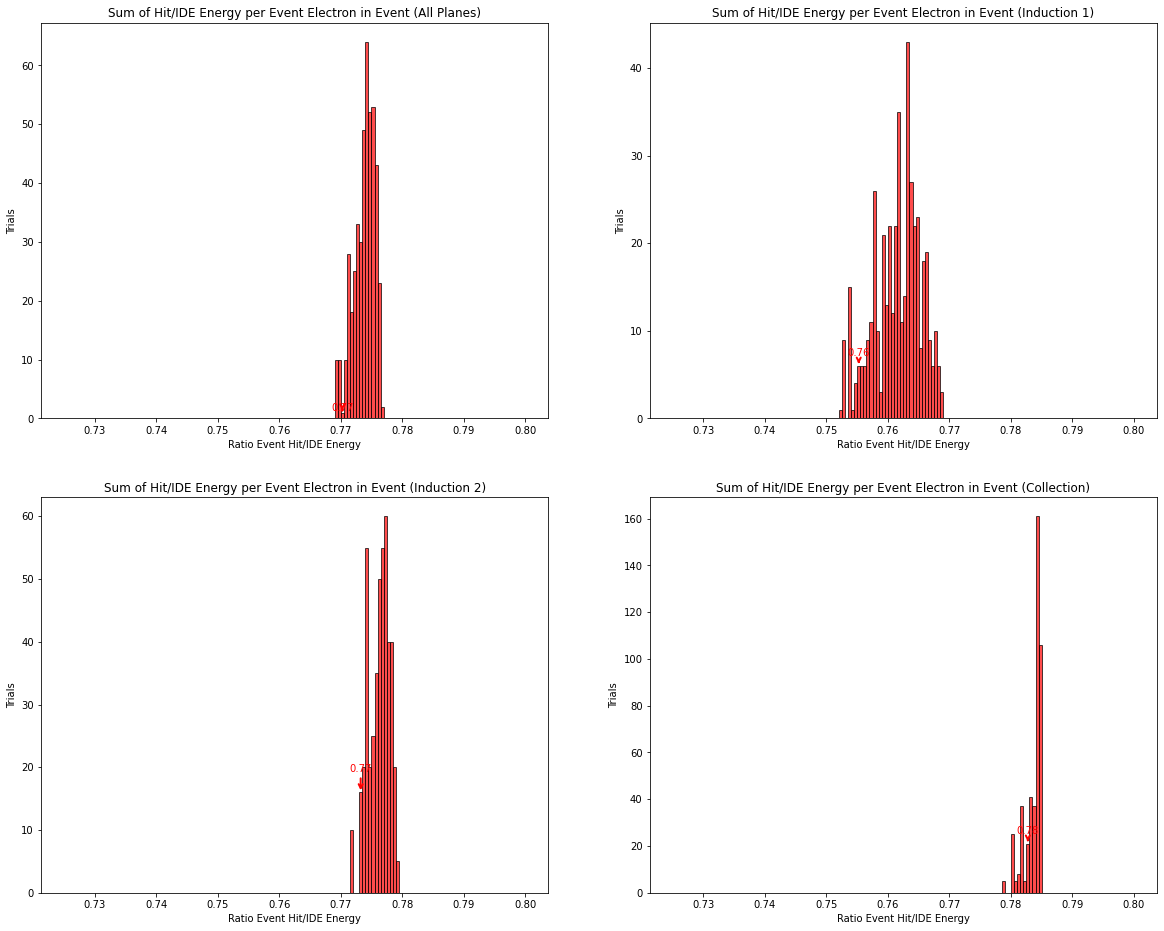

In [7]:
plotRatios('ele', 'Electron in Event', (0.725, 0.80), 150, 'red')

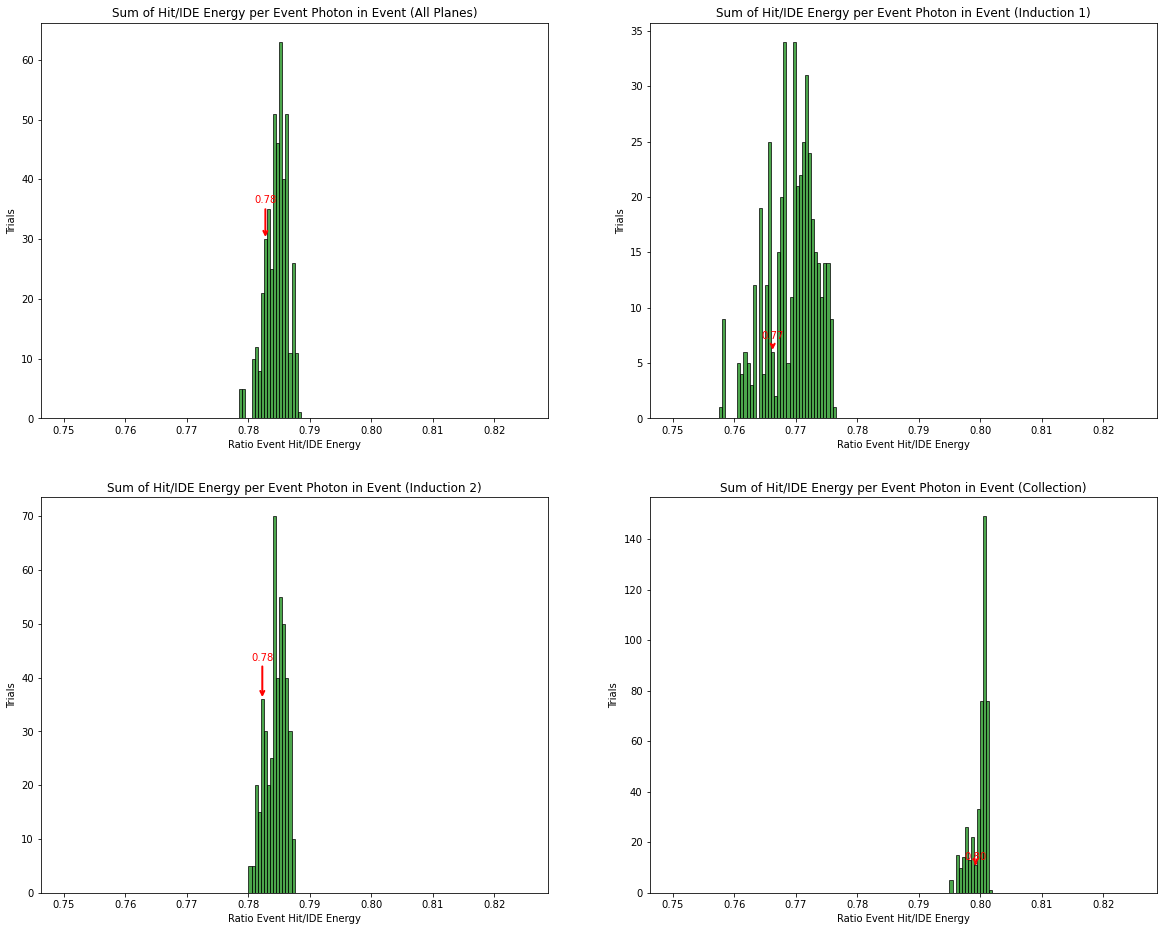

In [8]:
plotRatios('gamma', 'Photon in Event', (0.750, 0.825), 150, 'green')

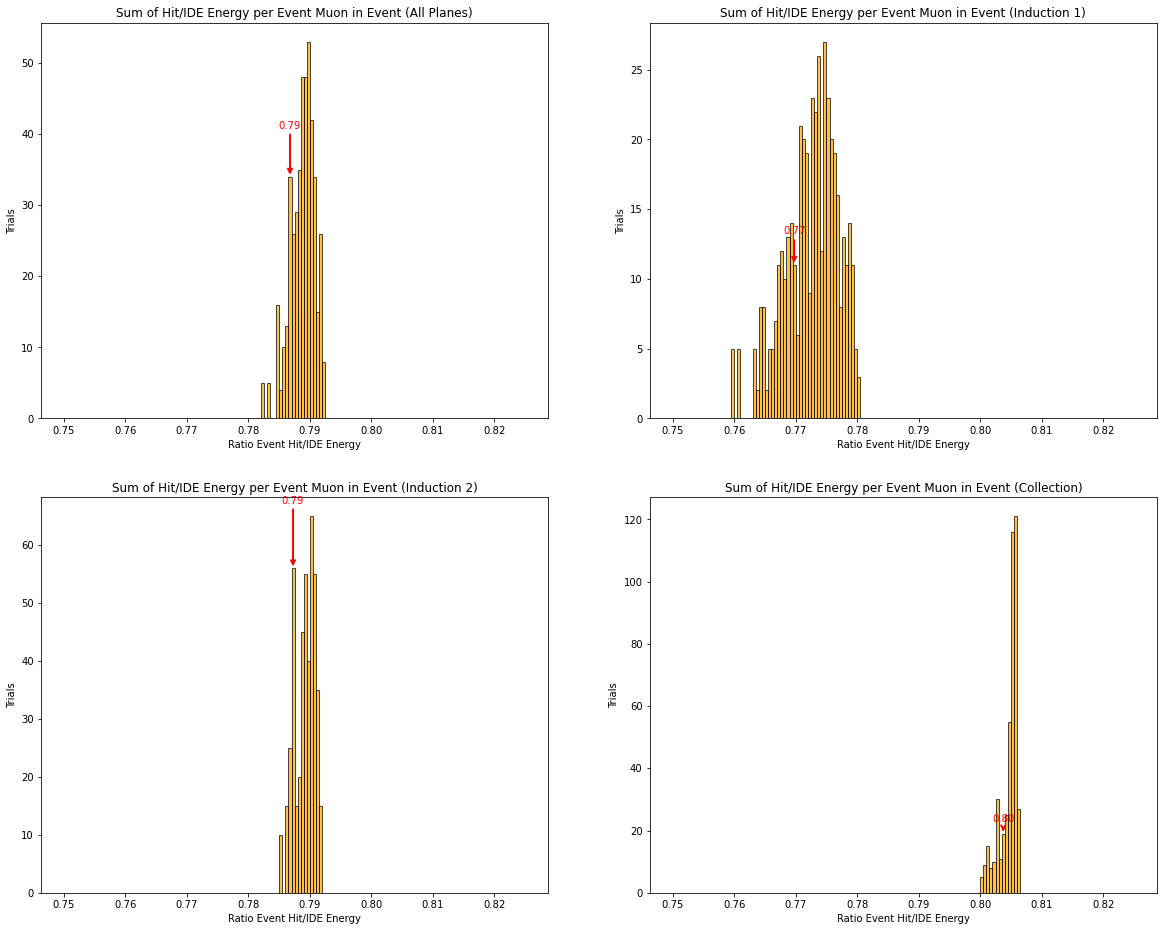

In [9]:
plotRatios('mu', 'Muon in Event', (0.750, 0.825), 150, 'orange')

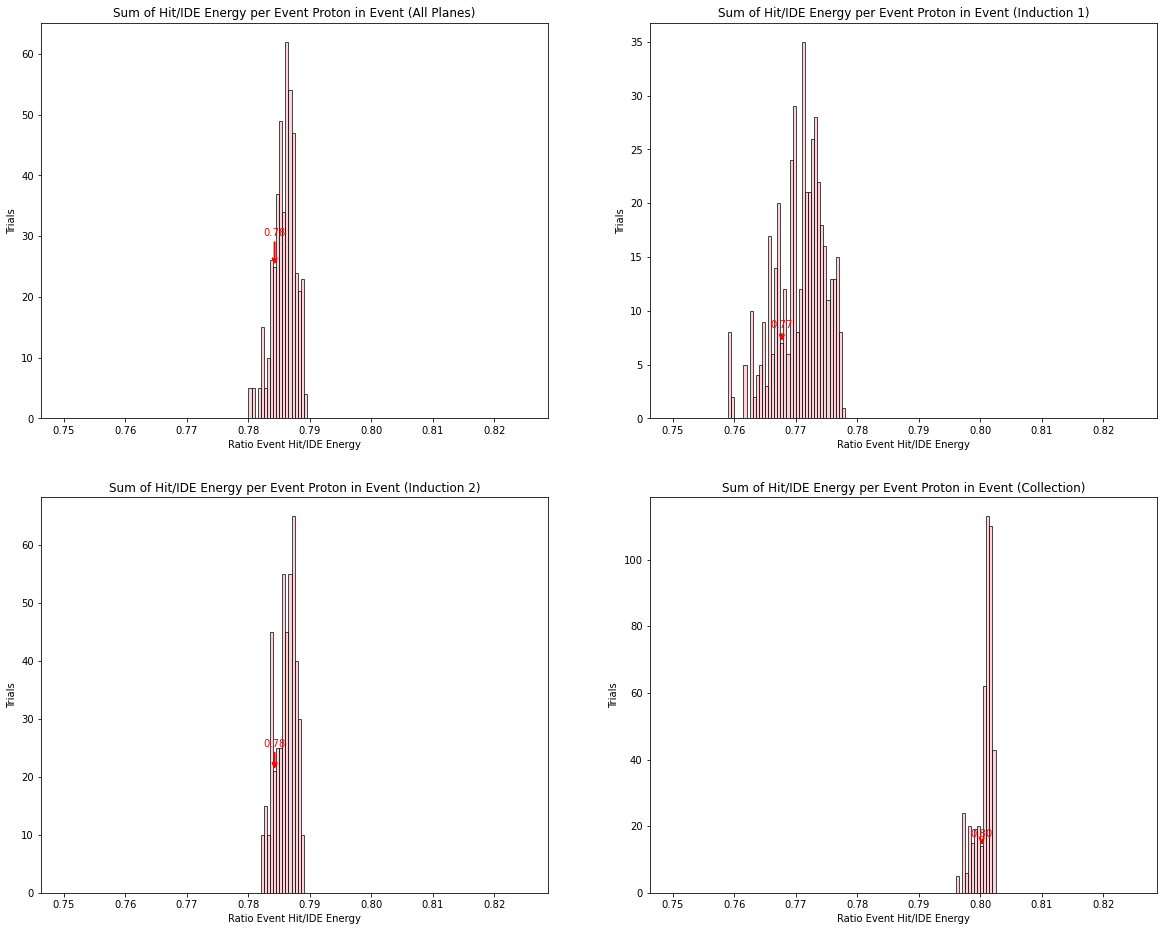

In [10]:
plotRatios('p', 'Proton in Event', (0.750, 0.825), 150, 'pink')

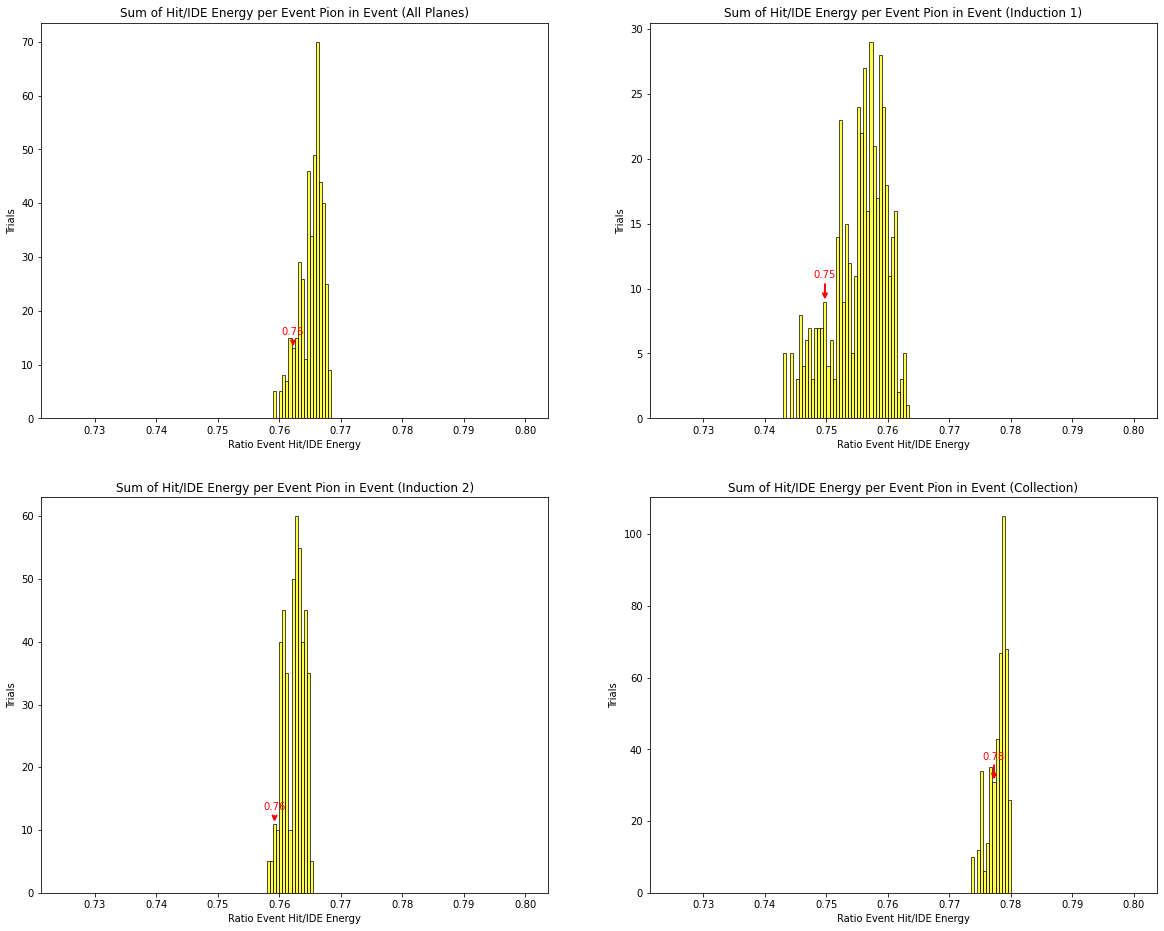

In [11]:
plotRatios('pi', 'Pion in Event', (0.725, 0.80), 150, 'yellow')

In [178]:
# compare one of the best parameter sets to the default

f_default = r.TFile.Open('root://fndcadoor.fnal.gov://icarus/scratch/users/micarrig/hitTuning/mc/grid/outputs/00/hist_output_0.root', 'READ')
f_mod0 = r.TFile.Open('root://fndcadoor.fnal.gov://icarus/scratch/users/micarrig/hitTuning/mc/grid/outputs/00/hist_output_23.root', 'READ')
f_mod1 = r.TFile.Open('root://fndcadoor.fnal.gov://icarus/scratch/users/micarrig/hitTuning/mc/grid/outputs/00/hist_output_12.root', 'READ')
f_mod2 = r.TFile.Open('root://fndcadoor.fnal.gov://icarus/scratch/users/micarrig/hitTuning/mc/grid/outputs/00/hist_output_58.root', 'READ')
f_mod3 = r.TFile.Open('root://fndcadoor.fnal.gov://icarus/scratch/users/micarrig/hitTuning/mc/grid/outputs/00/hist_output_9.root', 'READ')

files = [f_default, f_mod0, f_mod1, f_mod2, f_mod3]
labels = ['Default', 'Mod Set 0', 'Mod Set 1', 'Mod Set 2', 'Mod Set 3']
colors = [r.kBlack, r.kRed, r.kBlue, r.kGreen+2, r.kMagenta]

In [175]:
f_default.cd("AllParticles")
f_default.ls()

TNetXNGFile**		root://fndcadoor.fnal.gov//icarus/scratch/users/micarrig/hitTuning/mc/grid/outputs/00/hist_output_0.root	
 TNetXNGFile*		root://fndcadoor.fnal.gov//icarus/scratch/users/micarrig/hitTuning/mc/grid/outputs/00/hist_output_0.root	
  TDirectoryFile*		AllParticles	AllParticles
   OBJ: TH1F	h_energyRatio_plane0	Hit to IDE Energy Ratio All Particles (Plane 0) : 0 at: 0xf82f240
   OBJ: TH1F	h_energyRatio_plane1	Hit to IDE Energy Ratio All Particles (Plane 1) : 0 at: 0x1018da20
   OBJ: TH1F	h_energyRatio_plane2	Hit to IDE Energy Ratio All Particles (Plane 2) : 0 at: 0x102ec2e0
   OBJ: TH1F	h_hitAreaRatio_plane0	Hit Integral/ADC Ratio All Particles (Plane 0) : 0 at: 0x102a3ae0
   OBJ: TH1F	h_hitAreaRatio_plane1	Hit Integral/ADC Ratio All Particles (Plane 1) : 0 at: 0x102a4850
   OBJ: TH1F	h_hitAreaRatio_plane2	Hit Integral/ADC Ratio All Particles (Plane 2) : 0 at: 0x1017cb80
   KEY: TH1F	h_hitEnergy_plane0;1	Hit Energy from BackTrackerHitMatchingData Plane 0
   KEY: TH1F	h_ideEnerg

[<cppyy.gbl.TH1F object at 0xf82f240>, <cppyy.gbl.TH1F object at 0x102eca70>, <cppyy.gbl.TH1F object at 0x1000f1d0>, <cppyy.gbl.TH1F object at 0xf805580>, <cppyy.gbl.TH1F object at 0xda96930>]
[<cppyy.gbl.TH1F object at 0x1018da20>, <cppyy.gbl.TH1F object at 0x102675d0>, <cppyy.gbl.TH1F object at 0x10388450>, <cppyy.gbl.TH1F object at 0xc040b50>, <cppyy.gbl.TH1F object at 0xc426cd0>]
[<cppyy.gbl.TH1F object at 0x102ec2e0>, <cppyy.gbl.TH1F object at 0xf81b090>, <cppyy.gbl.TH1F object at 0x100f3490>, <cppyy.gbl.TH1F object at 0xdabf8a0>, <cppyy.gbl.TH1F object at 0xc91a5e0>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


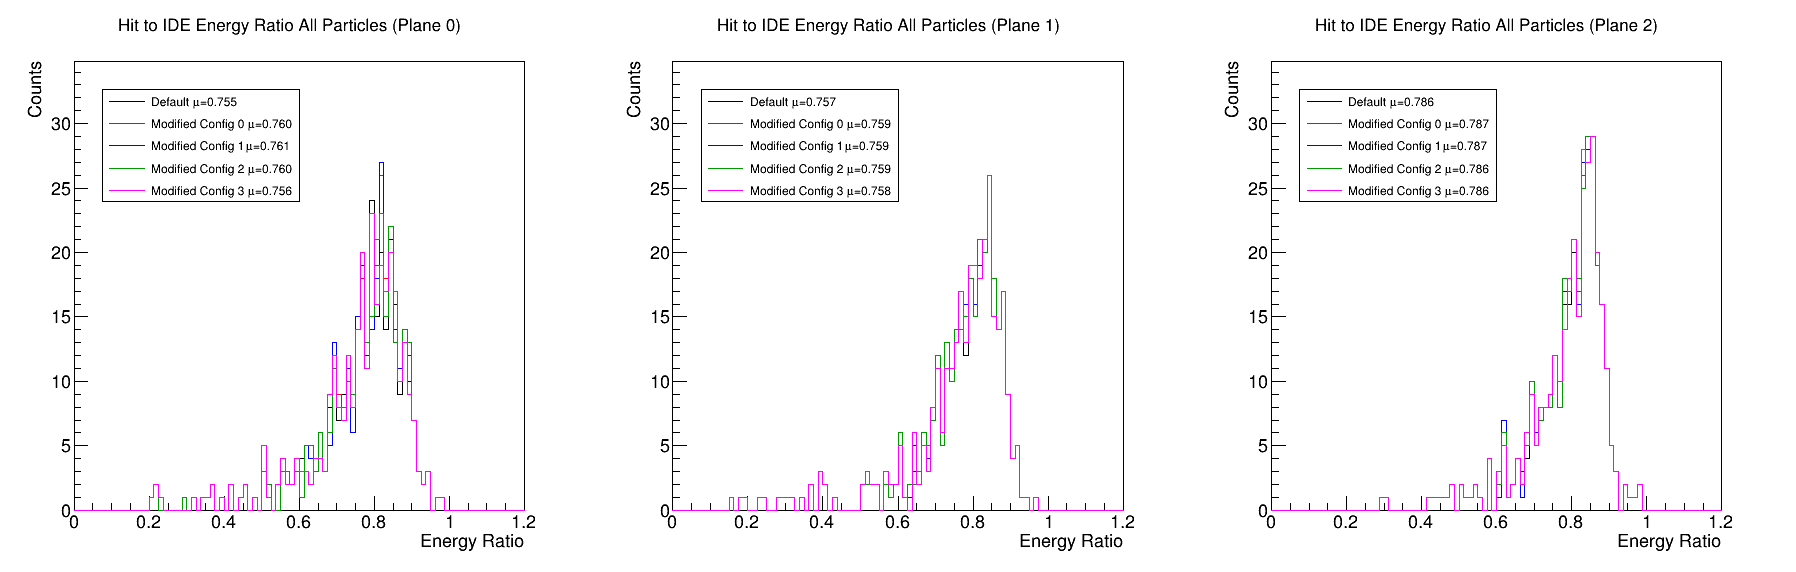

In [163]:
plotName = "AllParticles/h_energyRatio_plane"
particle = "All Particles"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Modified Config 0', 'Modified Config 1', 'Modified Config 2', 'Modified Config 3']
hists = [[] for _ in range(3)]

for f in files:
    hists[0].append(f.Get(f"{plotName}0"))
    hists[1].append(f.Get(f"{plotName}1"))
    hists[2].append(f.Get(f"{plotName}2"))

maxY = np.zeros(len(hists[0]))
for hset in hists:
    for i in range(len(hset)):
        if hset[i].GetMaximum() > maxY[i]:
            maxY[i] = hset[i].GetMaximum()

legends = [r.TLegend(0.15, 0.65, 0.50, 0.85) for _ in range(3)]

for ic, hset in enumerate(hists):
    print(hset)
    c1.cd(ic+1)
    for i in range(len(hset)):
        hset[i].SetLineColor(colors[i])
        if i == 0:
            hset[i].GetYaxis().SetRangeUser(0, maxY[i]*1.2)
            hset[i].GetXaxis().SetRangeUser(0, 1.2)
            hset[i].SetTitle(f"Hit to IDE Energy Ratio {particle} (Plane {ic});Energy Ratio;Counts")
            hset[i].Draw("hist")
        else:
            hset[i].Draw("hist same")
        legends[ic].AddEntry(hset[i], f'{labels[i]} #mu={hset[i].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

[<cppyy.gbl.TH1F object at 0x103ed2d0>, <cppyy.gbl.TH1F object at 0xdad4280>, <cppyy.gbl.TH1F object at 0x100f0d60>, <cppyy.gbl.TH1F object at 0xc9516f0>, <cppyy.gbl.TH1F object at 0xc3de050>]
[<cppyy.gbl.TH1F object at 0x10193fc0>, <cppyy.gbl.TH1F object at 0xff376c0>, <cppyy.gbl.TH1F object at 0xf7914e0>, <cppyy.gbl.TH1F object at 0x10164e80>, <cppyy.gbl.TH1F object at 0xc915e00>]
[<cppyy.gbl.TH1F object at 0xc6d3b20>, <cppyy.gbl.TH1F object at 0x101533d0>, <cppyy.gbl.TH1F object at 0xde07aa0>, <cppyy.gbl.TH1F object at 0x102fe960>, <cppyy.gbl.TH1F object at 0x100da3e0>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


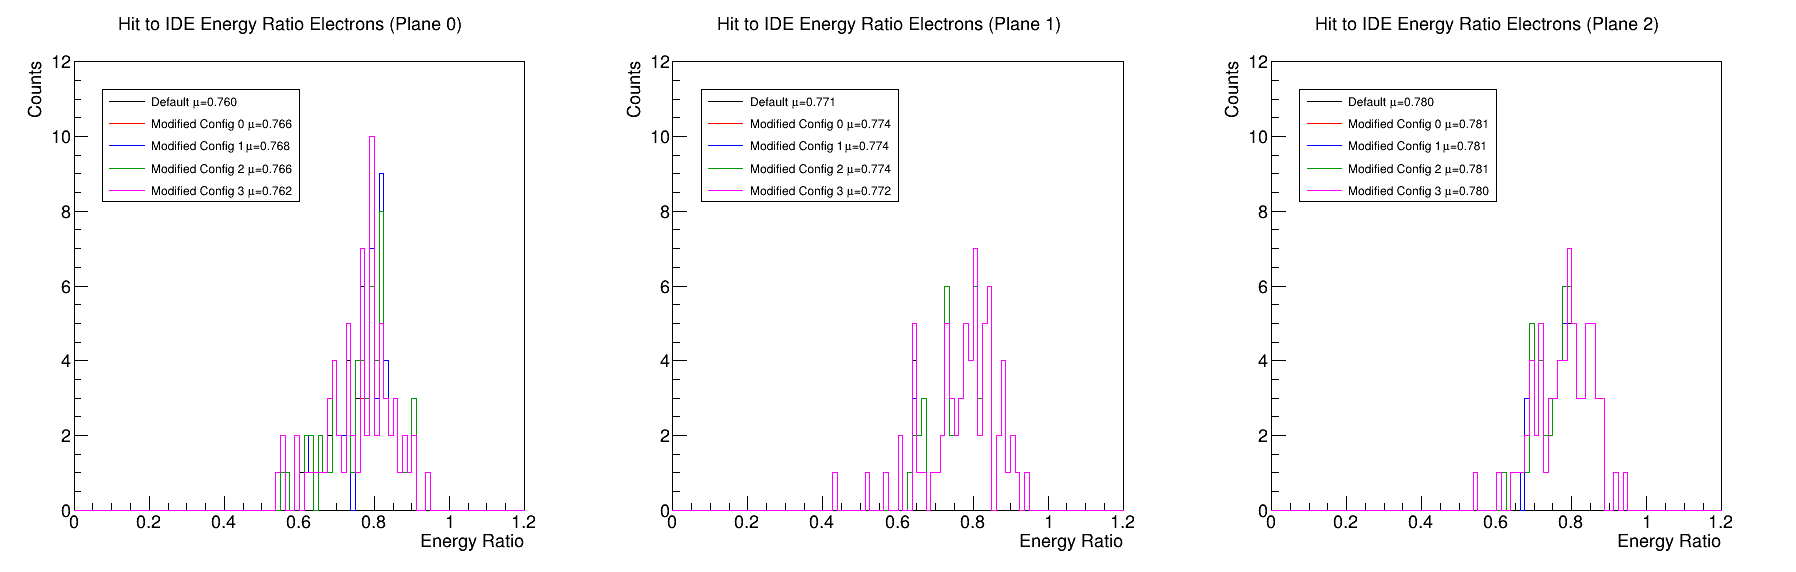

In [164]:
plotName = "Electrons/h_energyRatio_ele_plane"
particle = "Electrons"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Modified Config 0', 'Modified Config 1', 'Modified Config 2', 'Modified Config 3']
hists = [[] for _ in range(3)]

for f in files:
    hists[0].append(f.Get(f"{plotName}0"))
    hists[1].append(f.Get(f"{plotName}1"))
    hists[2].append(f.Get(f"{plotName}2"))

maxY = np.zeros(len(hists[0]))
for hset in hists:
    for i in range(len(hset)):
        if hset[i].GetMaximum() > maxY[i]:
            maxY[i] = hset[i].GetMaximum()

legends = [r.TLegend(0.15, 0.65, 0.50, 0.85) for _ in range(3)]

for ic, hset in enumerate(hists):
    print(hset)
    c1.cd(ic+1)
    for i in range(len(hset)):
        hset[i].SetLineColor(colors[i])
        if i == 0:
            hset[i].GetYaxis().SetRangeUser(0, maxY[i]*1.2)
            hset[i].GetXaxis().SetRangeUser(0, 1.2)
            hset[i].SetTitle(f"Hit to IDE Energy Ratio {particle} (Plane {ic});Energy Ratio;Counts")
            hset[i].Draw("hist")
        else:
            hset[i].Draw("hist same")
        legends[ic].AddEntry(hset[i], f'{labels[i]} #mu={hset[i].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

[<cppyy.gbl.TH1F object at 0xff41f70>, <cppyy.gbl.TH1F object at 0xf80f470>, <cppyy.gbl.TH1F object at 0xf700aa0>, <cppyy.gbl.TH1F object at 0xc390ac0>, <cppyy.gbl.TH1F object at 0x1016d130>]
[<cppyy.gbl.TH1F object at 0xc38faa0>, <cppyy.gbl.TH1F object at 0xfe4e480>, <cppyy.gbl.TH1F object at 0xffa30b0>, <cppyy.gbl.TH1F object at 0x100bcbc0>, <cppyy.gbl.TH1F object at 0x10394480>]
[<cppyy.gbl.TH1F object at 0xdaba280>, <cppyy.gbl.TH1F object at 0xff4dd60>, <cppyy.gbl.TH1F object at 0x1016e0a0>, <cppyy.gbl.TH1F object at 0xf95fe80>, <cppyy.gbl.TH1F object at 0x103d2aa0>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


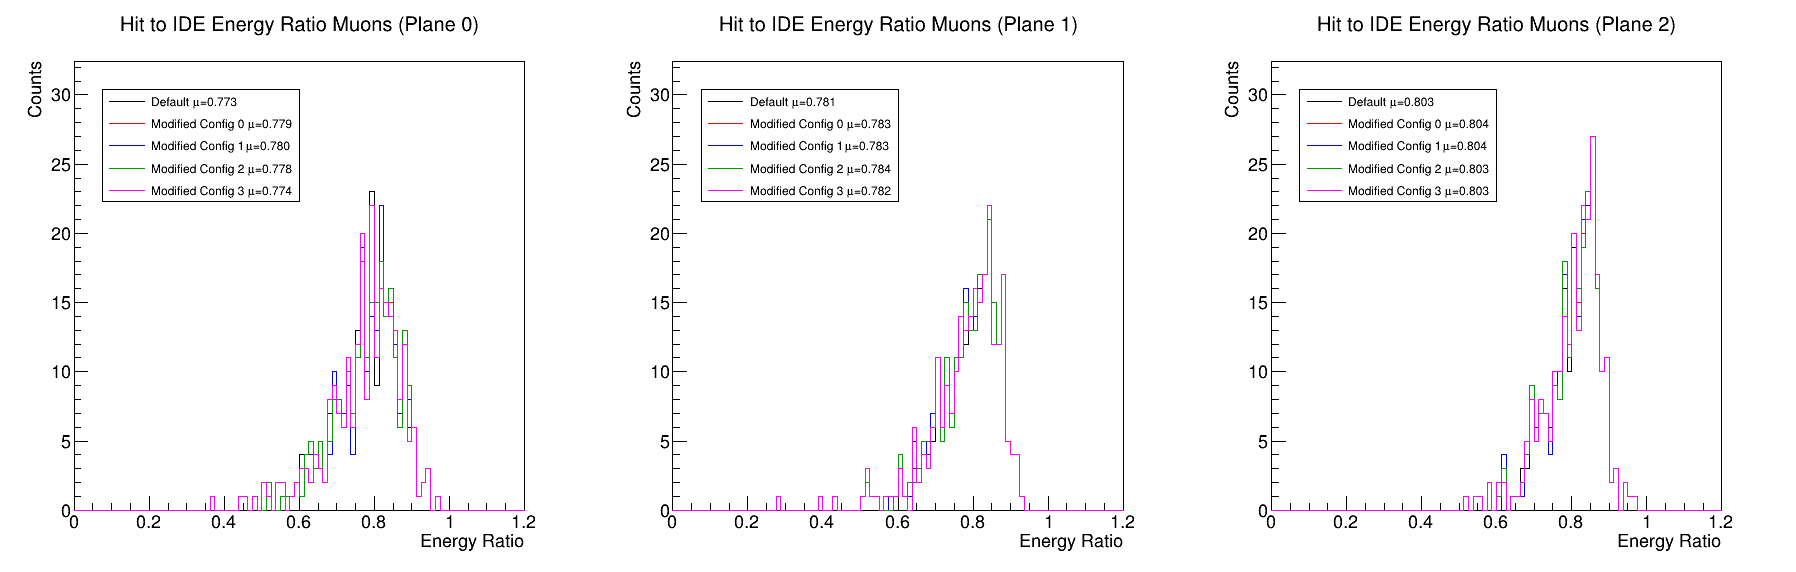

In [165]:
plotName = "Muons/h_energyRatio_mu_plane"
particle = "Muons"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Modified Config 0', 'Modified Config 1', 'Modified Config 2', 'Modified Config 3']
hists = [[] for _ in range(3)]

for f in files:
    hists[0].append(f.Get(f"{plotName}0"))
    hists[1].append(f.Get(f"{plotName}1"))
    hists[2].append(f.Get(f"{plotName}2"))

maxY = np.zeros(len(hists[0]))
for hset in hists:
    for i in range(len(hset)):
        if hset[i].GetMaximum() > maxY[i]:
            maxY[i] = hset[i].GetMaximum()

legends = [r.TLegend(0.15, 0.65, 0.50, 0.85) for _ in range(3)]

for ic, hset in enumerate(hists):
    print(hset)
    c1.cd(ic+1)
    for i in range(len(hset)):
        hset[i].SetLineColor(colors[i])
        if i == 0:
            hset[i].GetYaxis().SetRangeUser(0, maxY[i]*1.2)
            hset[i].GetXaxis().SetRangeUser(0, 1.2)
            hset[i].SetTitle(f"Hit to IDE Energy Ratio {particle} (Plane {ic});Energy Ratio;Counts")
            hset[i].Draw("hist")
        else:
            hset[i].Draw("hist same")
        legends[ic].AddEntry(hset[i], f'{labels[i]} #mu={hset[i].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

[<cppyy.gbl.TH1F object at 0xdab92f0>, <cppyy.gbl.TH1F object at 0x10269c90>, <cppyy.gbl.TH1F object at 0xfe7f410>, <cppyy.gbl.TH1F object at 0x102f16d0>, <cppyy.gbl.TH1F object at 0xffa5c50>]
[<cppyy.gbl.TH1F object at 0xf82a820>, <cppyy.gbl.TH1F object at 0xffadb70>, <cppyy.gbl.TH1F object at 0x102eab10>, <cppyy.gbl.TH1F object at 0x1018f8d0>, <cppyy.gbl.TH1F object at 0x1016c6f0>]
[<cppyy.gbl.TH1F object at 0x1019baa0>, <cppyy.gbl.TH1F object at 0x101631f0>, <cppyy.gbl.TH1F object at 0xff4eff0>, <cppyy.gbl.TH1F object at 0x10305fc0>, <cppyy.gbl.TH1F object at 0x10184b20>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


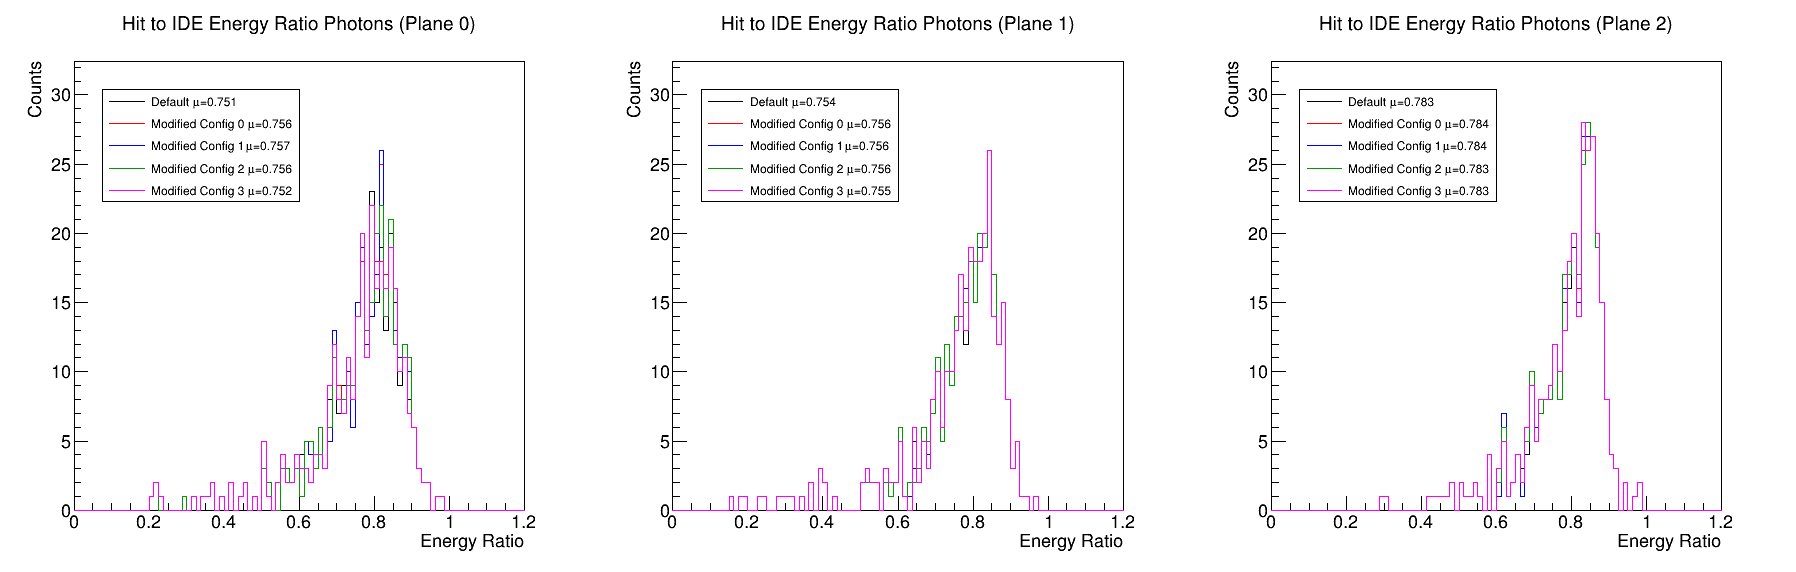

In [166]:
plotName = "Photons/h_energyRatio_gamma_plane"
particle = 'Photons'
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Modified Config 0', 'Modified Config 1', 'Modified Config 2', 'Modified Config 3']
hists = [[] for _ in range(3)]

for f in files:
    hists[0].append(f.Get(f"{plotName}0"))
    hists[1].append(f.Get(f"{plotName}1"))
    hists[2].append(f.Get(f"{plotName}2"))

maxY = np.zeros(len(hists[0]))
for hset in hists:
    for i in range(len(hset)):
        if hset[i].GetMaximum() > maxY[i]:
            maxY[i] = hset[i].GetMaximum()

legends = [r.TLegend(0.15, 0.65, 0.50, 0.85) for _ in range(3)]

for ic, hset in enumerate(hists):
    print(hset)
    c1.cd(ic+1)
    for i in range(len(hset)):
        hset[i].SetLineColor(colors[i])
        if i == 0:
            hset[i].GetYaxis().SetRangeUser(0, maxY[i]*1.2)
            hset[i].GetXaxis().SetRangeUser(0, 1.2)
            hset[i].SetTitle(f"Hit to IDE Energy Ratio {particle} (Plane {ic});Energy Ratio;Counts")
            hset[i].Draw("hist")
        else:
            hset[i].Draw("hist same")
        legends[ic].AddEntry(hset[i], f'{labels[i]} #mu={hset[i].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

[<cppyy.gbl.TH1F object at 0xff35a20>, <cppyy.gbl.TH1F object at 0xffff830>, <cppyy.gbl.TH1F object at 0x1026d8d0>, <cppyy.gbl.TH1F object at 0xc5f9aa0>, <cppyy.gbl.TH1F object at 0x10461c50>]
[<cppyy.gbl.TH1F object at 0x100be4d0>, <cppyy.gbl.TH1F object at 0x10267f30>, <cppyy.gbl.TH1F object at 0xff1d8b0>, <cppyy.gbl.TH1F object at 0x103997c0>, <cppyy.gbl.TH1F object at 0xffcddc0>]
[<cppyy.gbl.TH1F object at 0x1028a480>, <cppyy.gbl.TH1F object at 0x1018a0b0>, <cppyy.gbl.TH1F object at 0x10002630>, <cppyy.gbl.TH1F object at 0x102fa2c0>, <cppyy.gbl.TH1F object at 0x1026c070>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


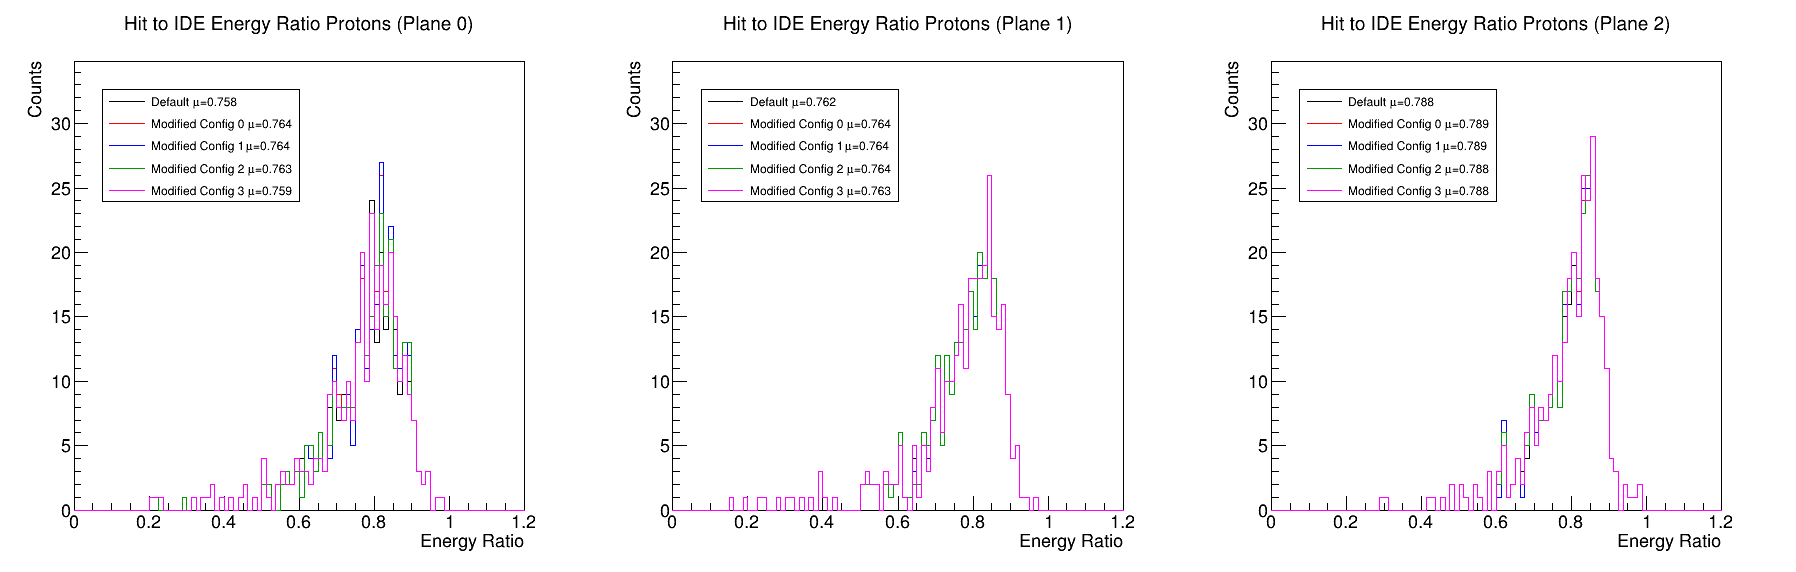

In [167]:
plotName = "Protons/h_energyRatio_p_plane"
particle = "Protons"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Modified Config 0', 'Modified Config 1', 'Modified Config 2', 'Modified Config 3']
hists = [[] for _ in range(3)]

for f in files:
    hists[0].append(f.Get(f"{plotName}0"))
    hists[1].append(f.Get(f"{plotName}1"))
    hists[2].append(f.Get(f"{plotName}2"))

maxY = np.zeros(len(hists[0]))
for hset in hists:
    for i in range(len(hset)):
        if hset[i].GetMaximum() > maxY[i]:
            maxY[i] = hset[i].GetMaximum()

legends = [r.TLegend(0.15, 0.65, 0.50, 0.85) for _ in range(3)]

for ic, hset in enumerate(hists):
    print(hset)
    c1.cd(ic+1)
    for i in range(len(hset)):
        hset[i].SetLineColor(colors[i])
        if i == 0:
            hset[i].GetYaxis().SetRangeUser(0, maxY[i]*1.2)
            hset[i].GetXaxis().SetRangeUser(0, 1.2)
            hset[i].SetTitle(f"Hit to IDE Energy Ratio {particle} (Plane {ic});Energy Ratio;Counts")
            hset[i].Draw("hist")
        else:
            hset[i].Draw("hist same")
        legends[ic].AddEntry(hset[i], f'{labels[i]} #mu={hset[i].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

[<cppyy.gbl.TH1F object at 0xdc0d160>, <cppyy.gbl.TH1F object at 0x103ee920>, <cppyy.gbl.TH1F object at 0x10288cf0>, <cppyy.gbl.TH1F object at 0x103d9460>, <cppyy.gbl.TH1F object at 0x1029d2b0>]
[<cppyy.gbl.TH1F object at 0xff237a0>, <cppyy.gbl.TH1F object at 0x10284ad0>, <cppyy.gbl.TH1F object at 0x103d3d90>, <cppyy.gbl.TH1F object at 0x103dad40>, <cppyy.gbl.TH1F object at 0x1029f720>]
[<cppyy.gbl.TH1F object at 0xff22e30>, <cppyy.gbl.TH1F object at 0x10285360>, <cppyy.gbl.TH1F object at 0x103d4590>, <cppyy.gbl.TH1F object at 0x1017b6f0>, <cppyy.gbl.TH1F object at 0x102a02a0>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


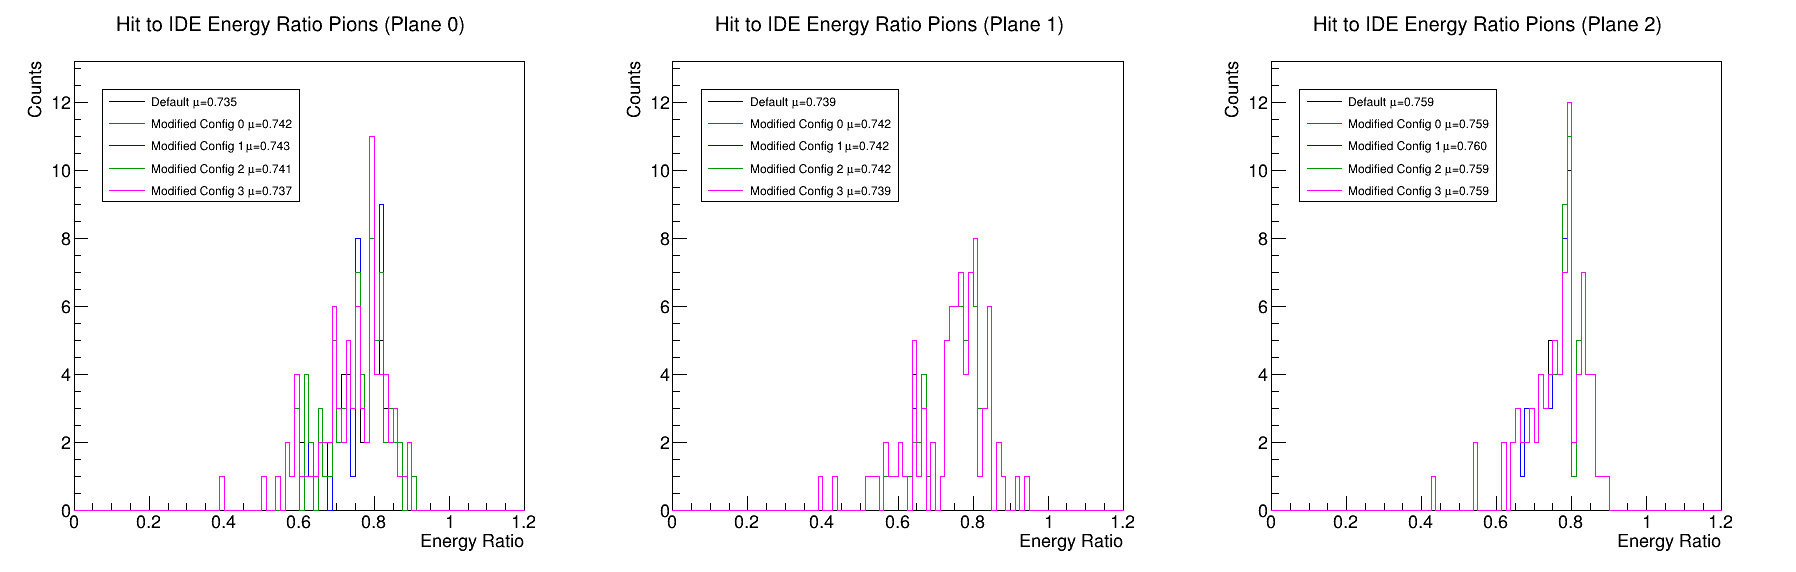

In [168]:
particle = 'Pions'
plotName = "Pions/h_energyRatio_pi_plane"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Modified Config 0', 'Modified Config 1', 'Modified Config 2', 'Modified Config 3']
hists = [[] for _ in range(3)]

for f in files:
    hists[0].append(f.Get(f"{plotName}0"))
    hists[1].append(f.Get(f"{plotName}1"))
    hists[2].append(f.Get(f"{plotName}2"))

maxY = np.zeros(len(hists[0]))
for hset in hists:
    for i in range(len(hset)):
        if hset[i].GetMaximum() > maxY[i]:
            maxY[i] = hset[i].GetMaximum()

legends = [r.TLegend(0.15, 0.65, 0.50, 0.85) for _ in range(3)]

for ic, hset in enumerate(hists):
    print(hset)
    c1.cd(ic+1)
    for i in range(len(hset)):
        hset[i].SetLineColor(colors[i])
        if i == 0:
            hset[i].GetYaxis().SetRangeUser(0, maxY[i]*1.2)
            hset[i].GetXaxis().SetRangeUser(0, 1.2)
            hset[i].SetTitle(f"Hit to IDE Energy Ratio {particle} (Plane {ic});Energy Ratio;Counts")
            hset[i].Draw("hist")
        else:
            hset[i].Draw("hist same")
        legends[ic].AddEntry(hset[i], f'{labels[i]} #mu={hset[i].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

[<cppyy.gbl.TH1F object at 0x102a3ae0>, <cppyy.gbl.TH1F object at 0x102a0c60>, <cppyy.gbl.TH1F object at 0x1042a840>, <cppyy.gbl.TH1F object at 0xd72df10>, <cppyy.gbl.TH1F object at 0xd72e8f0>]
[<cppyy.gbl.TH1F object at 0x102a4850>, <cppyy.gbl.TH1F object at 0x102a1050>, <cppyy.gbl.TH1F object at 0xd72d4d0>, <cppyy.gbl.TH1F object at 0xd72e300>, <cppyy.gbl.TH1F object at 0xd727f80>]
[<cppyy.gbl.TH1F object at 0x1017cb80>, <cppyy.gbl.TH1F object at 0x1042a450>, <cppyy.gbl.TH1F object at 0xd72db20>, <cppyy.gbl.TH1F object at 0xd72efe0>, <cppyy.gbl.TH1F object at 0xd728750>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


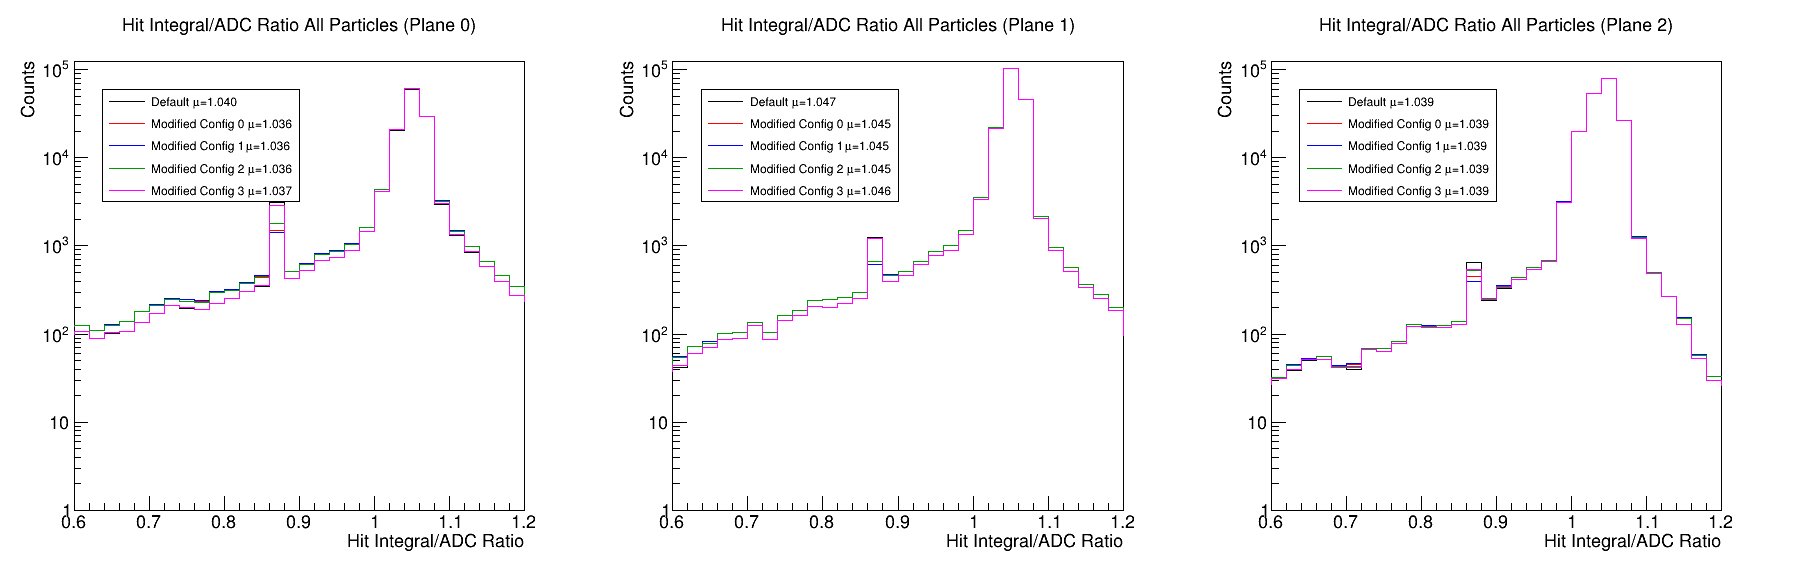

In [169]:
particle = 'All Particles'
plotName = "AllParticles/h_hitAreaRatio_plane"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Modified Config 0', 'Modified Config 1', 'Modified Config 2', 'Modified Config 3']
hists = [[] for _ in range(3)]

for f in files:
    hists[0].append(f.Get(f"{plotName}0"))
    hists[1].append(f.Get(f"{plotName}1"))
    hists[2].append(f.Get(f"{plotName}2"))

maxY = np.zeros(len(hists[0]))
for hset in hists:
    for i in range(len(hset)):
        if hset[i].GetMaximum() > maxY[i]:
            maxY[i] = hset[i].GetMaximum()

legends = [r.TLegend(0.15, 0.65, 0.50, 0.85) for _ in range(3)]

for ic, hset in enumerate(hists):
    print(hset)
    c1.cd(ic+1)
    r.gPad.SetLogy()
    for i in range(len(hset)):
        hset[i].SetLineColor(colors[i])
        if i == 0:
            hset[i].GetYaxis().SetRangeUser(1, maxY[i]*1.2)
            hset[i].GetXaxis().SetRangeUser(0.6, 1.2)
            hset[i].SetTitle(f"Hit Integral/ADC Ratio {particle} (Plane {ic});Hit Integral/ADC Ratio;Counts")
            hset[i].Draw("hist")
        else:
            hset[i].Draw("hist same")
        legends[ic].AddEntry(hset[i], f'{labels[i]} #mu={hset[i].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

[<cppyy.gbl.TH1F object at 0xd736080>, <cppyy.gbl.TH1F object at 0xd7292a0>, <cppyy.gbl.TH1F object at 0xd7341d0>, <cppyy.gbl.TH1F object at 0xd7ad690>, <cppyy.gbl.TH1F object at 0xd7abd00>]
[<cppyy.gbl.TH1F object at 0xd729e40>, <cppyy.gbl.TH1F object at 0xd733790>, <cppyy.gbl.TH1F object at 0xd7ac9f0>, <cppyy.gbl.TH1F object at 0xd7add20>, <cppyy.gbl.TH1F object at 0xd7ae110>]
[<cppyy.gbl.TH1F object at 0xd728eb0>, <cppyy.gbl.TH1F object at 0xd733b80>, <cppyy.gbl.TH1F object at 0xd7ad040>, <cppyy.gbl.TH1F object at 0xd7ab710>, <cppyy.gbl.TH1F object at 0xd7ae500>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


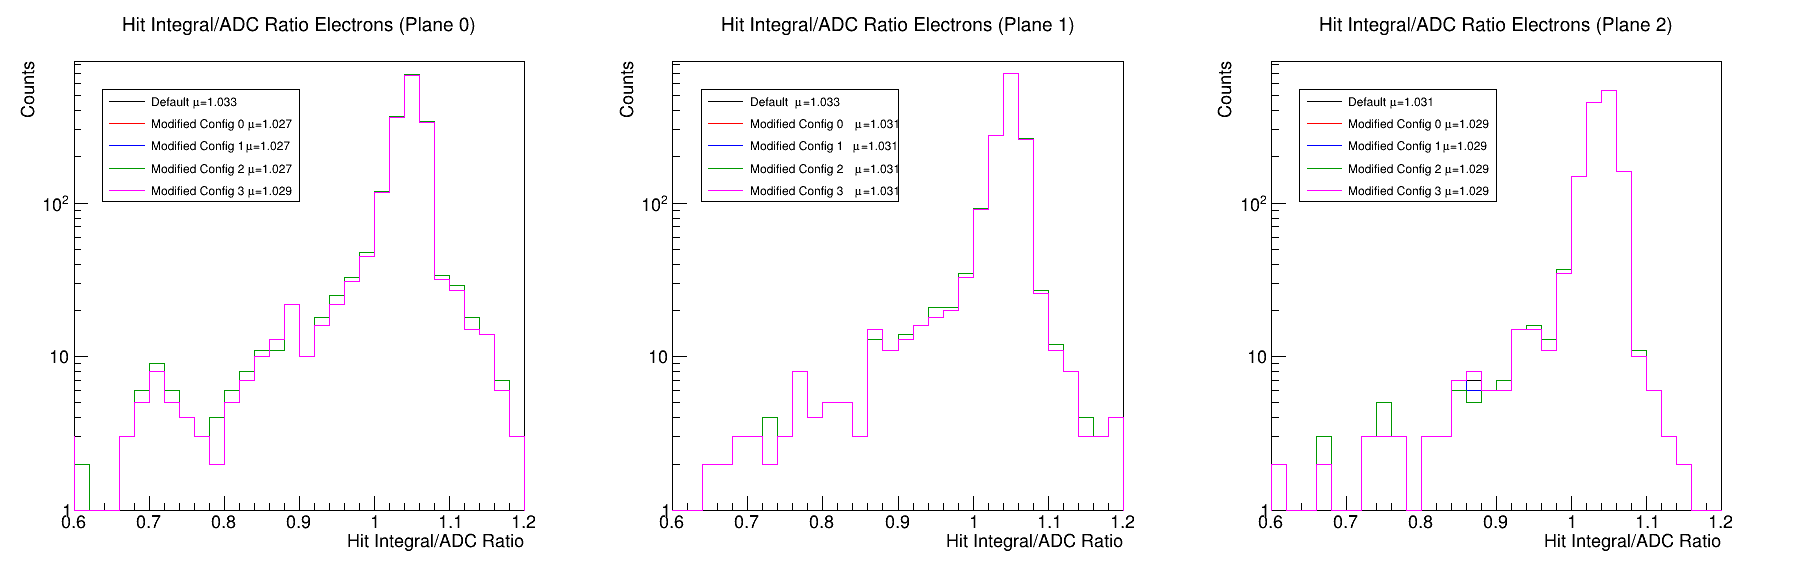

In [170]:
particle = 'Electrons'
plotName = "Electrons/h_hitAreaRatio_ele_plane"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Modified Config 0', 'Modified Config 1', 'Modified Config 2', 'Modified Config 3']
hists = [[] for _ in range(3)]

for f in files:
    hists[0].append(f.Get(f"{plotName}0"))
    hists[1].append(f.Get(f"{plotName}1"))
    hists[2].append(f.Get(f"{plotName}2"))

maxY = np.zeros(len(hists[0]))
for hset in hists:
    for i in range(len(hset)):
        if hset[i].GetMaximum() > maxY[i]:
            maxY[i] = hset[i].GetMaximum()

legends = [r.TLegend(0.15, 0.65, 0.50, 0.85) for _ in range(3)]

for ic, hset in enumerate(hists):
    print(hset)
    c1.cd(ic+1)
    r.gPad.SetLogy()
    for i in range(len(hset)):
        hset[i].SetLineColor(colors[i])
        if i == 0:
            hset[i].GetYaxis().SetRangeUser(1, maxY[i]*1.2)
            hset[i].GetXaxis().SetRangeUser(0.6, 1.2)
            hset[i].SetTitle(f"Hit Integral/ADC Ratio {particle} (Plane {ic});Hit Integral/ADC Ratio;Counts")
            hset[i].Draw("hist")
        else:
            hset[i].Draw("hist same")
        legends[ic].AddEntry(hset[i], f'{labels[i]} #mu={hset[i].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

[<cppyy.gbl.TH1F object at 0xd7a9ee0>, <cppyy.gbl.TH1F object at 0xd805620>, <cppyy.gbl.TH1F object at 0xd7a8970>, <cppyy.gbl.TH1F object at 0xd835240>, <cppyy.gbl.TH1F object at 0xd836010>]
[<cppyy.gbl.TH1F object at 0xd72b4d0>, <cppyy.gbl.TH1F object at 0xd82fcd0>, <cppyy.gbl.TH1F object at 0xd7aa7a0>, <cppyy.gbl.TH1F object at 0xd835830>, <cppyy.gbl.TH1F object at 0xd8366a0>]
[<cppyy.gbl.TH1F object at 0xd7b69b0>, <cppyy.gbl.TH1F object at 0xd7a8580>, <cppyy.gbl.TH1F object at 0xd7aab90>, <cppyy.gbl.TH1F object at 0xd835c20>, <cppyy.gbl.TH1F object at 0xd836ee0>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


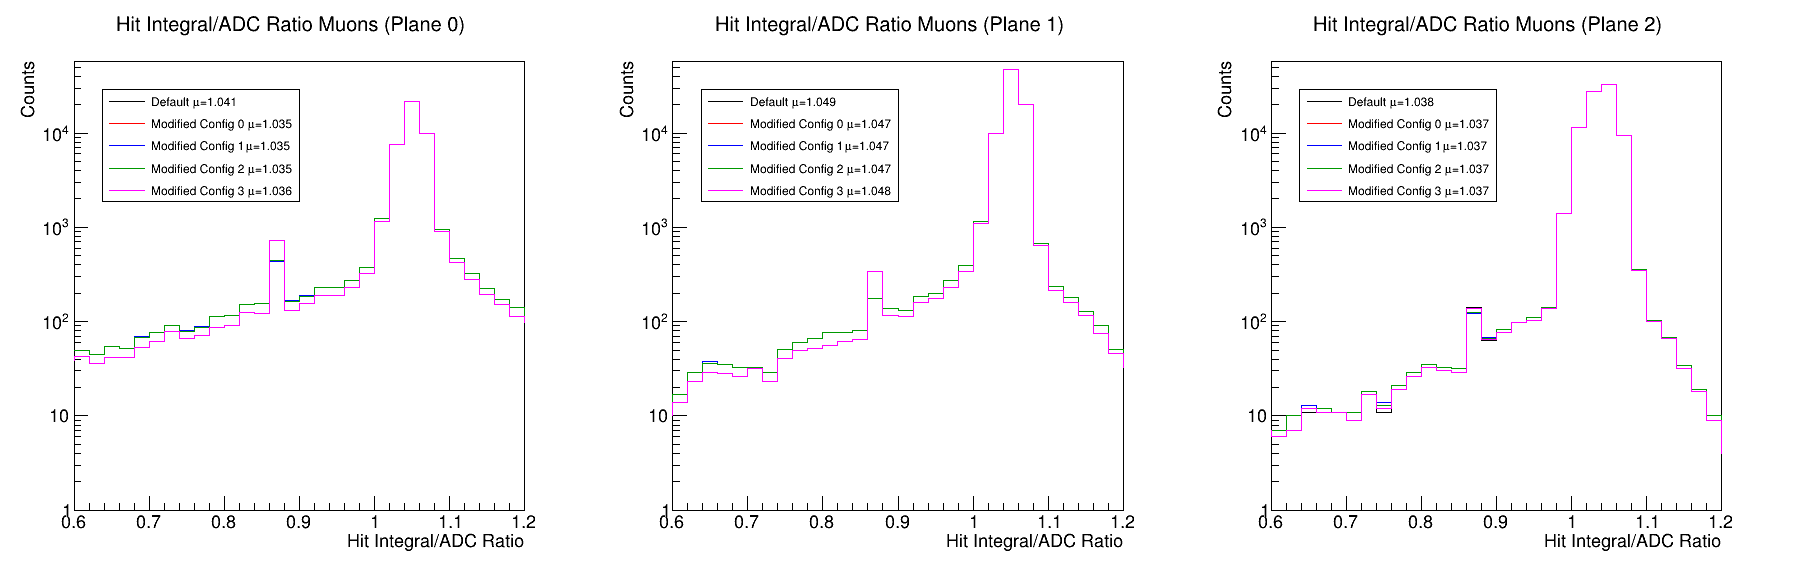

In [171]:
particle = 'Muons'
plotName = "Muons/h_hitAreaRatio_mu_plane"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Modified Config 0', 'Modified Config 1', 'Modified Config 2', 'Modified Config 3']
hists = [[] for _ in range(3)]

for f in files:
    hists[0].append(f.Get(f"{plotName}0"))
    hists[1].append(f.Get(f"{plotName}1"))
    hists[2].append(f.Get(f"{plotName}2"))

maxY = np.zeros(len(hists[0]))
for hset in hists:
    for i in range(len(hset)):
        if hset[i].GetMaximum() > maxY[i]:
            maxY[i] = hset[i].GetMaximum()

legends = [r.TLegend(0.15, 0.65, 0.50, 0.85) for _ in range(3)]

for ic, hset in enumerate(hists):
    print(hset)
    c1.cd(ic+1)
    r.gPad.SetLogy()
    for i in range(len(hset)):
        hset[i].SetLineColor(colors[i])
        if i == 0:
            hset[i].GetYaxis().SetRangeUser(1, maxY[i]*1.2)
            hset[i].GetXaxis().SetRangeUser(0.6, 1.2)
            hset[i].SetTitle(f"Hit Integral/ADC Ratio {particle} (Plane {ic});Hit Integral/ADC Ratio;Counts")
            hset[i].Draw("hist")
        else:
            hset[i].Draw("hist same")
        legends[ic].AddEntry(hset[i], f'{labels[i]} #mu={hset[i].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

[<cppyy.gbl.TH1F object at 0xd82d4c0>, <cppyy.gbl.TH1F object at 0xff270f0>, <cppyy.gbl.TH1F object at 0xd834470>, <cppyy.gbl.TH1F object at 0xd82e230>, <cppyy.gbl.TH1F object at 0xd8ac6e0>]
[<cppyy.gbl.TH1F object at 0xd8a5020>, <cppyy.gbl.TH1F object at 0xd82e9e0>, <cppyy.gbl.TH1F object at 0xd834860>, <cppyy.gbl.TH1F object at 0xd8aba60>, <cppyy.gbl.TH1F object at 0xd8acd50>]
[<cppyy.gbl.TH1F object at 0xd82bb50>, <cppyy.gbl.TH1F object at 0xd82edd0>, <cppyy.gbl.TH1F object at 0xd82de40>, <cppyy.gbl.TH1F object at 0xd8ac0f0>, <cppyy.gbl.TH1F object at 0xd8a5b30>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


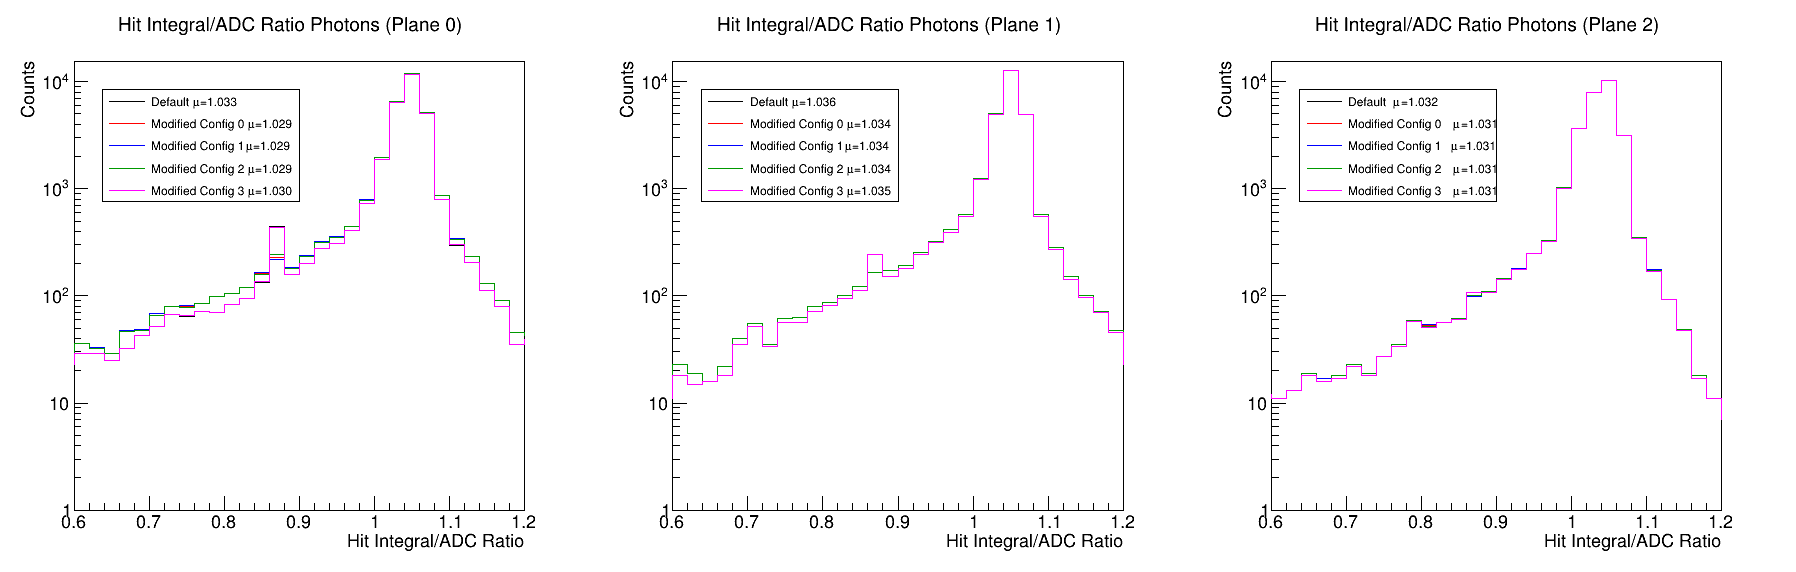

In [172]:
particle = 'Photons'
plotName = "Photons/h_hitAreaRatio_gamma_plane"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Modified Config 0', 'Modified Config 1', 'Modified Config 2', 'Modified Config 3']
hists = [[] for _ in range(3)]

for f in files:
    hists[0].append(f.Get(f"{plotName}0"))
    hists[1].append(f.Get(f"{plotName}1"))
    hists[2].append(f.Get(f"{plotName}2"))

maxY = np.zeros(len(hists[0]))
for hset in hists:
    for i in range(len(hset)):
        if hset[i].GetMaximum() > maxY[i]:
            maxY[i] = hset[i].GetMaximum()

legends = [r.TLegend(0.15, 0.65, 0.50, 0.85) for _ in range(3)]

for ic, hset in enumerate(hists):
    print(hset)
    c1.cd(ic+1)
    r.gPad.SetLogy()
    for i in range(len(hset)):
        hset[i].SetLineColor(colors[i])
        if i == 0:
            hset[i].GetYaxis().SetRangeUser(1, maxY[i]*1.2)
            hset[i].GetXaxis().SetRangeUser(0.6, 1.2)
            hset[i].SetTitle(f"Hit Integral/ADC Ratio {particle} (Plane {ic});Hit Integral/ADC Ratio;Counts")
            hset[i].Draw("hist")
        else:
            hset[i].Draw("hist same")
        legends[ic].AddEntry(hset[i], f'{labels[i]} #mu={hset[i].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

[<cppyy.gbl.TH1F object at 0xd8b3720>, <cppyy.gbl.TH1F object at 0xd8b29d0>, <cppyy.gbl.TH1F object at 0xd8b1d40>, <cppyy.gbl.TH1F object at 0x10892560>, <cppyy.gbl.TH1F object at 0x108967a0>]
[<cppyy.gbl.TH1F object at 0xd8fbd60>, <cppyy.gbl.TH1F object at 0xd8dbdd0>, <cppyy.gbl.TH1F object at 0xd8b2130>, <cppyy.gbl.TH1F object at 0x10895ae0>, <cppyy.gbl.TH1F object at 0x10896df0>]
[<cppyy.gbl.TH1F object at 0xd8fc150>, <cppyy.gbl.TH1F object at 0xd8dc1c0>, <cppyy.gbl.TH1F object at 0x10892170>, <cppyy.gbl.TH1F object at 0x10896170>, <cppyy.gbl.TH1F object at 0x108973e0>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


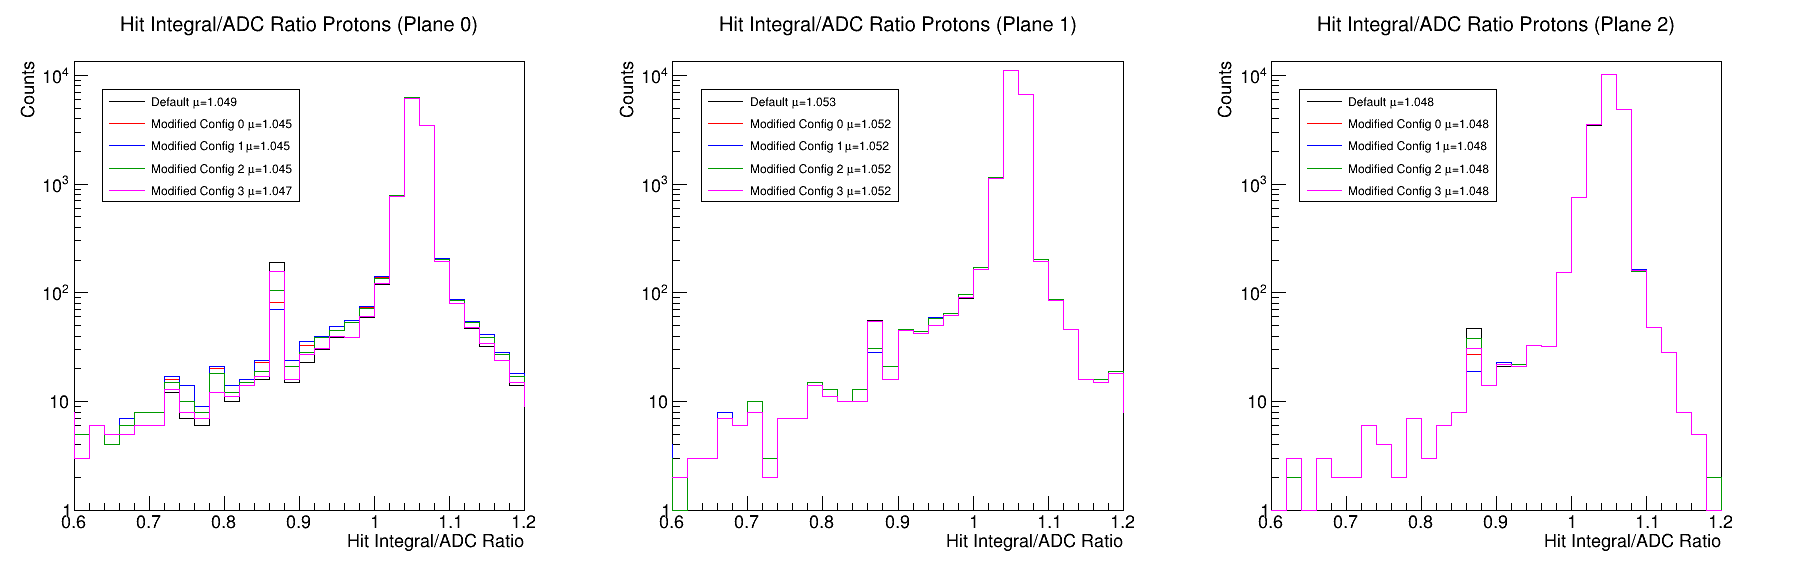

In [173]:
particle = 'Protons'
plotName = "Protons/h_hitAreaRatio_p_plane"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Modified Config 0', 'Modified Config 1', 'Modified Config 2', 'Modified Config 3']
hists = [[] for _ in range(3)]

for f in files:
    hists[0].append(f.Get(f"{plotName}0"))
    hists[1].append(f.Get(f"{plotName}1"))
    hists[2].append(f.Get(f"{plotName}2"))

maxY = np.zeros(len(hists[0]))
for hset in hists:
    for i in range(len(hset)):
        if hset[i].GetMaximum() > maxY[i]:
            maxY[i] = hset[i].GetMaximum()

legends = [r.TLegend(0.15, 0.65, 0.50, 0.85) for _ in range(3)]

for ic, hset in enumerate(hists):
    print(hset)
    c1.cd(ic+1)
    r.gPad.SetLogy()
    for i in range(len(hset)):
        hset[i].SetLineColor(colors[i])
        if i == 0:
            hset[i].GetYaxis().SetRangeUser(1, maxY[i]*1.2)
            hset[i].GetXaxis().SetRangeUser(0.6, 1.2)
            hset[i].SetTitle(f"Hit Integral/ADC Ratio {particle} (Plane {ic});Hit Integral/ADC Ratio;Counts")
            hset[i].Draw("hist")
        else:
            hset[i].Draw("hist same")
        legends[ic].AddEntry(hset[i], f'{labels[i]} #mu={hset[i].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

[<cppyy.gbl.TH1F object at 0x10894980>, <cppyy.gbl.TH1F object at 0x1088e3d0>, <cppyy.gbl.TH1F object at 0x10894510>, <cppyy.gbl.TH1F object at 0x109103a0>, <cppyy.gbl.TH1F object at 0x1090cfe0>]
[<cppyy.gbl.TH1F object at 0x10890570>, <cppyy.gbl.TH1F object at 0x10893ec0>, <cppyy.gbl.TH1F object at 0x10892bb0>, <cppyy.gbl.TH1F object at 0x109109f0>, <cppyy.gbl.TH1F object at 0x1090d690>]
[<cppyy.gbl.TH1F object at 0x1088dfe0>, <cppyy.gbl.TH1F object at 0x1090fac0>, <cppyy.gbl.TH1F object at 0x108931a0>, <cppyy.gbl.TH1F object at 0x10909a60>, <cppyy.gbl.TH1F object at 0x1090dd90>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


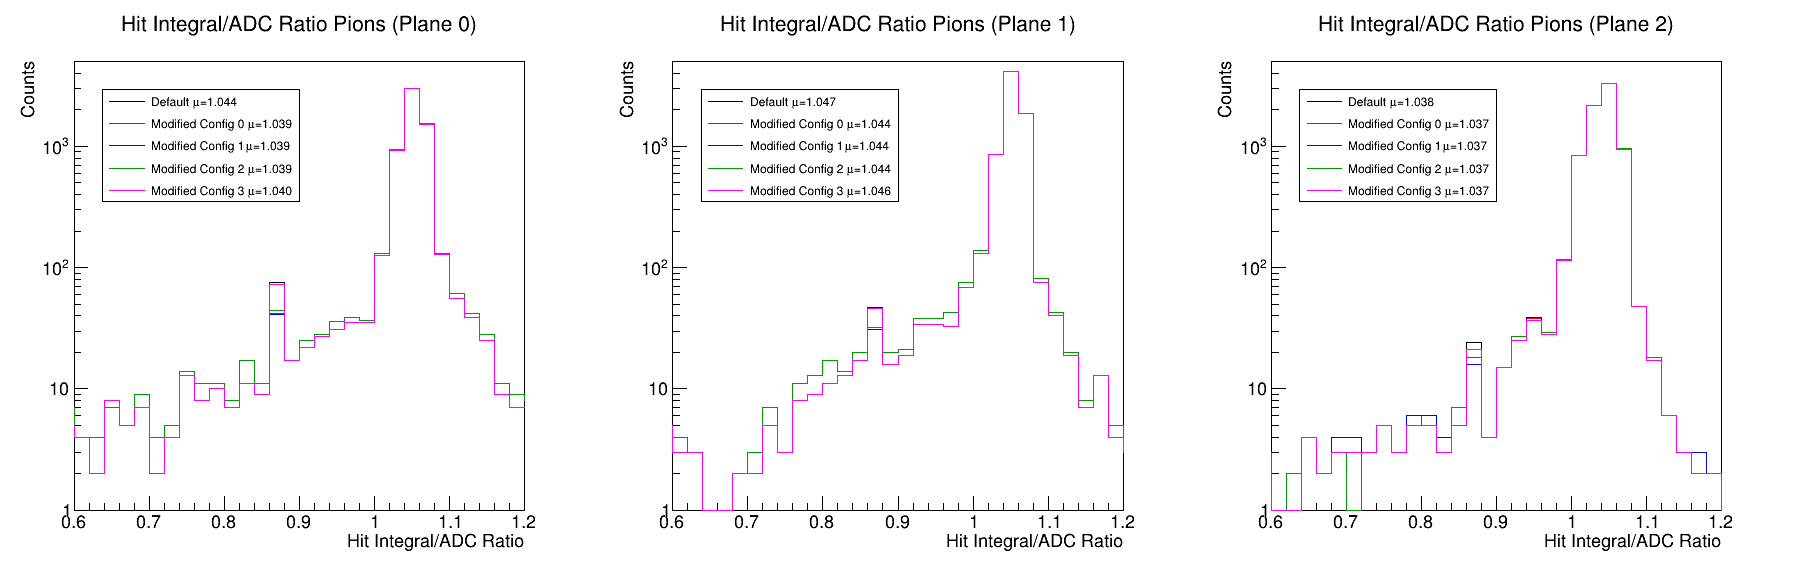

In [174]:
particle = 'Pions'
plotName = "Pions/h_hitAreaRatio_pi_plane"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Modified Config 0', 'Modified Config 1', 'Modified Config 2', 'Modified Config 3']
hists = [[] for _ in range(3)]

for f in files:
    hists[0].append(f.Get(f"{plotName}0"))
    hists[1].append(f.Get(f"{plotName}1"))
    hists[2].append(f.Get(f"{plotName}2"))

maxY = np.zeros(len(hists[0]))
for hset in hists:
    for i in range(len(hset)):
        if hset[i].GetMaximum() > maxY[i]:
            maxY[i] = hset[i].GetMaximum()

legends = [r.TLegend(0.15, 0.65, 0.50, 0.85) for _ in range(3)]

for ic, hset in enumerate(hists):
    print(hset)
    c1.cd(ic+1)
    r.gPad.SetLogy()
    for i in range(len(hset)):
        hset[i].SetLineColor(colors[i])
        if i == 0:
            hset[i].GetYaxis().SetRangeUser(1, maxY[i]*1.2)
            hset[i].GetXaxis().SetRangeUser(0.6, 1.2)
            hset[i].SetTitle(f"Hit Integral/ADC Ratio {particle} (Plane {ic});Hit Integral/ADC Ratio;Counts")
            hset[i].Draw("hist")
        else:
            hset[i].Draw("hist same")
        legends[ic].AddEntry(hset[i], f'{labels[i]} #mu={hset[i].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

[<cppyy.gbl.TH1F object at 0x103caeb0>, <cppyy.gbl.TH1F object at 0xd72df10>, <cppyy.gbl.TH1F object at 0xf805580>, <cppyy.gbl.TH1F object at 0x100f0d60>, <cppyy.gbl.TH1F object at 0x1000f1d0>]
[<cppyy.gbl.TH1F object at 0xd72efe0>, <cppyy.gbl.TH1F object at 0xdabf8a0>, <cppyy.gbl.TH1F object at 0xc9516f0>, <cppyy.gbl.TH1F object at 0x103caac0>, <cppyy.gbl.TH1F object at 0x102fe960>]
[<cppyy.gbl.TH1F object at 0xd72e300>, <cppyy.gbl.TH1F object at 0xc040b50>, <cppyy.gbl.TH1F object at 0xf7914e0>, <cppyy.gbl.TH1F object at 0x100f3490>, <cppyy.gbl.TH1F object at 0x10164e80>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


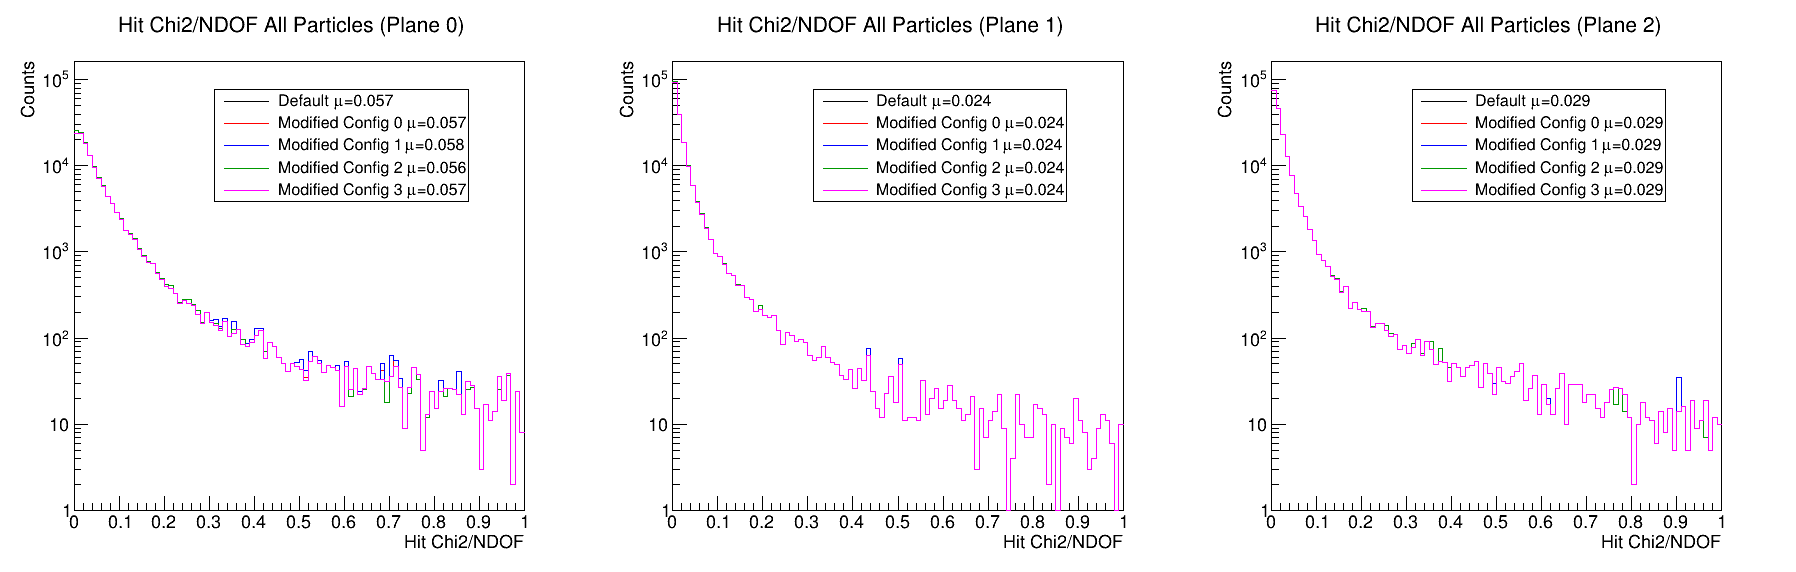

In [186]:
particle = 'All Particles'
plotName = "AllParticles/h_hitFit_plane"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Modified Config 0', 'Modified Config 1', 'Modified Config 2', 'Modified Config 3']
hists = [[] for _ in range(3)]

for f in files:
    hists[0].append(f.Get(f"{plotName}0"))
    hists[1].append(f.Get(f"{plotName}1"))
    hists[2].append(f.Get(f"{plotName}2"))

maxY = np.zeros(len(hists[0]))
for hset in hists:
    for i in range(len(hset)):
        if hset[i].GetMaximum() > maxY[i]:
            maxY[i] = hset[i].GetMaximum()

legends = [r.TLegend(0.35, 0.65, 0.80, 0.85) for _ in range(3)]

for ic, hset in enumerate(hists):
    print(hset)
    c1.cd(ic+1)
    r.gPad.SetLogy()
    for i in range(len(hset)):
        hset[i].SetLineColor(colors[i])
        if i == 0:
            hset[i].GetYaxis().SetRangeUser(1, maxY[i]*1.2)
            #hset[i].GetXaxis().SetRangeUser(0.6, 1.2)
            hset[i].SetTitle(f"Hit Chi2/NDOF {particle} (Plane {ic});Hit Chi2/NDOF;Counts")
            hset[i].Draw("hist")
        else:
            hset[i].Draw("hist same")
        legends[ic].AddEntry(hset[i], f'{labels[i]} #mu={hset[i].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

[<cppyy.gbl.TH1F object at 0xc426cd0>, <cppyy.gbl.TH1F object at 0x1088f1a0>, <cppyy.gbl.TH1F object at 0xf81b090>, <cppyy.gbl.TH1F object at 0x102675d0>, <cppyy.gbl.TH1F object at 0xc38faa0>]
[<cppyy.gbl.TH1F object at 0xda96930>, <cppyy.gbl.TH1F object at 0xf82f240>, <cppyy.gbl.TH1F object at 0xc91a5e0>, <cppyy.gbl.TH1F object at 0xc915e00>, <cppyy.gbl.TH1F object at 0xf7860d0>]
[<cppyy.gbl.TH1F object at 0xc6d3b20>, <cppyy.gbl.TH1F object at 0xdad4280>, <cppyy.gbl.TH1F object at 0xde07aa0>, <cppyy.gbl.TH1F object at 0xc3de050>, <cppyy.gbl.TH1F object at 0x100f5b50>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


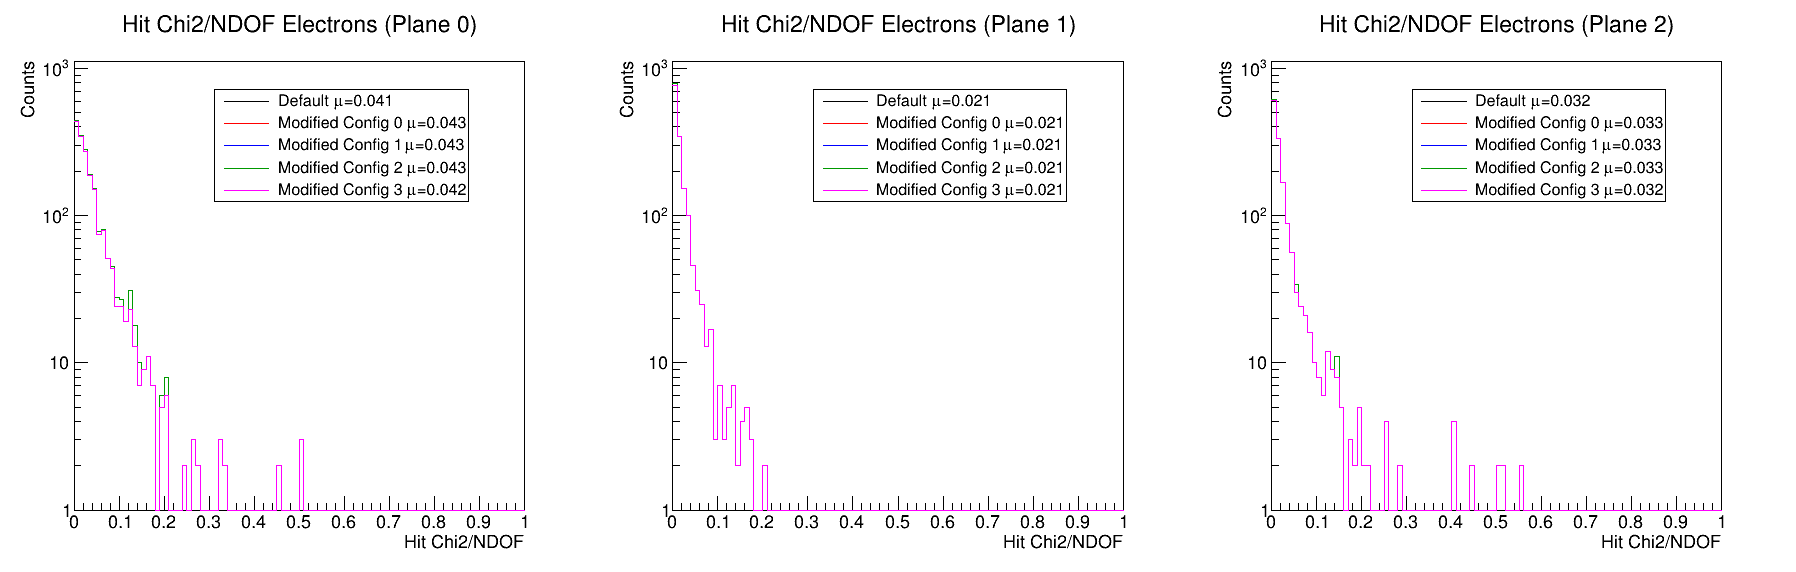

In [187]:
particle = 'Electrons'
plotName = "Electrons/h_hitFit_ele_plane"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Modified Config 0', 'Modified Config 1', 'Modified Config 2', 'Modified Config 3']
hists = [[] for _ in range(3)]

for f in files:
    hists[0].append(f.Get(f"{plotName}0"))
    hists[1].append(f.Get(f"{plotName}1"))
    hists[2].append(f.Get(f"{plotName}2"))

maxY = np.zeros(len(hists[0]))
for hset in hists:
    for i in range(len(hset)):
        if hset[i].GetMaximum() > maxY[i]:
            maxY[i] = hset[i].GetMaximum()

legends = [r.TLegend(0.35, 0.65, 0.80, 0.85) for _ in range(3)]

for ic, hset in enumerate(hists):
    print(hset)
    c1.cd(ic+1)
    r.gPad.SetLogy()
    for i in range(len(hset)):
        hset[i].SetLineColor(colors[i])
        if i == 0:
            hset[i].GetYaxis().SetRangeUser(1, maxY[i]*1.2)
            #hset[i].GetXaxis().SetRangeUser(0.6, 1.2)
            hset[i].SetTitle(f"Hit Chi2/NDOF {particle} (Plane {ic});Hit Chi2/NDOF;Counts")
            hset[i].Draw("hist")
        else:
            hset[i].Draw("hist same")
        legends[ic].AddEntry(hset[i], f'{labels[i]} #mu={hset[i].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

[<cppyy.gbl.TH1F object at 0xf7f15c0>, <cppyy.gbl.TH1F object at 0x1039ec40>, <cppyy.gbl.TH1F object at 0x10391240>, <cppyy.gbl.TH1F object at 0xf80f470>, <cppyy.gbl.TH1F object at 0xfffd360>]
[<cppyy.gbl.TH1F object at 0xff41f70>, <cppyy.gbl.TH1F object at 0xda87960>, <cppyy.gbl.TH1F object at 0xfffd7d0>, <cppyy.gbl.TH1F object at 0xff39b90>, <cppyy.gbl.TH1F object at 0xff2a990>]
[<cppyy.gbl.TH1F object at 0xff46670>, <cppyy.gbl.TH1F object at 0x10383ae0>, <cppyy.gbl.TH1F object at 0x100f4fb0>, <cppyy.gbl.TH1F object at 0xff50310>, <cppyy.gbl.TH1F object at 0x100c0850>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


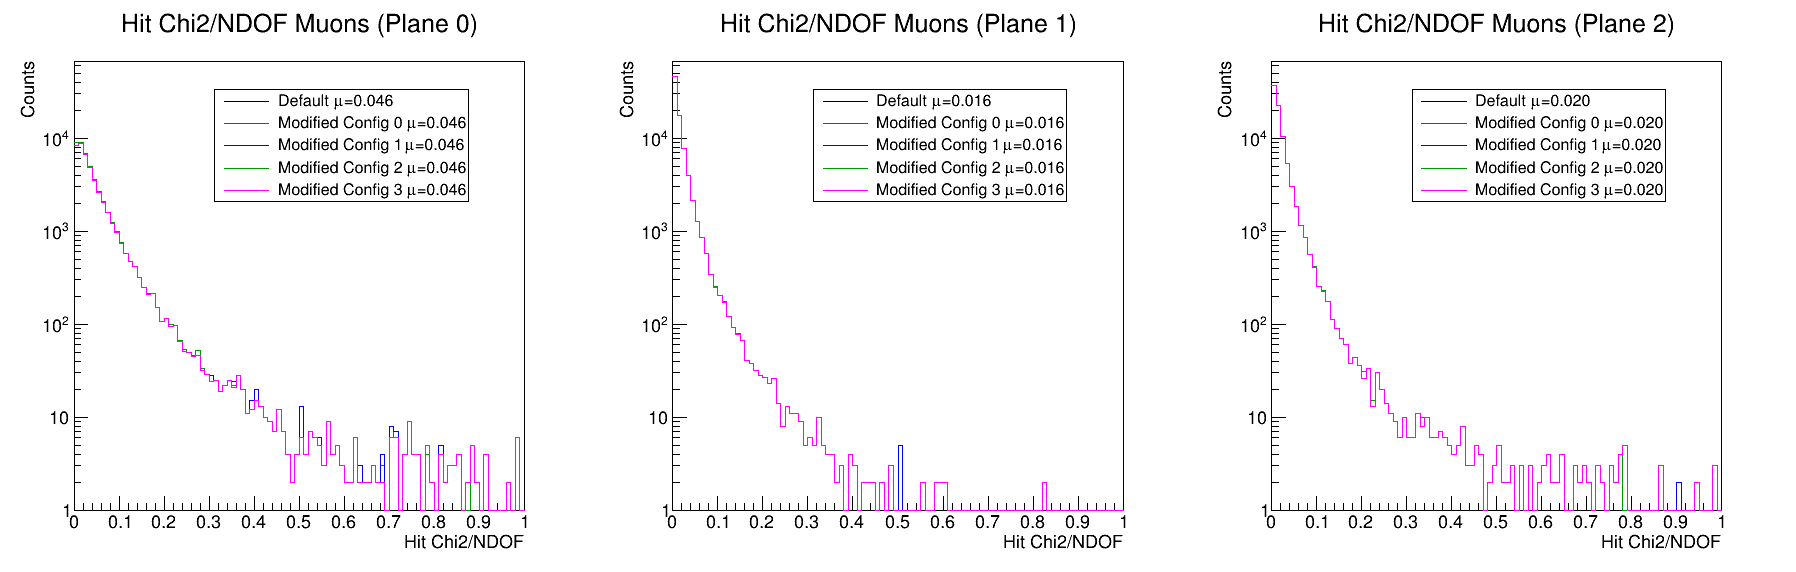

In [188]:
particle = 'Muons'
plotName = "Muons/h_hitFit_mu_plane"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Modified Config 0', 'Modified Config 1', 'Modified Config 2', 'Modified Config 3']
hists = [[] for _ in range(3)]

for f in files:
    hists[0].append(f.Get(f"{plotName}0"))
    hists[1].append(f.Get(f"{plotName}1"))
    hists[2].append(f.Get(f"{plotName}2"))

maxY = np.zeros(len(hists[0]))
for hset in hists:
    for i in range(len(hset)):
        if hset[i].GetMaximum() > maxY[i]:
            maxY[i] = hset[i].GetMaximum()

legends = [r.TLegend(0.35, 0.65, 0.80, 0.85) for _ in range(3)]

for ic, hset in enumerate(hists):
    print(hset)
    c1.cd(ic+1)
    r.gPad.SetLogy()
    for i in range(len(hset)):
        hset[i].SetLineColor(colors[i])
        if i == 0:
            hset[i].GetYaxis().SetRangeUser(1, maxY[i]*1.2)
            #hset[i].GetXaxis().SetRangeUser(0.6, 1.2)
            hset[i].SetTitle(f"Hit Chi2/NDOF {particle} (Plane {ic});Hit Chi2/NDOF;Counts")
            hset[i].Draw("hist")
        else:
            hset[i].Draw("hist same")
        legends[ic].AddEntry(hset[i], f'{labels[i]} #mu={hset[i].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

[<cppyy.gbl.TH1F object at 0x10384050>, <cppyy.gbl.TH1F object at 0xff37d40>, <cppyy.gbl.TH1F object at 0xf6c1df0>, <cppyy.gbl.TH1F object at 0x10890570>, <cppyy.gbl.TH1F object at 0x10391730>]
[<cppyy.gbl.TH1F object at 0xfebc980>, <cppyy.gbl.TH1F object at 0x1015d4b0>, <cppyy.gbl.TH1F object at 0x1016a1f0>, <cppyy.gbl.TH1F object at 0xfe7ef50>, <cppyy.gbl.TH1F object at 0x10a15270>]
[<cppyy.gbl.TH1F object at 0xdaba280>, <cppyy.gbl.TH1F object at 0x100f2ae0>, <cppyy.gbl.TH1F object at 0x1017ad30>, <cppyy.gbl.TH1F object at 0x1016e0a0>, <cppyy.gbl.TH1F object at 0x103860a0>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


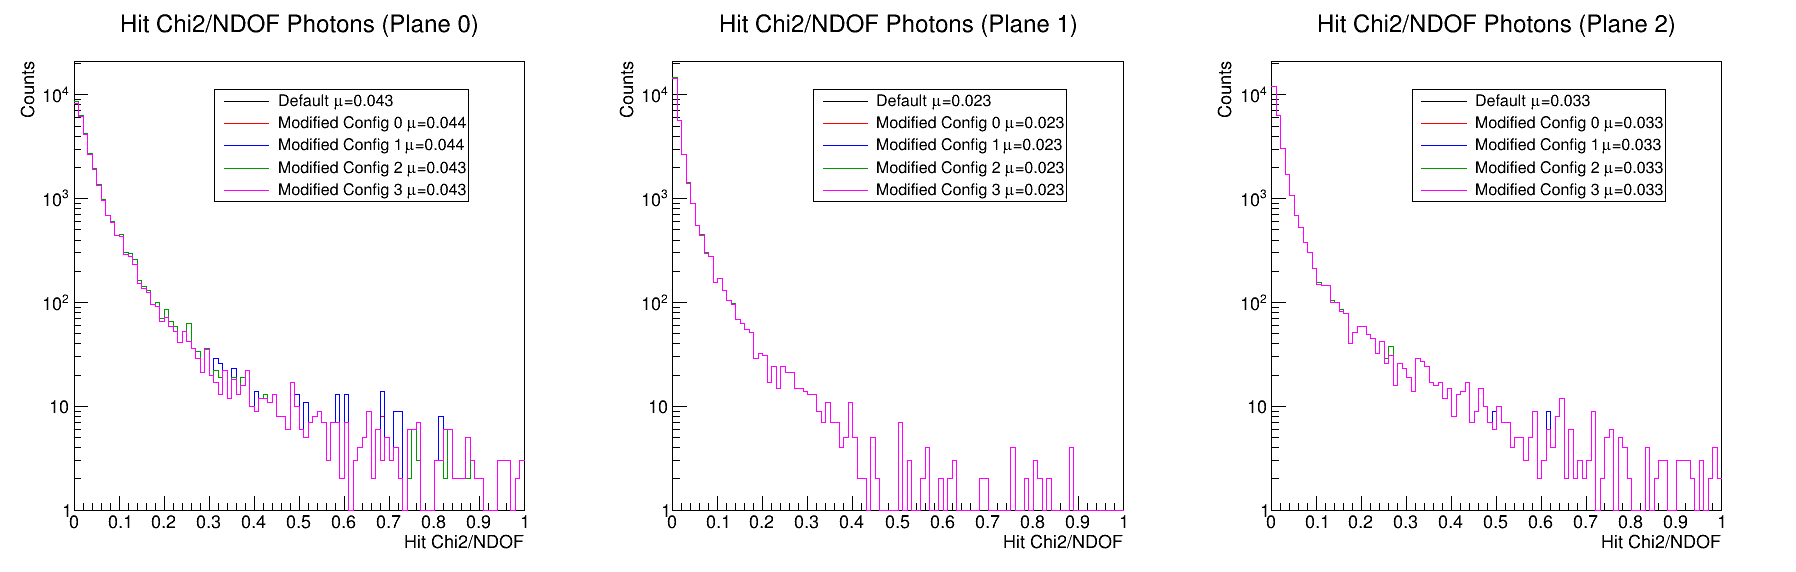

In [189]:
particle = 'Photons'
plotName = "Photons/h_hitFit_gamma_plane"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Modified Config 0', 'Modified Config 1', 'Modified Config 2', 'Modified Config 3']
hists = [[] for _ in range(3)]

for f in files:
    hists[0].append(f.Get(f"{plotName}0"))
    hists[1].append(f.Get(f"{plotName}1"))
    hists[2].append(f.Get(f"{plotName}2"))

maxY = np.zeros(len(hists[0]))
for hset in hists:
    for i in range(len(hset)):
        if hset[i].GetMaximum() > maxY[i]:
            maxY[i] = hset[i].GetMaximum()

legends = [r.TLegend(0.35, 0.65, 0.80, 0.85) for _ in range(3)]

for ic, hset in enumerate(hists):
    print(hset)
    c1.cd(ic+1)
    r.gPad.SetLogy()
    for i in range(len(hset)):
        hset[i].SetLineColor(colors[i])
        if i == 0:
            hset[i].GetYaxis().SetRangeUser(1, maxY[i]*1.2)
            #hset[i].GetXaxis().SetRangeUser(0.6, 1.2)
            hset[i].SetTitle(f"Hit Chi2/NDOF {particle} (Plane {ic});Hit Chi2/NDOF;Counts")
            hset[i].Draw("hist")
        else:
            hset[i].Draw("hist same")
        legends[ic].AddEntry(hset[i], f'{labels[i]} #mu={hset[i].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

[<cppyy.gbl.TH1F object at 0x101631f0>, <cppyy.gbl.TH1F object at 0xd8aa0f0>, <cppyy.gbl.TH1F object at 0xd7a9ee0>, <cppyy.gbl.TH1F object at 0x1039e0b0>, <cppyy.gbl.TH1F object at 0x102fe4e0>]
[<cppyy.gbl.TH1F object at 0xfe80d60>, <cppyy.gbl.TH1F object at 0x10386c10>, <cppyy.gbl.TH1F object at 0x1015efd0>, <cppyy.gbl.TH1F object at 0x100b7c10>, <cppyy.gbl.TH1F object at 0x10193fc0>]
[<cppyy.gbl.TH1F object at 0xd8fd9b0>, <cppyy.gbl.TH1F object at 0x102eb360>, <cppyy.gbl.TH1F object at 0x103d6fa0>, <cppyy.gbl.TH1F object at 0x10305fc0>, <cppyy.gbl.TH1F object at 0xffa5ac0>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


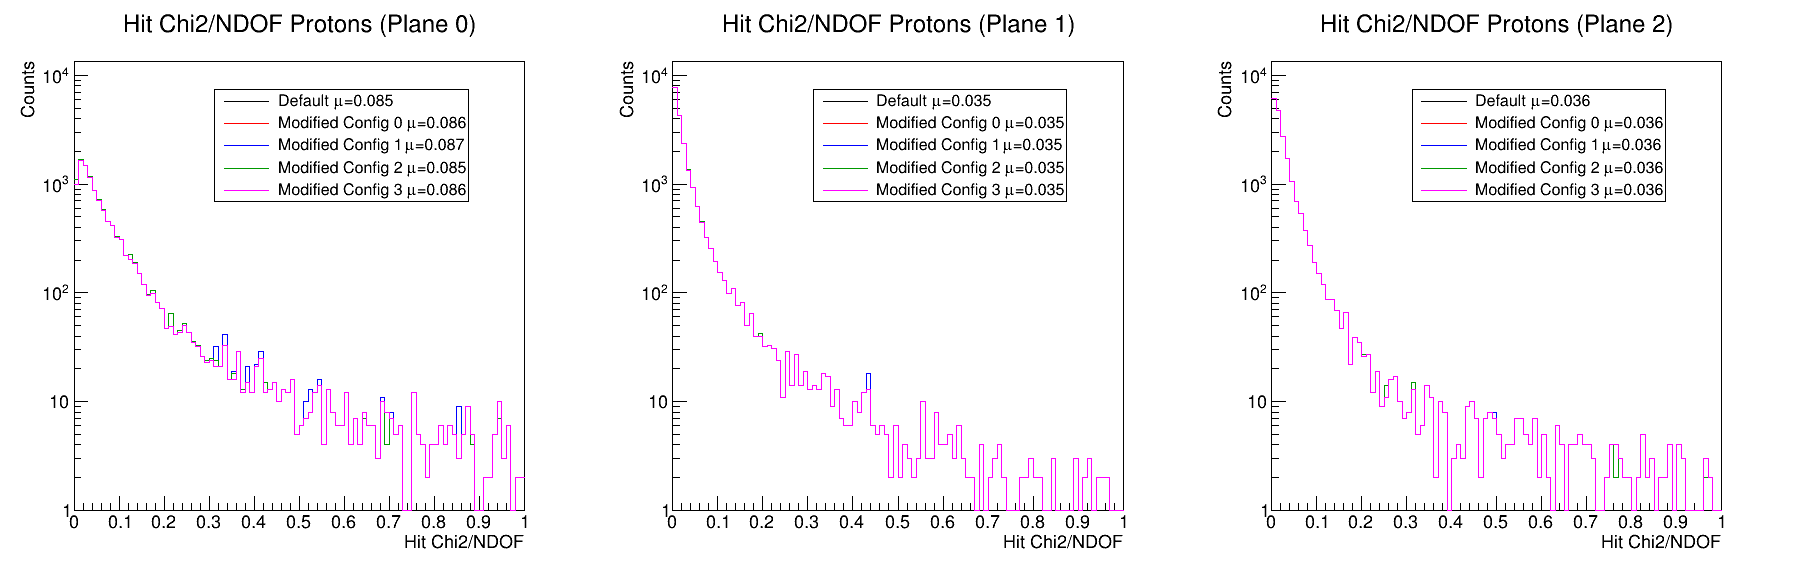

In [192]:
particle = 'Protons'
plotName = "Protons/h_hitFit_p_plane"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Modified Config 0', 'Modified Config 1', 'Modified Config 2', 'Modified Config 3']
hists = [[] for _ in range(3)]

for f in files:
    hists[0].append(f.Get(f"{plotName}0"))
    hists[1].append(f.Get(f"{plotName}1"))
    hists[2].append(f.Get(f"{plotName}2"))

maxY = np.zeros(len(hists[0]))
for hset in hists:
    for i in range(len(hset)):
        if hset[i].GetMaximum() > maxY[i]:
            maxY[i] = hset[i].GetMaximum()

legends = [r.TLegend(0.35, 0.65, 0.80, 0.85) for _ in range(3)]

for ic, hset in enumerate(hists):
    print(hset)
    c1.cd(ic+1)
    r.gPad.SetLogy()
    for i in range(len(hset)):
        hset[i].SetLineColor(colors[i])
        if i == 0:
            hset[i].GetYaxis().SetRangeUser(1, maxY[i]*1.2)
            #hset[i].GetXaxis().SetRangeUser(0.6, 1.2)
            hset[i].SetTitle(f"Hit Chi2/NDOF {particle} (Plane {ic});Hit Chi2/NDOF;Counts")
            hset[i].Draw("hist")
        else:
            hset[i].Draw("hist same")
        legends[ic].AddEntry(hset[i], f'{labels[i]} #mu={hset[i].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

[<cppyy.gbl.TH1F object at 0x1018f910>, <cppyy.gbl.TH1F object at 0xd8346d0>, <cppyy.gbl.TH1F object at 0x102f88f0>, <cppyy.gbl.TH1F object at 0xffff340>, <cppyy.gbl.TH1F object at 0x1018a150>]
[<cppyy.gbl.TH1F object at 0x10183860>, <cppyy.gbl.TH1F object at 0x100ba040>, <cppyy.gbl.TH1F object at 0x1026e220>, <cppyy.gbl.TH1F object at 0xd72d790>, <cppyy.gbl.TH1F object at 0xd7b68a0>]
[<cppyy.gbl.TH1F object at 0xd72e6f0>, <cppyy.gbl.TH1F object at 0x1015f7a0>, <cppyy.gbl.TH1F object at 0x102f1240>, <cppyy.gbl.TH1F object at 0x10267b20>, <cppyy.gbl.TH1F object at 0x10264890>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


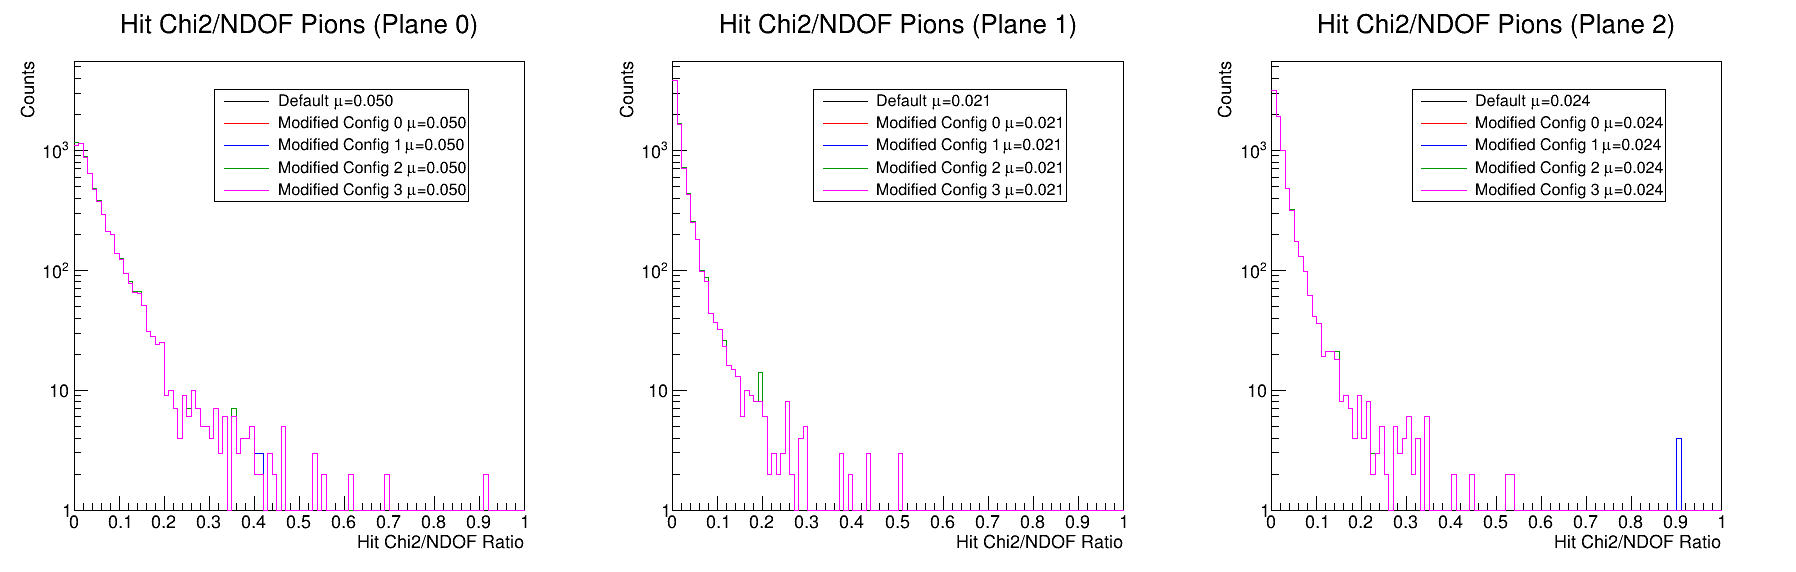

In [191]:
particle = 'Pions'
plotName = "Pions/h_hitFit_pi_plane"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Modified Config 0', 'Modified Config 1', 'Modified Config 2', 'Modified Config 3']
hists = [[] for _ in range(3)]

for f in files:
    hists[0].append(f.Get(f"{plotName}0"))
    hists[1].append(f.Get(f"{plotName}1"))
    hists[2].append(f.Get(f"{plotName}2"))

maxY = np.zeros(len(hists[0]))
for hset in hists:
    for i in range(len(hset)):
        if hset[i].GetMaximum() > maxY[i]:
            maxY[i] = hset[i].GetMaximum()

legends = [r.TLegend(0.35, 0.65, 0.80, 0.85) for _ in range(3)]

for ic, hset in enumerate(hists):
    print(hset)
    c1.cd(ic+1)
    r.gPad.SetLogy()
    for i in range(len(hset)):
        hset[i].SetLineColor(colors[i])
        if i == 0:
            hset[i].GetYaxis().SetRangeUser(1, maxY[i]*1.2)
            #hset[i].GetXaxis().SetRangeUser(0.6, 1.2)
            hset[i].SetTitle(f"Hit Chi2/NDOF {particle} (Plane {ic});Hit Chi2/NDOF Ratio;Counts")
            hset[i].Draw("hist")
        else:
            hset[i].Draw("hist same")
        legends[ic].AddEntry(hset[i], f'{labels[i]} #mu={hset[i].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

### Compare best of second grid search

In [82]:
# compare one of the best parameter sets to the default

f_default = r.TFile.Open('root://fndcadoor.fnal.gov://icarus/scratch/users/micarrig/hitTuning/mc/grid/outputs/00/hist_output_0.root', 'READ') #nominal
f_mod2 = r.TFile.Open('root://fndcadoor.fnal.gov://icarus/scratch/users/micarrig/hitTuning/mc/gridV2/outputs/00/hist_output_82.root', 'READ') # collection
f_mod1 = r.TFile.Open('root://fndcadoor.fnal.gov://icarus/scratch/users/micarrig/hitTuning/mc/gridV2/outputs/01/hist_output_100.root', 'READ') # induction 2
f_mod0 = r.TFile.Open('root://fndcadoor.fnal.gov://icarus/scratch/users/micarrig/hitTuning/mc/gridV2/outputs/01/hist_output_162.root', 'READ') # induction 1
files = [f_default, f_mod0, f_mod1, f_mod2]
labels = ['Default', 'Mod Set 0', 'Mod Set 1', 'Mod Set 2']
colors = [r.kBlack, r.kRed, r.kBlue, r.kGreen+2]

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


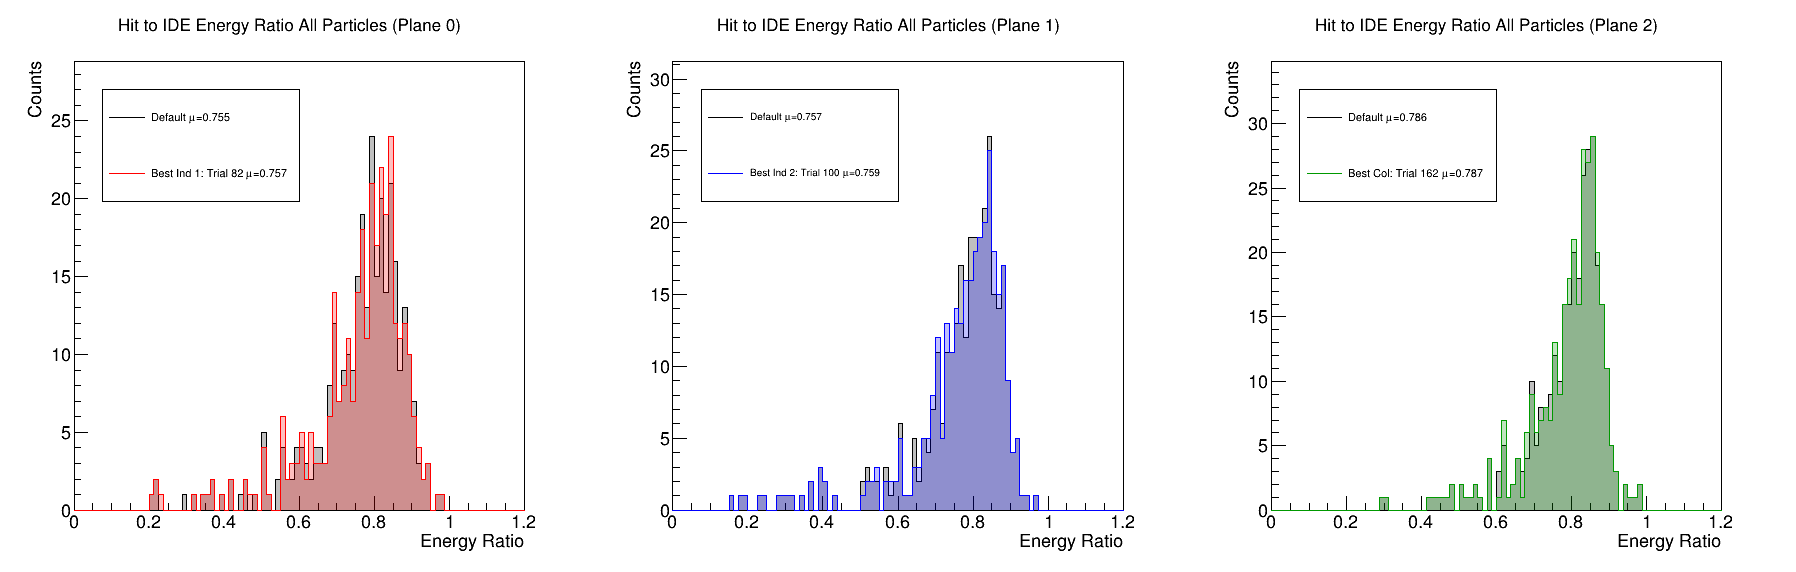

In [83]:
plotName = "AllParticles/h_energyRatio_plane"
particle = "All Particles"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Best Ind 1: Trial 82', 'Best Ind 2: Trial 100', 'Best Col: Trial 162']

h_nom0 = files[0].Get(f"{plotName}0")
h_nom1 = files[0].Get(f"{plotName}1")
h_nom2 = files[0].Get(f"{plotName}2")

h_nom = [h_nom0, h_nom1, h_nom2]

h_0 = f_mod0.Get(f"{plotName}0")
h_1 = f_mod1.Get(f"{plotName}1")
h_2 = f_mod2.Get(f"{plotName}2")

h_mod = [h_0, h_1, h_2]

legends = [r.TLegend(0.15, 0.65, 0.50, 0.85) for _ in range(3)]

for ic in range(3):
    c1.cd(ic+1)
    h_nom[ic].SetLineColor(r.kBlack)
    h_nom[ic].SetFillColorAlpha(r.kBlack, 0.25)
    h_mod[ic].SetFillColorAlpha(colors[ic+1], 0.25)

    h_nom[ic].SetTitle(f"Hit to IDE Energy Ratio {particle} (Plane {ic});Energy Ratio;Counts")
    maxY = max(h_nom[ic].GetMaximum(), h_mod[ic].GetMaximum())
    h_nom[ic].GetYaxis().SetRangeUser(0, maxY*1.2)
    h_nom[ic].GetXaxis().SetRangeUser(0, 1.2)
    h_nom[ic].Draw("hist")
    h_mod[ic].SetLineColor(colors[ic+1])
    h_mod[ic].Draw("hist same")
    legends[ic].AddEntry(h_nom[ic], f'{labels[0]} #mu={h_nom[ic].GetMean():.3f}', "l")
    legends[ic].AddEntry(h_mod[ic], f'{labels[ic+1]} #mu={h_mod[ic].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


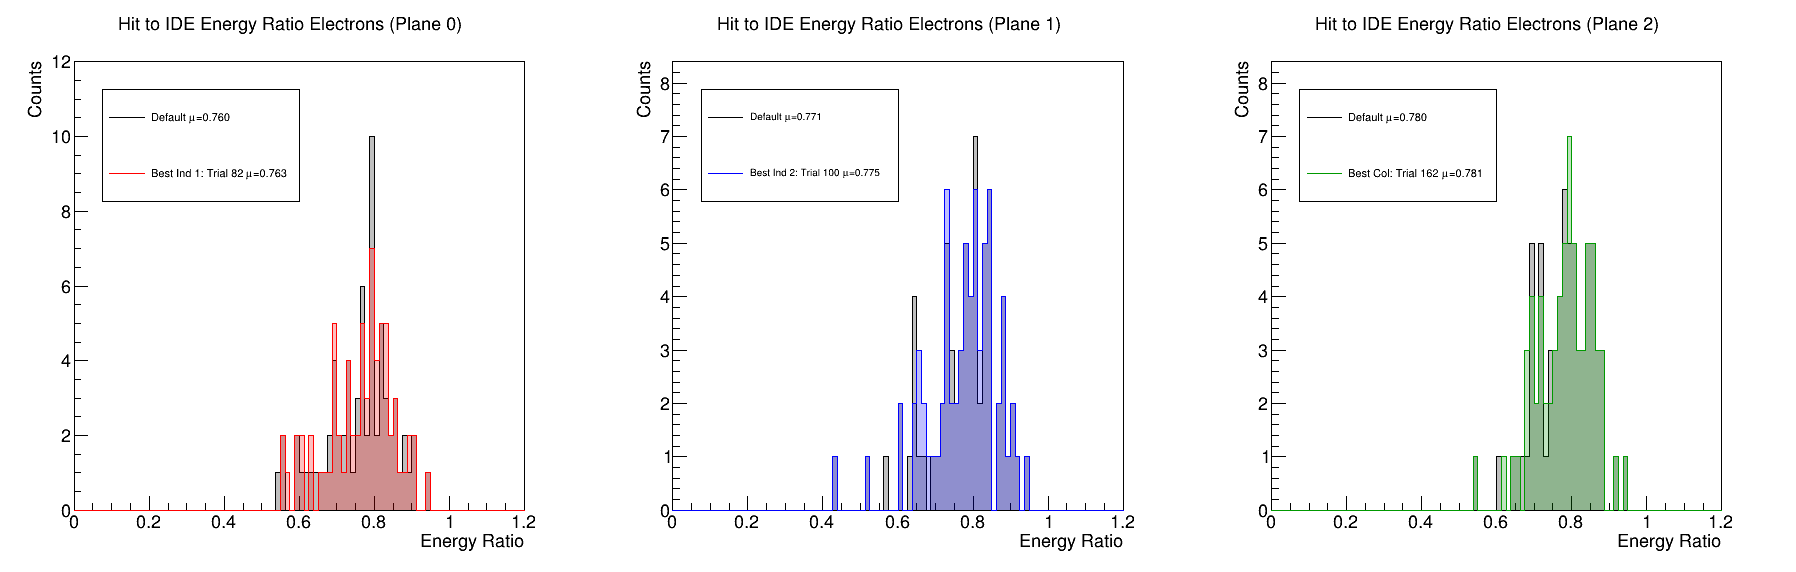

In [84]:
plotName = "Electrons/h_energyRatio_ele_plane"
particle = "Electrons"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Best Ind 1: Trial 82', 'Best Ind 2: Trial 100', 'Best Col: Trial 162']

h_nom0 = files[0].Get(f"{plotName}0")
h_nom1 = files[0].Get(f"{plotName}1")
h_nom2 = files[0].Get(f"{plotName}2")

h_nom = [h_nom0, h_nom1, h_nom2]

h_0 = f_mod0.Get(f"{plotName}0")
h_1 = f_mod1.Get(f"{plotName}1")
h_2 = f_mod2.Get(f"{plotName}2")

h_mod = [h_0, h_1, h_2]

legends = [r.TLegend(0.15, 0.65, 0.50, 0.85) for _ in range(3)]

for ic in range(3):
    c1.cd(ic+1)
    h_nom[ic].SetLineColor(r.kBlack)
    h_nom[ic].SetFillColorAlpha(r.kBlack, 0.25)
    h_mod[ic].SetFillColorAlpha(colors[ic+1], 0.25)
    h_nom[ic].SetTitle(f"Hit to IDE Energy Ratio {particle} (Plane {ic});Energy Ratio;Counts")
    maxY = max(h_nom[ic].GetMaximum(), h_mod[ic].GetMaximum())
    h_nom[ic].GetYaxis().SetRangeUser(0, maxY*1.2)
    h_nom[ic].GetXaxis().SetRangeUser(0, 1.2)
    h_nom[ic].Draw("hist")
    h_mod[ic].SetLineColor(colors[ic+1])
    h_mod[ic].Draw("hist same")
    legends[ic].AddEntry(h_nom[ic], f'{labels[0]} #mu={h_nom[ic].GetMean():.3f}', "l")
    legends[ic].AddEntry(h_mod[ic], f'{labels[ic+1]} #mu={h_mod[ic].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


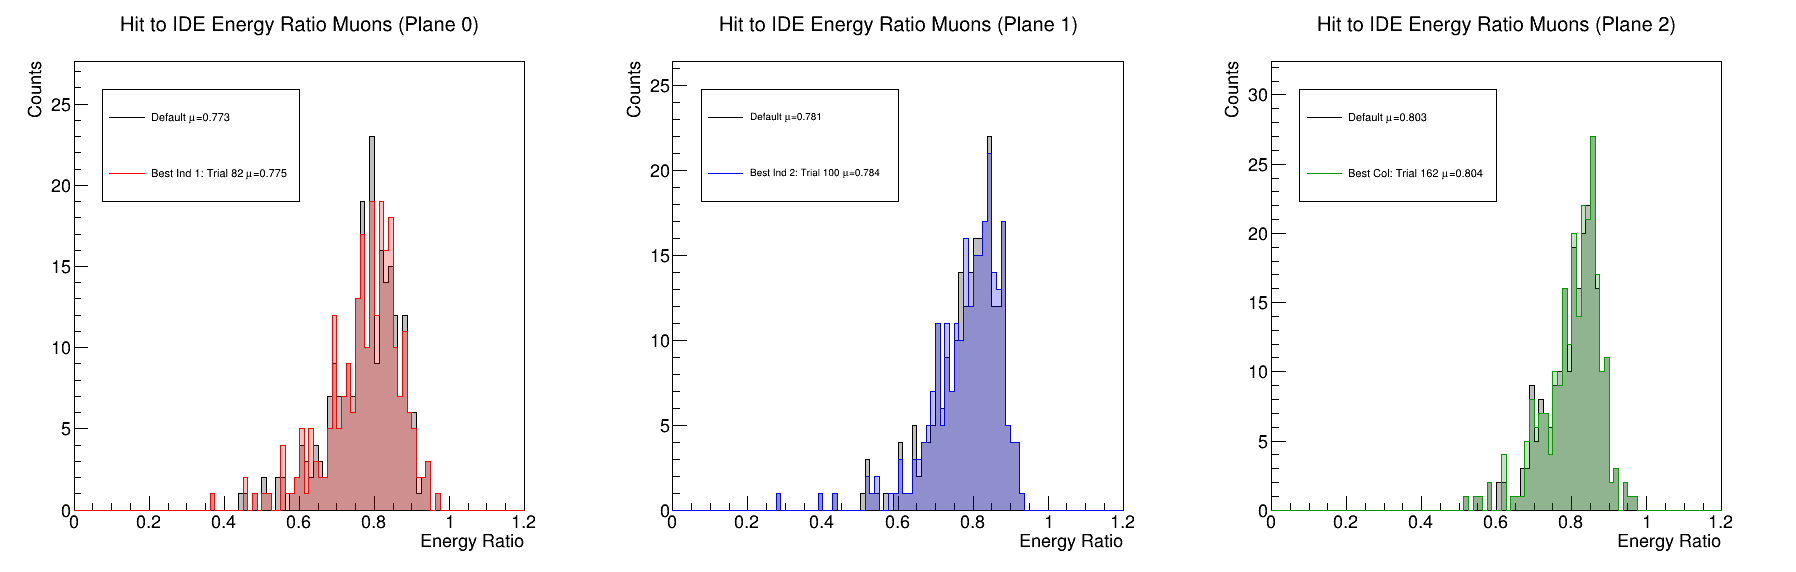

In [85]:
plotName = "Muons/h_energyRatio_mu_plane"
particle = "Muons"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Best Ind 1: Trial 82', 'Best Ind 2: Trial 100', 'Best Col: Trial 162']

h_nom0 = files[0].Get(f"{plotName}0")
h_nom1 = files[0].Get(f"{plotName}1")
h_nom2 = files[0].Get(f"{plotName}2")

h_nom = [h_nom0, h_nom1, h_nom2]

h_0 = f_mod0.Get(f"{plotName}0")
h_1 = f_mod1.Get(f"{plotName}1")
h_2 = f_mod2.Get(f"{plotName}2")

h_mod = [h_0, h_1, h_2]

legends = [r.TLegend(0.15, 0.65, 0.50, 0.85) for _ in range(3)]

for ic in range(3):
    c1.cd(ic+1)
    h_nom[ic].SetLineColor(r.kBlack)
    h_nom[ic].SetFillColorAlpha(r.kBlack, 0.25)
    h_mod[ic].SetFillColorAlpha(colors[ic+1], 0.25)
    h_nom[ic].SetTitle(f"Hit to IDE Energy Ratio {particle} (Plane {ic});Energy Ratio;Counts")
    maxY = max(h_nom[ic].GetMaximum(), h_mod[ic].GetMaximum())
    h_nom[ic].GetYaxis().SetRangeUser(0, maxY*1.2)
    h_nom[ic].GetXaxis().SetRangeUser(0, 1.2)
    h_nom[ic].Draw("hist")
    h_mod[ic].SetLineColor(colors[ic+1])
    h_mod[ic].Draw("hist same")
    legends[ic].AddEntry(h_nom[ic], f'{labels[0]} #mu={h_nom[ic].GetMean():.3f}', "l")
    legends[ic].AddEntry(h_mod[ic], f'{labels[ic+1]} #mu={h_mod[ic].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


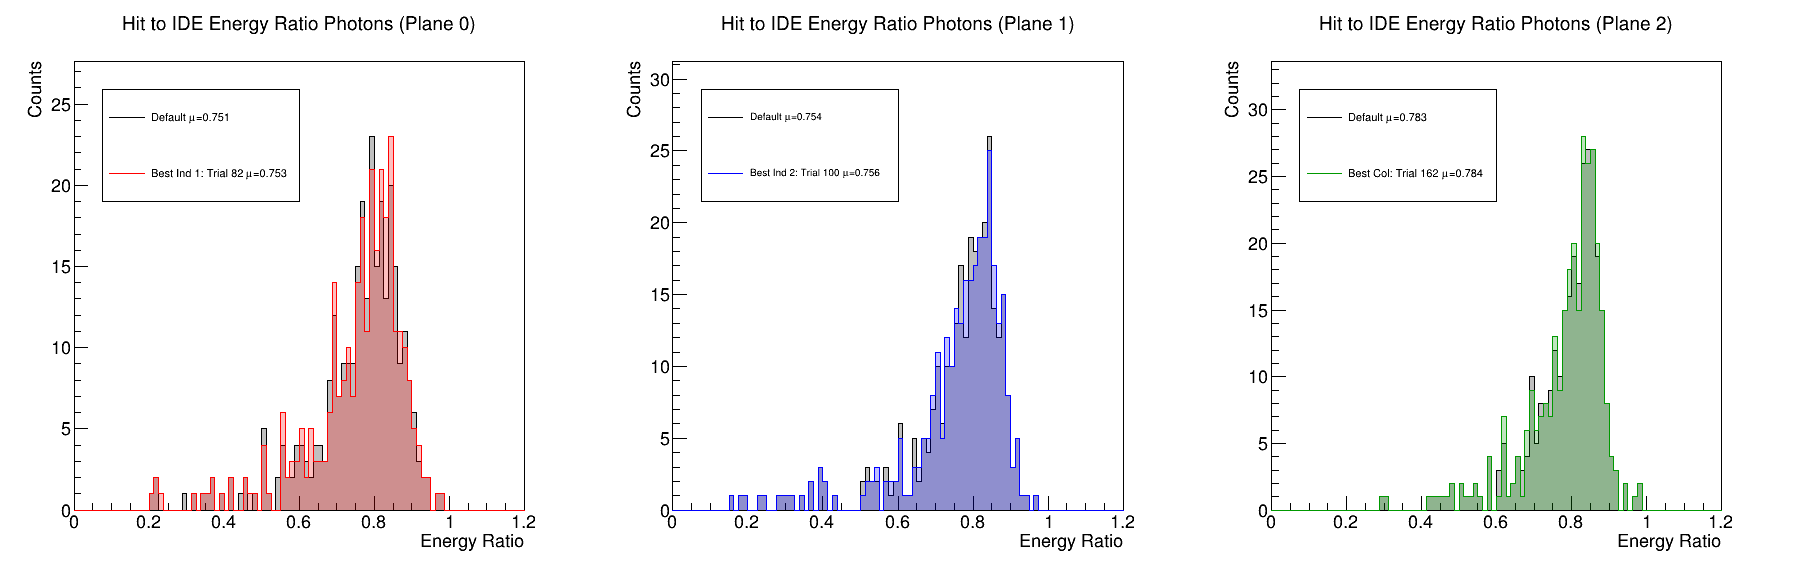

In [86]:
plotName = "Photons/h_energyRatio_gamma_plane"
particle = "Photons"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Best Ind 1: Trial 82', 'Best Ind 2: Trial 100', 'Best Col: Trial 162']

h_nom0 = files[0].Get(f"{plotName}0")
h_nom1 = files[0].Get(f"{plotName}1")
h_nom2 = files[0].Get(f"{plotName}2")

h_nom = [h_nom0, h_nom1, h_nom2]

h_0 = f_mod0.Get(f"{plotName}0")
h_1 = f_mod1.Get(f"{plotName}1")
h_2 = f_mod2.Get(f"{plotName}2")

h_mod = [h_0, h_1, h_2]

legends = [r.TLegend(0.15, 0.65, 0.50, 0.85) for _ in range(3)]

for ic in range(3):
    c1.cd(ic+1)
    h_nom[ic].SetLineColor(r.kBlack)
    h_nom[ic].SetFillColorAlpha(r.kBlack, 0.25)
    h_mod[ic].SetFillColorAlpha(colors[ic+1], 0.25)
    h_nom[ic].SetTitle(f"Hit to IDE Energy Ratio {particle} (Plane {ic});Energy Ratio;Counts")
    maxY = max(h_nom[ic].GetMaximum(), h_mod[ic].GetMaximum())
    h_nom[ic].GetYaxis().SetRangeUser(0, maxY*1.2)
    h_nom[ic].GetXaxis().SetRangeUser(0, 1.2)
    h_nom[ic].Draw("hist")
    h_mod[ic].SetLineColor(colors[ic+1])
    h_mod[ic].Draw("hist same")
    legends[ic].AddEntry(h_nom[ic], f'{labels[0]} #mu={h_nom[ic].GetMean():.3f}', "l")
    legends[ic].AddEntry(h_mod[ic], f'{labels[ic+1]} #mu={h_mod[ic].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


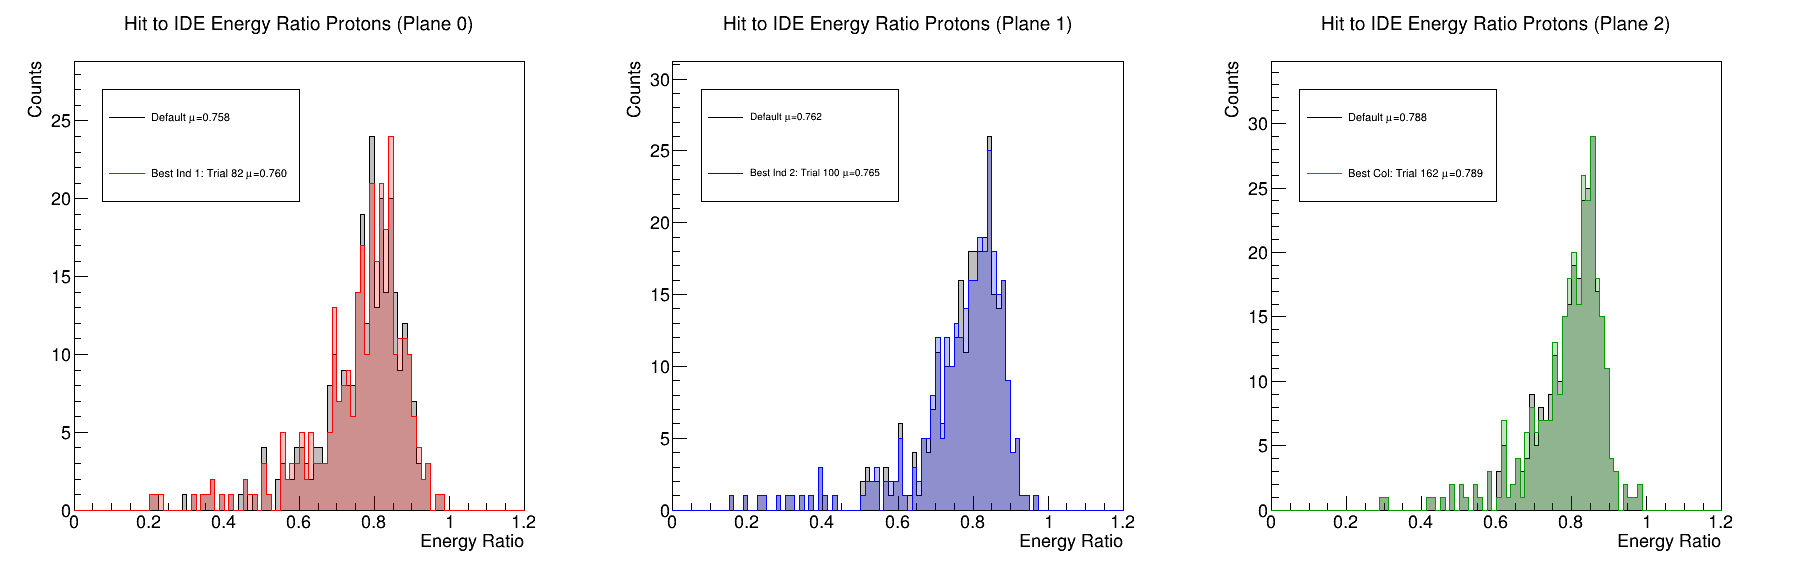

In [87]:
plotName = "Protons/h_energyRatio_p_plane"
particle = "Protons"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Best Ind 1: Trial 82', 'Best Ind 2: Trial 100', 'Best Col: Trial 162']

h_nom0 = files[0].Get(f"{plotName}0")
h_nom1 = files[0].Get(f"{plotName}1")
h_nom2 = files[0].Get(f"{plotName}2")

h_nom = [h_nom0, h_nom1, h_nom2]

h_0 = f_mod0.Get(f"{plotName}0")
h_1 = f_mod1.Get(f"{plotName}1")
h_2 = f_mod2.Get(f"{plotName}2")

h_mod = [h_0, h_1, h_2]

legends = [r.TLegend(0.15, 0.65, 0.50, 0.85) for _ in range(3)]

for ic in range(3):
    c1.cd(ic+1)
    h_nom[ic].SetLineColor(r.kBlack)
    h_nom[ic].SetFillColorAlpha(r.kBlack, 0.25)
    h_mod[ic].SetFillColorAlpha(colors[ic+1], 0.25)
    h_nom[ic].SetTitle(f"Hit to IDE Energy Ratio {particle} (Plane {ic});Energy Ratio;Counts")
    maxY = max(h_nom[ic].GetMaximum(), h_mod[ic].GetMaximum())
    h_nom[ic].GetYaxis().SetRangeUser(0, maxY*1.2)
    h_nom[ic].GetXaxis().SetRangeUser(0, 1.2)
    h_nom[ic].Draw("hist")
    h_mod[ic].SetLineColor(colors[ic+1])
    h_mod[ic].Draw("hist same")
    legends[ic].AddEntry(h_nom[ic], f'{labels[0]} #mu={h_nom[ic].GetMean():.3f}', "l")
    legends[ic].AddEntry(h_mod[ic], f'{labels[ic+1]} #mu={h_mod[ic].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


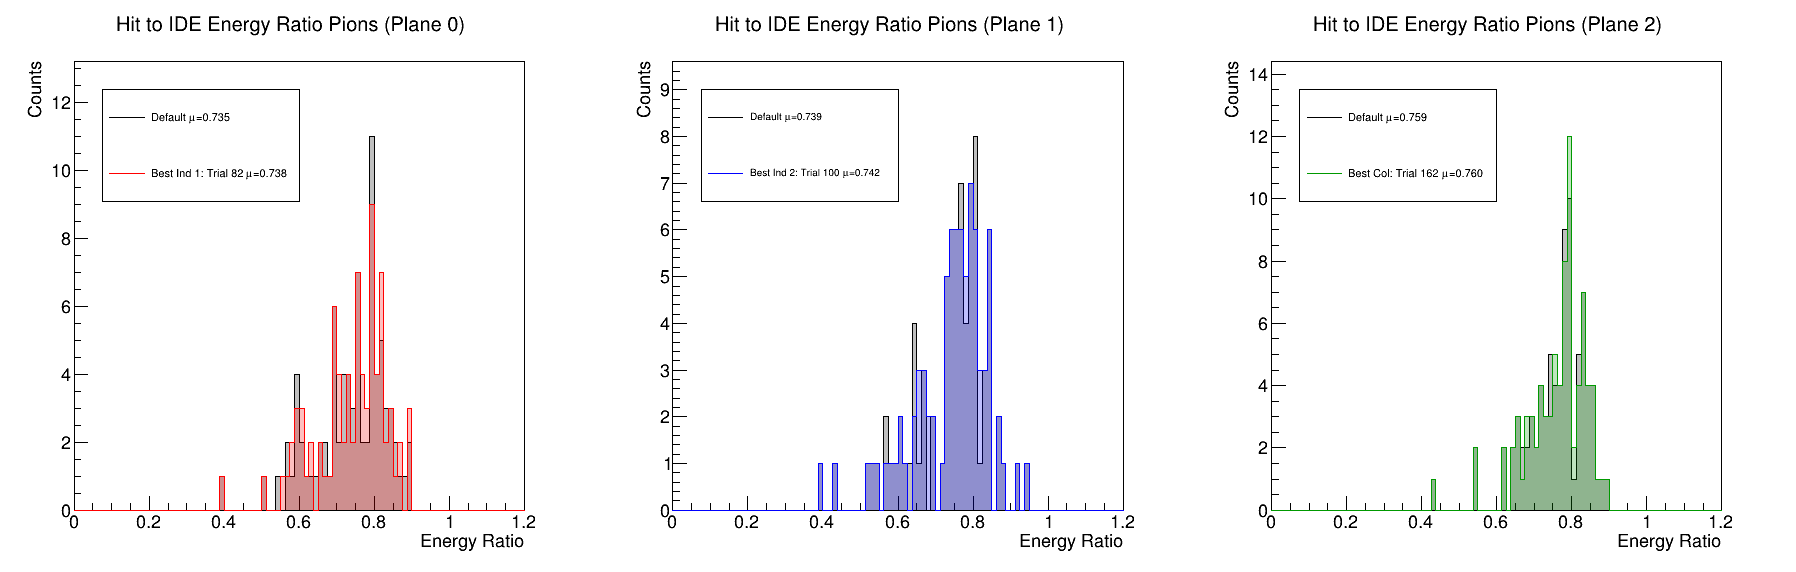

In [88]:
plotName = "Pions/h_energyRatio_pi_plane"
particle = "Pions"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Best Ind 1: Trial 82', 'Best Ind 2: Trial 100', 'Best Col: Trial 162']

h_nom0 = files[0].Get(f"{plotName}0")
h_nom1 = files[0].Get(f"{plotName}1")
h_nom2 = files[0].Get(f"{plotName}2")

h_nom = [h_nom0, h_nom1, h_nom2]

h_0 = f_mod0.Get(f"{plotName}0")
h_1 = f_mod1.Get(f"{plotName}1")
h_2 = f_mod2.Get(f"{plotName}2")

h_mod = [h_0, h_1, h_2]

legends = [r.TLegend(0.15, 0.65, 0.50, 0.85) for _ in range(3)]

for ic in range(3):
    c1.cd(ic+1)
    h_nom[ic].SetLineColor(r.kBlack)
    h_nom[ic].SetFillColorAlpha(r.kBlack, 0.25)
    h_mod[ic].SetFillColorAlpha(colors[ic+1], 0.25)
    h_nom[ic].SetTitle(f"Hit to IDE Energy Ratio {particle} (Plane {ic});Energy Ratio;Counts")
    maxY = max(h_nom[ic].GetMaximum(), h_mod[ic].GetMaximum())
    h_nom[ic].GetYaxis().SetRangeUser(0, maxY*1.2)
    h_nom[ic].GetXaxis().SetRangeUser(0, 1.2)
    h_nom[ic].Draw("hist")
    h_mod[ic].SetLineColor(colors[ic+1])
    h_mod[ic].Draw("hist same")
    legends[ic].AddEntry(h_nom[ic], f'{labels[0]} #mu={h_nom[ic].GetMean():.3f}', "l")
    legends[ic].AddEntry(h_mod[ic], f'{labels[ic+1]} #mu={h_mod[ic].GetMean():.3f}', "l")
    legends[ic].Draw("same")

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


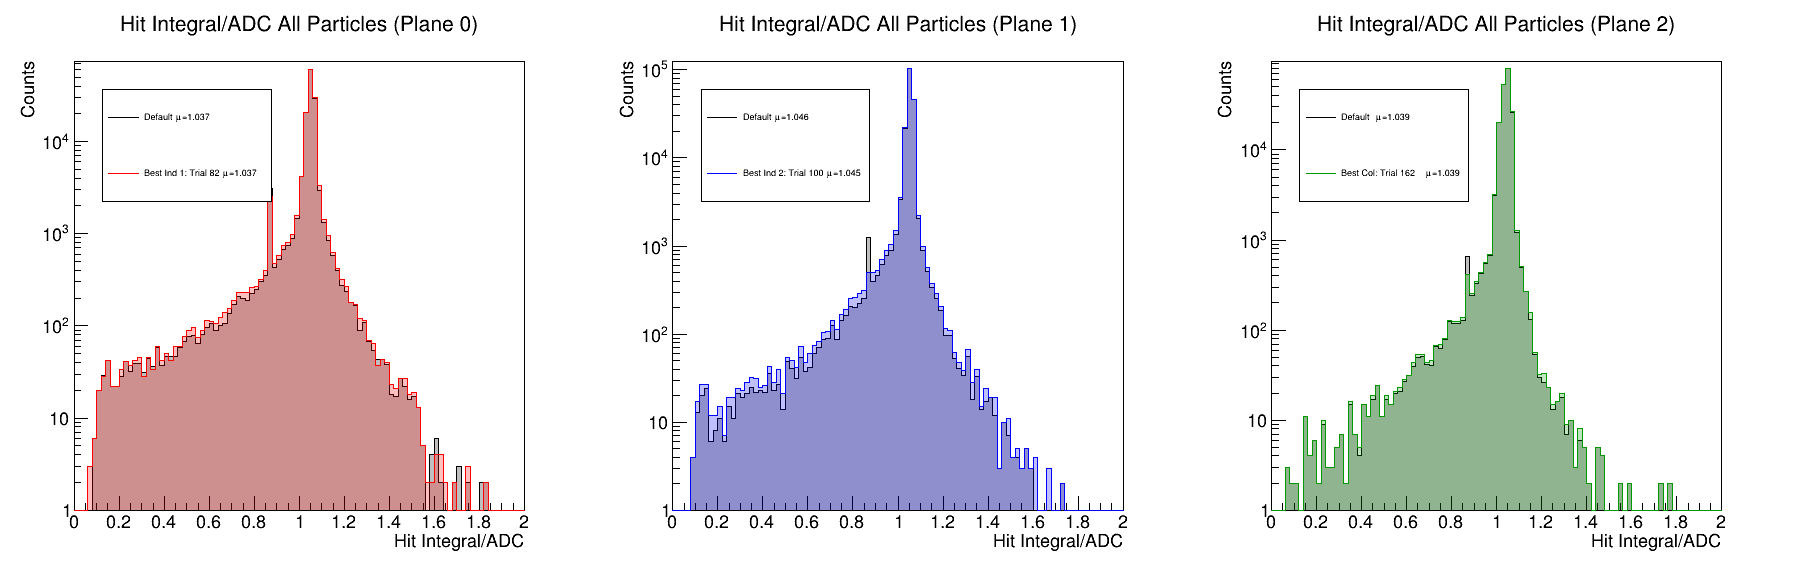

In [89]:
plotName = "AllParticles/h_hitAreaRatio_plane"
particle = "All Particles"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Best Ind 1: Trial 82', 'Best Ind 2: Trial 100', 'Best Col: Trial 162']

h_nom0 = files[0].Get(f"{plotName}0")
h_nom1 = files[0].Get(f"{plotName}1")
h_nom2 = files[0].Get(f"{plotName}2")

h_nom = [h_nom0, h_nom1, h_nom2]

h_0 = f_mod0.Get(f"{plotName}0")
h_1 = f_mod1.Get(f"{plotName}1")
h_2 = f_mod2.Get(f"{plotName}2")

h_mod = [h_0, h_1, h_2]

legends = [r.TLegend(0.15, 0.65, 0.45, 0.85) for _ in range(3)]

for ic in range(3):
    c1.cd(ic+1)
    h_nom[ic].SetLineColor(r.kBlack)
    h_nom[ic].SetFillColorAlpha(r.kBlack, 0.25)
    h_mod[ic].SetFillColorAlpha(colors[ic+1], 0.25)
    h_nom[ic].SetTitle(f"Hit Integral/ADC {particle} (Plane {ic});Hit Integral/ADC;Counts")
    maxY = max(h_nom[ic].GetMaximum(), h_mod[ic].GetMaximum())
    h_nom[ic].GetYaxis().SetRangeUser(1, maxY*1.2)
    #h_nom[ic].GetXaxis().SetRangeUser(0, 1.2)
    h_nom[ic].Draw("hist")
    h_mod[ic].SetLineColor(colors[ic+1])
    h_mod[ic].Draw("hist same")
    legends[ic].AddEntry(h_nom[ic], f'{labels[0]} #mu={h_nom[ic].GetMean():.3f}', "l")
    legends[ic].AddEntry(h_mod[ic], f'{labels[ic+1]} #mu={h_mod[ic].GetMean():.3f}', "l")
    legends[ic].Draw("same")
    r.gPad.SetLogy()

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


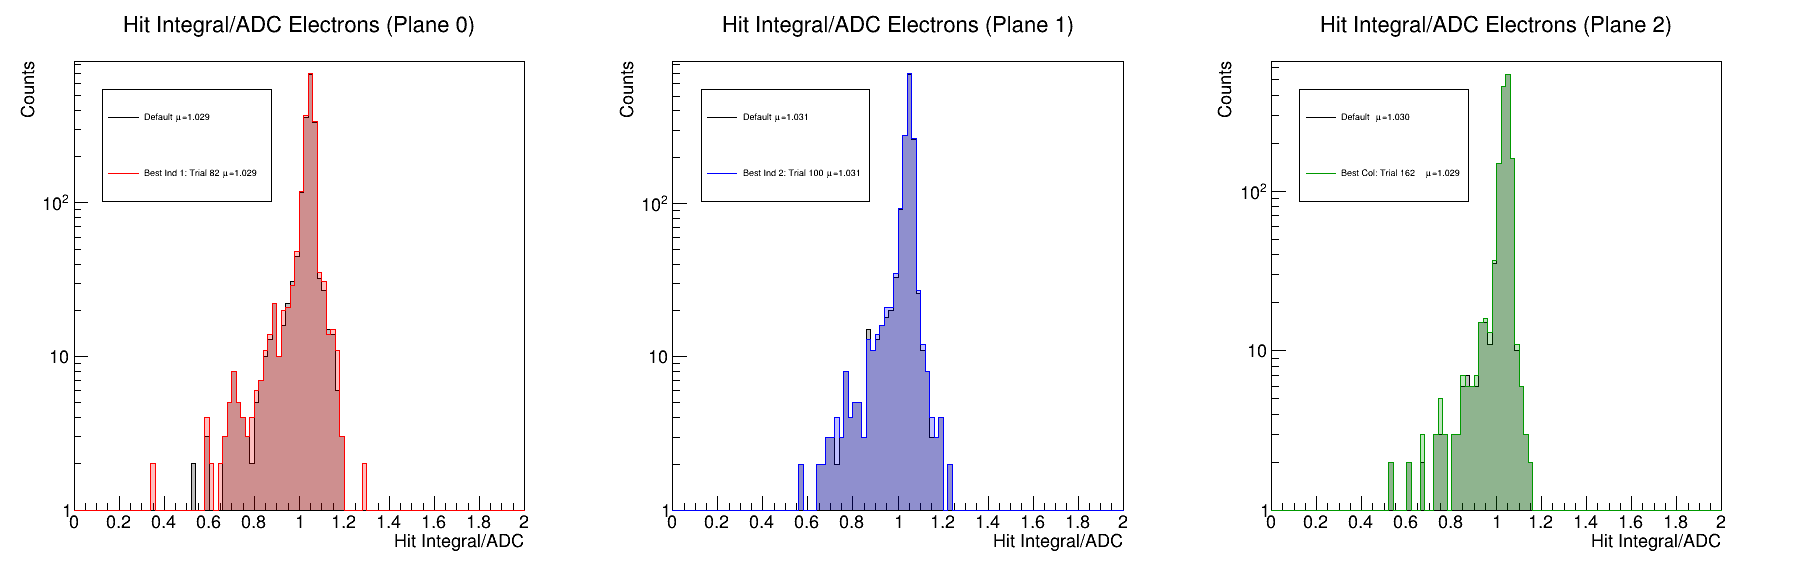

In [90]:
plotName = "Electrons/h_hitAreaRatio_ele_plane"
particle = "Electrons"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Best Ind 1: Trial 82', 'Best Ind 2: Trial 100', 'Best Col: Trial 162']

h_nom0 = files[0].Get(f"{plotName}0")
h_nom1 = files[0].Get(f"{plotName}1")
h_nom2 = files[0].Get(f"{plotName}2")

h_nom = [h_nom0, h_nom1, h_nom2]

h_0 = f_mod0.Get(f"{plotName}0")
h_1 = f_mod1.Get(f"{plotName}1")
h_2 = f_mod2.Get(f"{plotName}2")

h_mod = [h_0, h_1, h_2]

legends = [r.TLegend(0.15, 0.65, 0.45, 0.85) for _ in range(3)]

for ic in range(3):
    c1.cd(ic+1)
    h_nom[ic].SetLineColor(r.kBlack)
    h_nom[ic].SetFillColorAlpha(r.kBlack, 0.25)
    h_mod[ic].SetFillColorAlpha(colors[ic+1], 0.25)
    h_nom[ic].SetTitle(f"Hit Integral/ADC {particle} (Plane {ic});Hit Integral/ADC;Counts")
    maxY = max(h_nom[ic].GetMaximum(), h_mod[ic].GetMaximum())
    h_nom[ic].GetYaxis().SetRangeUser(1, maxY*1.2)
    #h_nom[ic].GetXaxis().SetRangeUser(0, 1.2)
    h_nom[ic].Draw("hist")
    h_mod[ic].SetLineColor(colors[ic+1])
    h_mod[ic].Draw("hist same")
    legends[ic].AddEntry(h_nom[ic], f'{labels[0]} #mu={h_nom[ic].GetMean():.3f}', "l")
    legends[ic].AddEntry(h_mod[ic], f'{labels[ic+1]} #mu={h_mod[ic].GetMean():.3f}', "l")
    legends[ic].Draw("same")
    r.gPad.SetLogy()

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


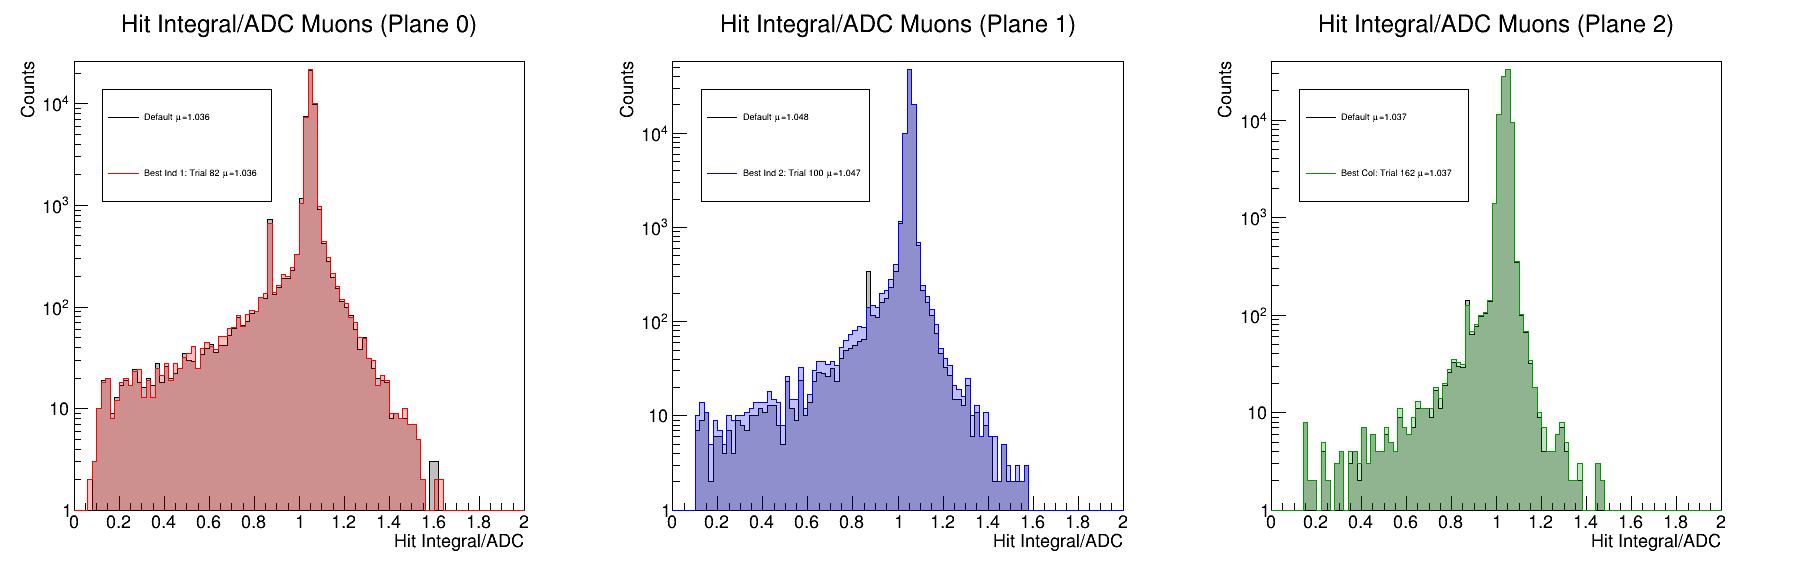

In [91]:
plotName = "Muons/h_hitAreaRatio_mu_plane"
particle = "Muons"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Best Ind 1: Trial 82', 'Best Ind 2: Trial 100', 'Best Col: Trial 162']

h_nom0 = files[0].Get(f"{plotName}0")
h_nom1 = files[0].Get(f"{plotName}1")
h_nom2 = files[0].Get(f"{plotName}2")

h_nom = [h_nom0, h_nom1, h_nom2]

h_0 = f_mod0.Get(f"{plotName}0")
h_1 = f_mod1.Get(f"{plotName}1")
h_2 = f_mod2.Get(f"{plotName}2")

h_mod = [h_0, h_1, h_2]

legends = [r.TLegend(0.15, 0.65, 0.45, 0.85) for _ in range(3)]

for ic in range(3):
    c1.cd(ic+1)
    h_nom[ic].SetLineColor(r.kBlack)
    h_nom[ic].SetFillColorAlpha(r.kBlack, 0.25)
    h_mod[ic].SetFillColorAlpha(colors[ic+1], 0.25)
    h_nom[ic].SetTitle(f"Hit Integral/ADC {particle} (Plane {ic});Hit Integral/ADC;Counts")
    maxY = max(h_nom[ic].GetMaximum(), h_mod[ic].GetMaximum())
    h_nom[ic].GetYaxis().SetRangeUser(1, maxY*1.2)
    #h_nom[ic].GetXaxis().SetRangeUser(0, 1.2)
    h_nom[ic].Draw("hist")
    h_mod[ic].SetLineColor(colors[ic+1])
    h_mod[ic].Draw("hist same")
    legends[ic].AddEntry(h_nom[ic], f'{labels[0]} #mu={h_nom[ic].GetMean():.3f}', "l")
    legends[ic].AddEntry(h_mod[ic], f'{labels[ic+1]} #mu={h_mod[ic].GetMean():.3f}', "l")
    legends[ic].Draw("same")
    r.gPad.SetLogy()

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


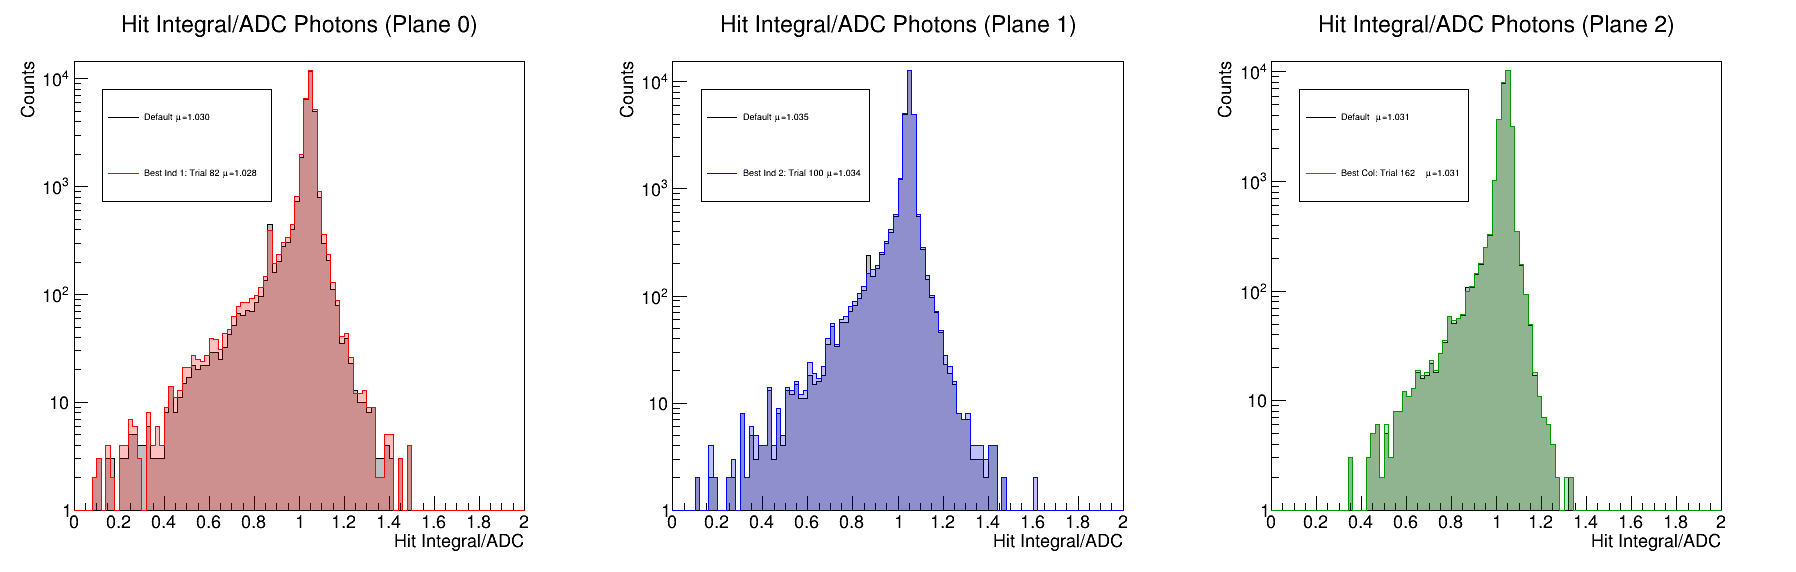

In [92]:
plotName = "Photons/h_hitAreaRatio_gamma_plane"
particle = "Photons"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Best Ind 1: Trial 82', 'Best Ind 2: Trial 100', 'Best Col: Trial 162']

h_nom0 = files[0].Get(f"{plotName}0")
h_nom1 = files[0].Get(f"{plotName}1")
h_nom2 = files[0].Get(f"{plotName}2")

h_nom = [h_nom0, h_nom1, h_nom2]

h_0 = f_mod0.Get(f"{plotName}0")
h_1 = f_mod1.Get(f"{plotName}1")
h_2 = f_mod2.Get(f"{plotName}2")

h_mod = [h_0, h_1, h_2]

legends = [r.TLegend(0.15, 0.65, 0.45, 0.85) for _ in range(3)]

for ic in range(3):
    c1.cd(ic+1)
    h_nom[ic].SetLineColor(r.kBlack)
    h_nom[ic].SetFillColorAlpha(r.kBlack, 0.25)
    h_mod[ic].SetFillColorAlpha(colors[ic+1], 0.25)
    h_nom[ic].SetTitle(f"Hit Integral/ADC {particle} (Plane {ic});Hit Integral/ADC;Counts")
    maxY = max(h_nom[ic].GetMaximum(), h_mod[ic].GetMaximum())
    h_nom[ic].GetYaxis().SetRangeUser(1, maxY*1.2)
    #h_nom[ic].GetXaxis().SetRangeUser(0, 1.2)
    h_nom[ic].Draw("hist")
    h_mod[ic].SetLineColor(colors[ic+1])
    h_mod[ic].Draw("hist same")
    legends[ic].AddEntry(h_nom[ic], f'{labels[0]} #mu={h_nom[ic].GetMean():.3f}', "l")
    legends[ic].AddEntry(h_mod[ic], f'{labels[ic+1]} #mu={h_mod[ic].GetMean():.3f}', "l")
    legends[ic].Draw("same")
    r.gPad.SetLogy()

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


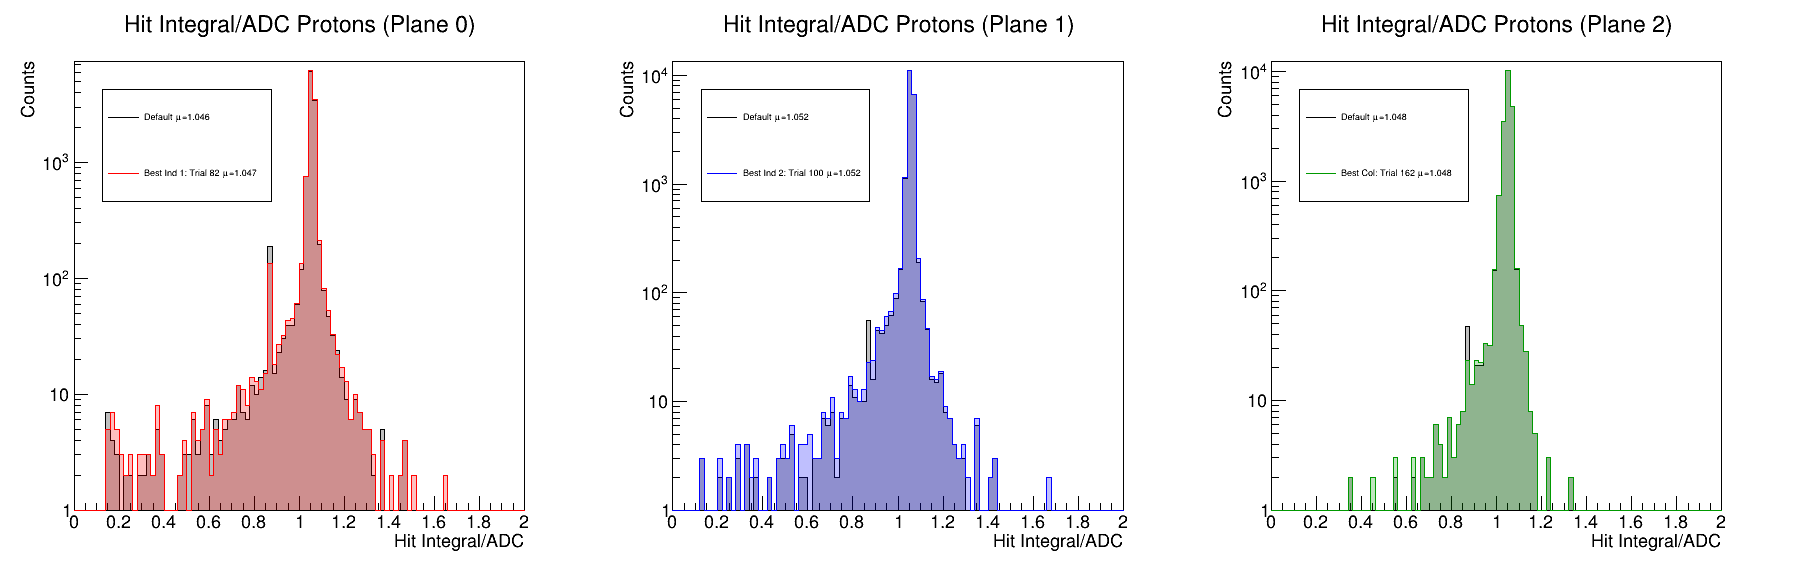

In [93]:
plotName = "Protons/h_hitAreaRatio_p_plane"
particle = "Protons"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Best Ind 1: Trial 82', 'Best Ind 2: Trial 100', 'Best Col: Trial 162']

h_nom0 = files[0].Get(f"{plotName}0")
h_nom1 = files[0].Get(f"{plotName}1")
h_nom2 = files[0].Get(f"{plotName}2")

h_nom = [h_nom0, h_nom1, h_nom2]

h_0 = f_mod0.Get(f"{plotName}0")
h_1 = f_mod1.Get(f"{plotName}1")
h_2 = f_mod2.Get(f"{plotName}2")

h_mod = [h_0, h_1, h_2]

legends = [r.TLegend(0.15, 0.65, 0.45, 0.85) for _ in range(3)]

for ic in range(3):
    c1.cd(ic+1)
    h_nom[ic].SetLineColor(r.kBlack)
    h_nom[ic].SetFillColorAlpha(r.kBlack, 0.25)
    h_mod[ic].SetFillColorAlpha(colors[ic+1], 0.25)
    h_nom[ic].SetTitle(f"Hit Integral/ADC {particle} (Plane {ic});Hit Integral/ADC;Counts")
    maxY = max(h_nom[ic].GetMaximum(), h_mod[ic].GetMaximum())
    h_nom[ic].GetYaxis().SetRangeUser(1, maxY*1.2)
    #h_nom[ic].GetXaxis().SetRangeUser(0, 1.2)
    h_nom[ic].Draw("hist")
    h_mod[ic].SetLineColor(colors[ic+1])
    h_mod[ic].Draw("hist same")
    legends[ic].AddEntry(h_nom[ic], f'{labels[0]} #mu={h_nom[ic].GetMean():.3f}', "l")
    legends[ic].AddEntry(h_mod[ic], f'{labels[ic+1]} #mu={h_mod[ic].GetMean():.3f}', "l")
    legends[ic].Draw("same")
    r.gPad.SetLogy()

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


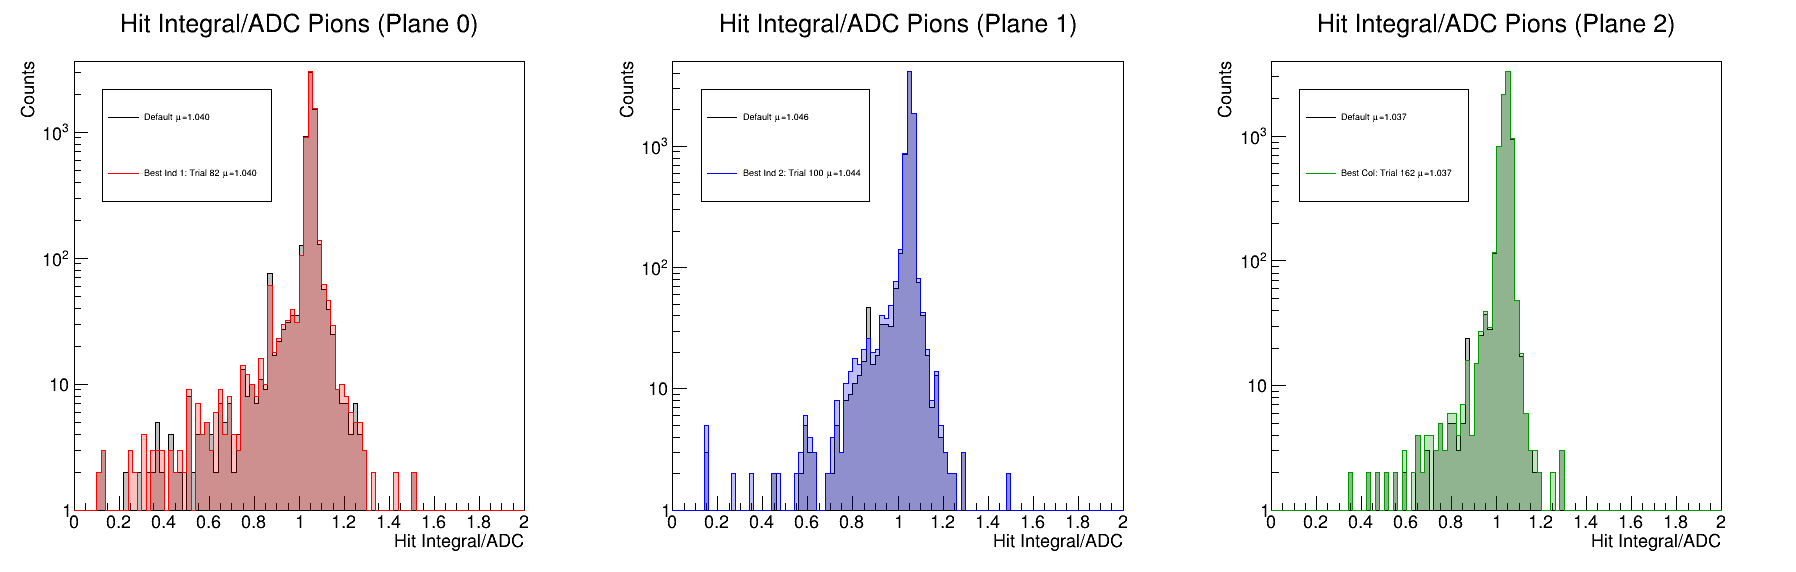

In [94]:
plotName = "Pions/h_hitAreaRatio_pi_plane"
particle = "Pions"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Best Ind 1: Trial 82', 'Best Ind 2: Trial 100', 'Best Col: Trial 162']

h_nom0 = files[0].Get(f"{plotName}0")
h_nom1 = files[0].Get(f"{plotName}1")
h_nom2 = files[0].Get(f"{plotName}2")

h_nom = [h_nom0, h_nom1, h_nom2]

h_0 = f_mod0.Get(f"{plotName}0")
h_1 = f_mod1.Get(f"{plotName}1")
h_2 = f_mod2.Get(f"{plotName}2")

h_mod = [h_0, h_1, h_2]

legends = [r.TLegend(0.15, 0.65, 0.45, 0.85) for _ in range(3)]

for ic in range(3):
    c1.cd(ic+1)
    h_nom[ic].SetLineColor(r.kBlack)
    h_nom[ic].SetFillColorAlpha(r.kBlack, 0.25)
    h_mod[ic].SetFillColorAlpha(colors[ic+1], 0.25)
    h_nom[ic].SetTitle(f"Hit Integral/ADC {particle} (Plane {ic});Hit Integral/ADC;Counts")
    maxY = max(h_nom[ic].GetMaximum(), h_mod[ic].GetMaximum())
    h_nom[ic].GetYaxis().SetRangeUser(1, maxY*1.2)
    #h_nom[ic].GetXaxis().SetRangeUser(0, 1.2)
    h_nom[ic].Draw("hist")
    h_mod[ic].SetLineColor(colors[ic+1])
    h_mod[ic].Draw("hist same")
    legends[ic].AddEntry(h_nom[ic], f'{labels[0]} #mu={h_nom[ic].GetMean():.3f}', "l")
    legends[ic].AddEntry(h_mod[ic], f'{labels[ic+1]} #mu={h_mod[ic].GetMean():.3f}', "l")
    legends[ic].Draw("same")
    r.gPad.SetLogy()

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


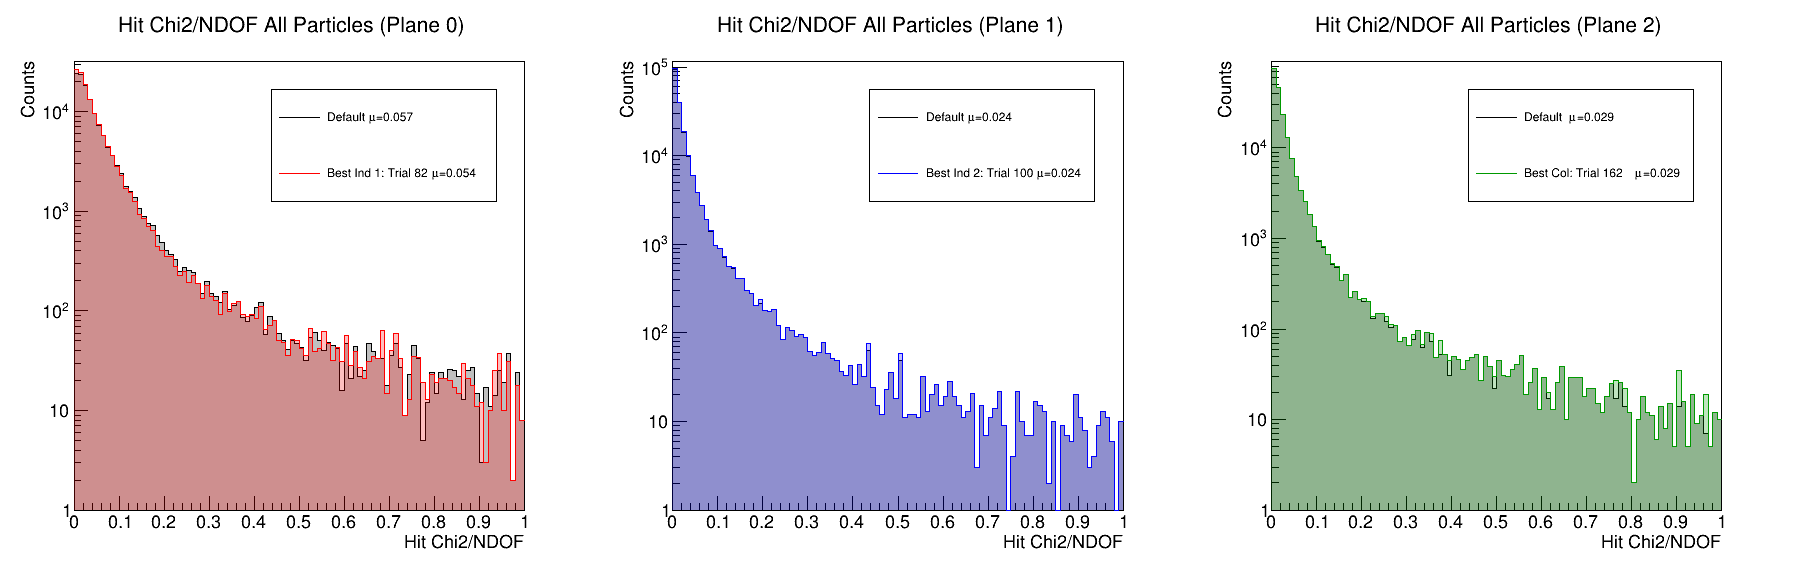

In [95]:
plotName = "AllParticles/h_hitFit_plane"
particle = "All Particles"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Best Ind 1: Trial 82', 'Best Ind 2: Trial 100', 'Best Col: Trial 162']

h_nom0 = files[0].Get(f"{plotName}0")
h_nom1 = files[0].Get(f"{plotName}1")
h_nom2 = files[0].Get(f"{plotName}2")

h_nom = [h_nom0, h_nom1, h_nom2]

h_0 = f_mod0.Get(f"{plotName}0")
h_1 = f_mod1.Get(f"{plotName}1")
h_2 = f_mod2.Get(f"{plotName}2")

h_mod = [h_0, h_1, h_2]

legends = [r.TLegend(0.45, 0.65, 0.85, 0.85) for _ in range(3)]

for ic in range(3):
    c1.cd(ic+1)
    h_nom[ic].SetLineColor(r.kBlack)
    h_nom[ic].SetFillColorAlpha(r.kBlack, 0.25)
    h_mod[ic].SetFillColorAlpha(colors[ic+1], 0.25)
    h_nom[ic].SetTitle(f"Hit Chi2/NDOF {particle} (Plane {ic});Hit Chi2/NDOF;Counts")
    maxY = max(h_nom[ic].GetMaximum(), h_mod[ic].GetMaximum())
    h_nom[ic].GetYaxis().SetRangeUser(1, maxY*1.2)
    #h_nom[ic].GetXaxis().SetRangeUser(0, 1.2)
    h_nom[ic].Draw("hist")
    h_mod[ic].SetLineColor(colors[ic+1])
    h_mod[ic].Draw("hist same")
    legends[ic].AddEntry(h_nom[ic], f'{labels[0]} #mu={h_nom[ic].GetMean():.3f}', "l")
    legends[ic].AddEntry(h_mod[ic], f'{labels[ic+1]} #mu={h_mod[ic].GetMean():.3f}', "l")
    legends[ic].Draw("same")
    r.gPad.SetLogy()

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


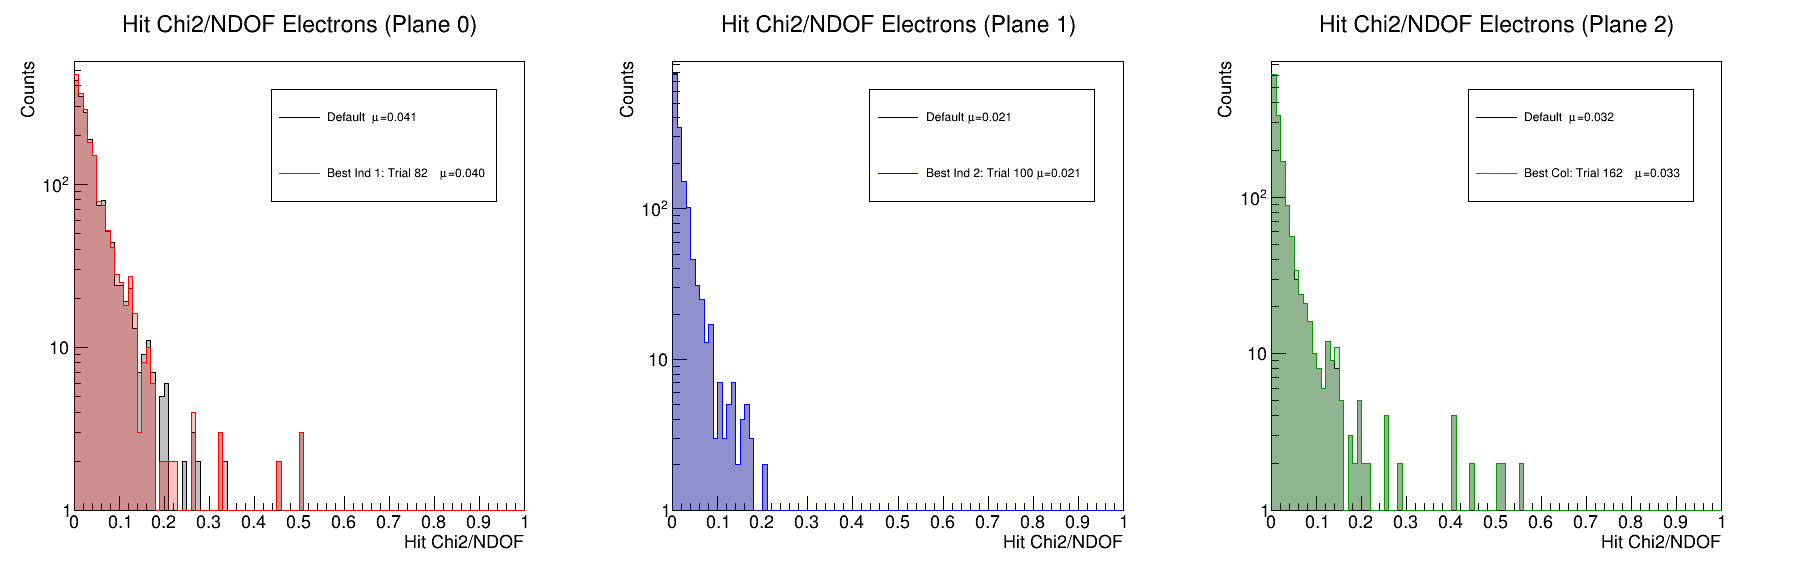

In [96]:
plotName = "Electrons/h_hitFit_ele_plane"
particle = "Electrons"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Best Ind 1: Trial 82', 'Best Ind 2: Trial 100', 'Best Col: Trial 162']

h_nom0 = files[0].Get(f"{plotName}0")
h_nom1 = files[0].Get(f"{plotName}1")
h_nom2 = files[0].Get(f"{plotName}2")

h_nom = [h_nom0, h_nom1, h_nom2]

h_0 = f_mod0.Get(f"{plotName}0")
h_1 = f_mod1.Get(f"{plotName}1")
h_2 = f_mod2.Get(f"{plotName}2")

h_mod = [h_0, h_1, h_2]

legends = [r.TLegend(0.45, 0.65, 0.85, 0.85) for _ in range(3)]

for ic in range(3):
    c1.cd(ic+1)
    h_nom[ic].SetLineColor(r.kBlack)
    h_nom[ic].SetFillColorAlpha(r.kBlack, 0.25)
    h_mod[ic].SetFillColorAlpha(colors[ic+1], 0.25)
    h_nom[ic].SetTitle(f"Hit Chi2/NDOF {particle} (Plane {ic});Hit Chi2/NDOF;Counts")
    maxY = max(h_nom[ic].GetMaximum(), h_mod[ic].GetMaximum())
    h_nom[ic].GetYaxis().SetRangeUser(1, maxY*1.2)
    #h_nom[ic].GetXaxis().SetRangeUser(0, 1.2)
    h_nom[ic].Draw("hist")
    h_mod[ic].SetLineColor(colors[ic+1])
    h_mod[ic].Draw("hist same")
    legends[ic].AddEntry(h_nom[ic], f'{labels[0]} #mu={h_nom[ic].GetMean():.3f}', "l")
    legends[ic].AddEntry(h_mod[ic], f'{labels[ic+1]} #mu={h_mod[ic].GetMean():.3f}', "l")
    legends[ic].Draw("same")
    r.gPad.SetLogy()

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


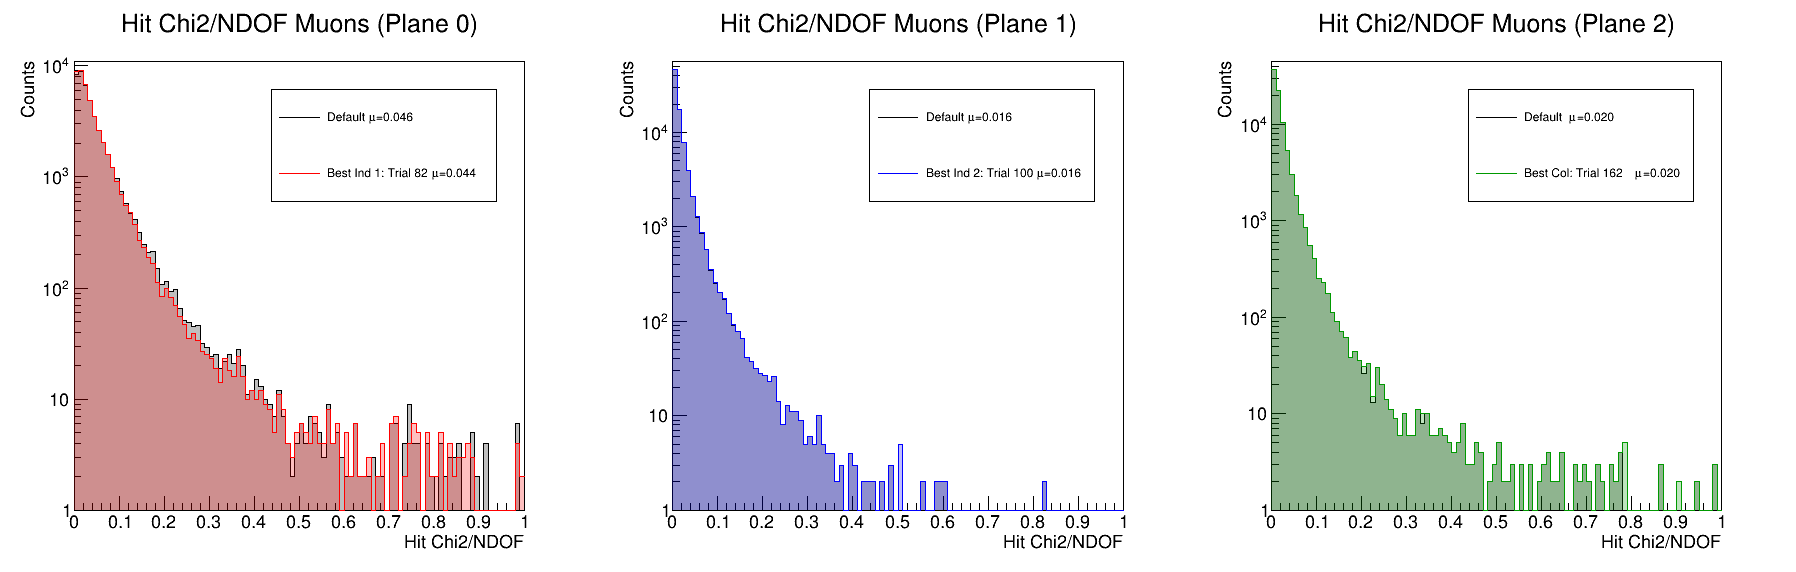

In [97]:
plotName = "Muons/h_hitFit_mu_plane"
particle = "Muons"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Best Ind 1: Trial 82', 'Best Ind 2: Trial 100', 'Best Col: Trial 162']

h_nom0 = files[0].Get(f"{plotName}0")
h_nom1 = files[0].Get(f"{plotName}1")
h_nom2 = files[0].Get(f"{plotName}2")

h_nom = [h_nom0, h_nom1, h_nom2]

h_0 = f_mod0.Get(f"{plotName}0")
h_1 = f_mod1.Get(f"{plotName}1")
h_2 = f_mod2.Get(f"{plotName}2")

h_mod = [h_0, h_1, h_2]

legends = [r.TLegend(0.45, 0.65, 0.85, 0.85) for _ in range(3)]

for ic in range(3):
    c1.cd(ic+1)
    h_nom[ic].SetLineColor(r.kBlack)
    h_nom[ic].SetFillColorAlpha(r.kBlack, 0.25)
    h_mod[ic].SetFillColorAlpha(colors[ic+1], 0.25)
    h_nom[ic].SetTitle(f"Hit Chi2/NDOF {particle} (Plane {ic});Hit Chi2/NDOF;Counts")
    maxY = max(h_nom[ic].GetMaximum(), h_mod[ic].GetMaximum())
    h_nom[ic].GetYaxis().SetRangeUser(1, maxY*1.2)
    #h_nom[ic].GetXaxis().SetRangeUser(0, 1.2)
    h_nom[ic].Draw("hist")
    h_mod[ic].SetLineColor(colors[ic+1])
    h_mod[ic].Draw("hist same")
    legends[ic].AddEntry(h_nom[ic], f'{labels[0]} #mu={h_nom[ic].GetMean():.3f}', "l")
    legends[ic].AddEntry(h_mod[ic], f'{labels[ic+1]} #mu={h_mod[ic].GetMean():.3f}', "l")
    legends[ic].Draw("same")
    r.gPad.SetLogy()

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


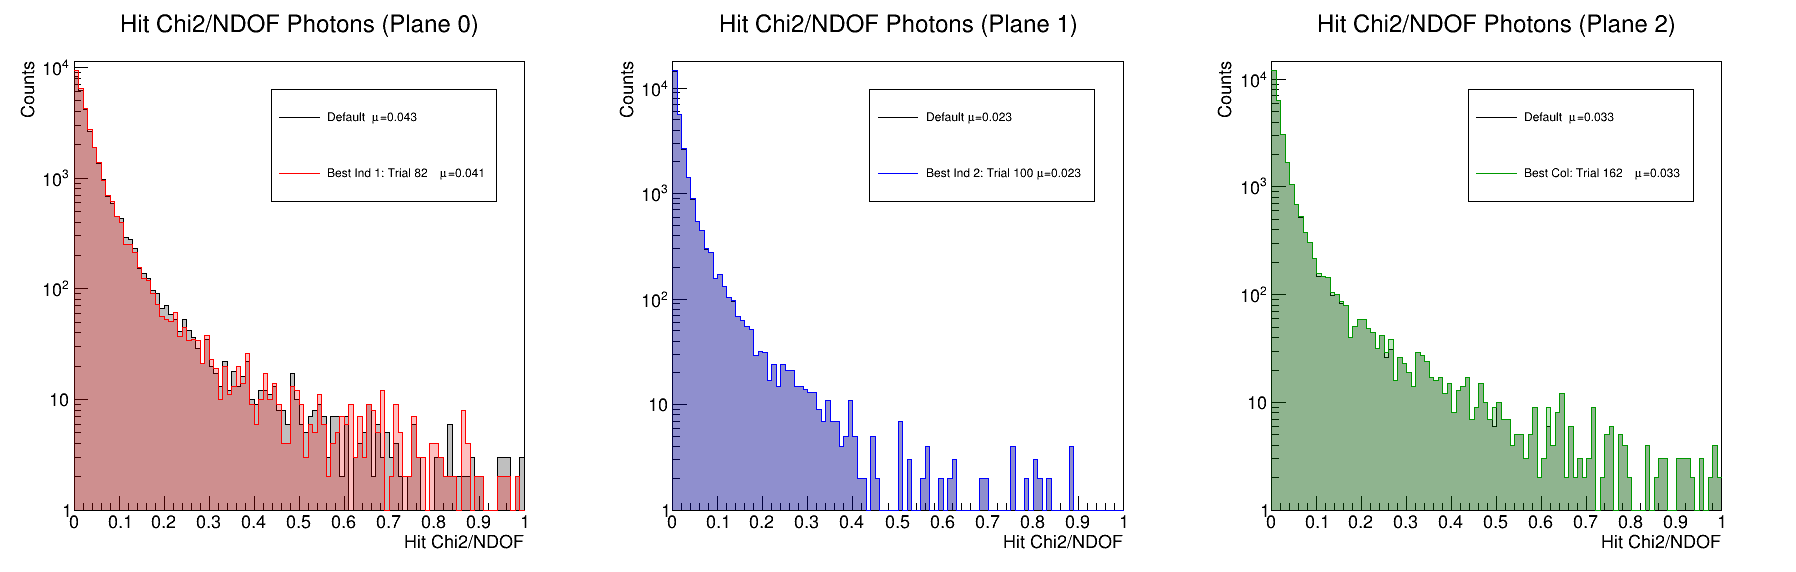

In [98]:
plotName = "Photons/h_hitFit_gamma_plane"
particle = "Photons"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Best Ind 1: Trial 82', 'Best Ind 2: Trial 100', 'Best Col: Trial 162']

h_nom0 = files[0].Get(f"{plotName}0")
h_nom1 = files[0].Get(f"{plotName}1")
h_nom2 = files[0].Get(f"{plotName}2")

h_nom = [h_nom0, h_nom1, h_nom2]

h_0 = f_mod0.Get(f"{plotName}0")
h_1 = f_mod1.Get(f"{plotName}1")
h_2 = f_mod2.Get(f"{plotName}2")

h_mod = [h_0, h_1, h_2]

legends = [r.TLegend(0.45, 0.65, 0.85, 0.85) for _ in range(3)]

for ic in range(3):
    c1.cd(ic+1)
    h_nom[ic].SetLineColor(r.kBlack)
    h_nom[ic].SetFillColorAlpha(r.kBlack, 0.25)
    h_mod[ic].SetFillColorAlpha(colors[ic+1], 0.25)
    h_nom[ic].SetTitle(f"Hit Chi2/NDOF {particle} (Plane {ic});Hit Chi2/NDOF;Counts")
    maxY = max(h_nom[ic].GetMaximum(), h_mod[ic].GetMaximum())
    h_nom[ic].GetYaxis().SetRangeUser(1, maxY*1.2)
    #h_nom[ic].GetXaxis().SetRangeUser(0, 1.2)
    h_nom[ic].Draw("hist")
    h_mod[ic].SetLineColor(colors[ic+1])
    h_mod[ic].Draw("hist same")
    legends[ic].AddEntry(h_nom[ic], f'{labels[0]} #mu={h_nom[ic].GetMean():.3f}', "l")
    legends[ic].AddEntry(h_mod[ic], f'{labels[ic+1]} #mu={h_mod[ic].GetMean():.3f}', "l")
    legends[ic].Draw("same")
    r.gPad.SetLogy()

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


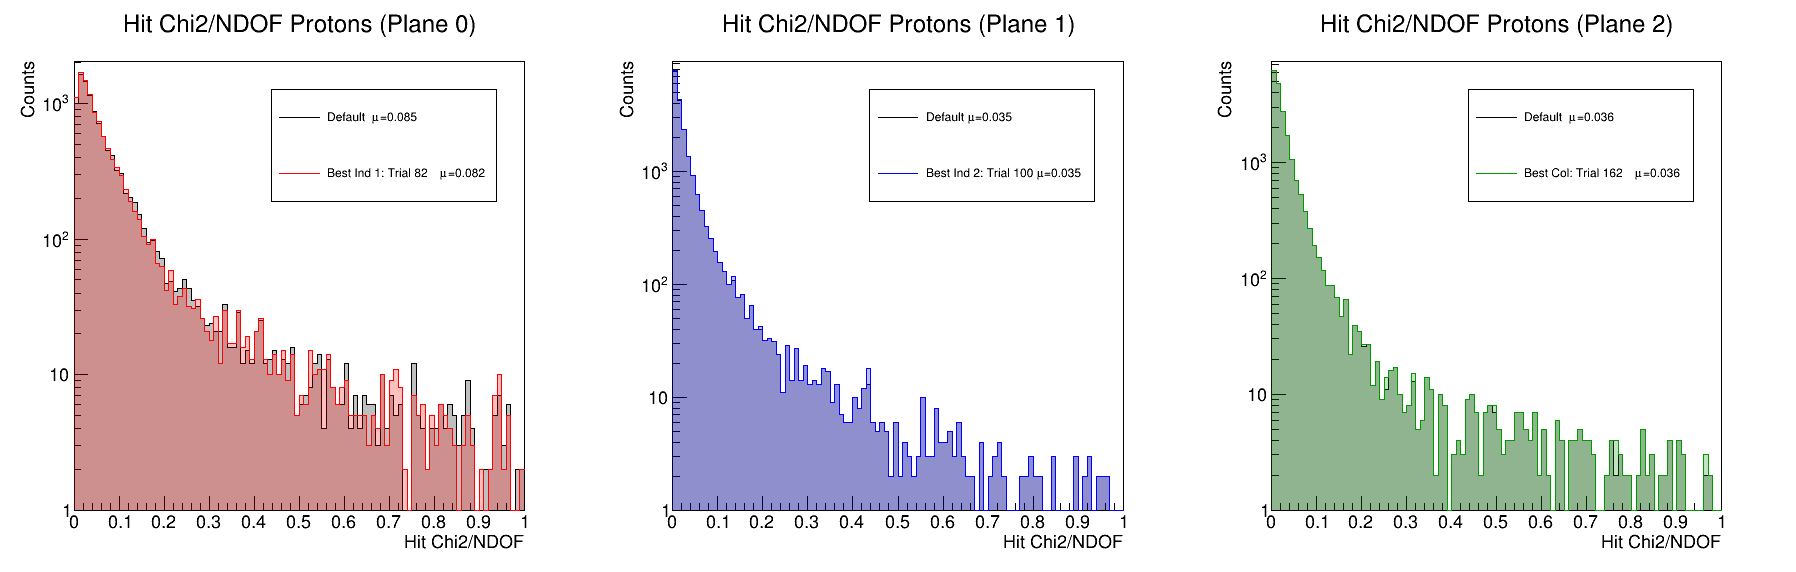

In [99]:
plotName = "Protons/h_hitFit_p_plane"
particle = "Protons"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Best Ind 1: Trial 82', 'Best Ind 2: Trial 100', 'Best Col: Trial 162']

h_nom0 = files[0].Get(f"{plotName}0")
h_nom1 = files[0].Get(f"{plotName}1")
h_nom2 = files[0].Get(f"{plotName}2")

h_nom = [h_nom0, h_nom1, h_nom2]

h_0 = f_mod0.Get(f"{plotName}0")
h_1 = f_mod1.Get(f"{plotName}1")
h_2 = f_mod2.Get(f"{plotName}2")

h_mod = [h_0, h_1, h_2]

legends = [r.TLegend(0.45, 0.65, 0.85, 0.85) for _ in range(3)]

for ic in range(3):
    c1.cd(ic+1)
    h_nom[ic].SetLineColor(r.kBlack)
    h_nom[ic].SetFillColorAlpha(r.kBlack, 0.25)
    h_mod[ic].SetFillColorAlpha(colors[ic+1], 0.25)
    h_nom[ic].SetTitle(f"Hit Chi2/NDOF {particle} (Plane {ic});Hit Chi2/NDOF;Counts")
    maxY = max(h_nom[ic].GetMaximum(), h_mod[ic].GetMaximum())
    h_nom[ic].GetYaxis().SetRangeUser(1, maxY*1.2)
    #h_nom[ic].GetXaxis().SetRangeUser(0, 1.2)
    h_nom[ic].Draw("hist")
    h_mod[ic].SetLineColor(colors[ic+1])
    h_mod[ic].Draw("hist same")
    legends[ic].AddEntry(h_nom[ic], f'{labels[0]} #mu={h_nom[ic].GetMean():.3f}', "l")
    legends[ic].AddEntry(h_mod[ic], f'{labels[ic+1]} #mu={h_mod[ic].GetMean():.3f}', "l")
    legends[ic].Draw("same")
    r.gPad.SetLogy()

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


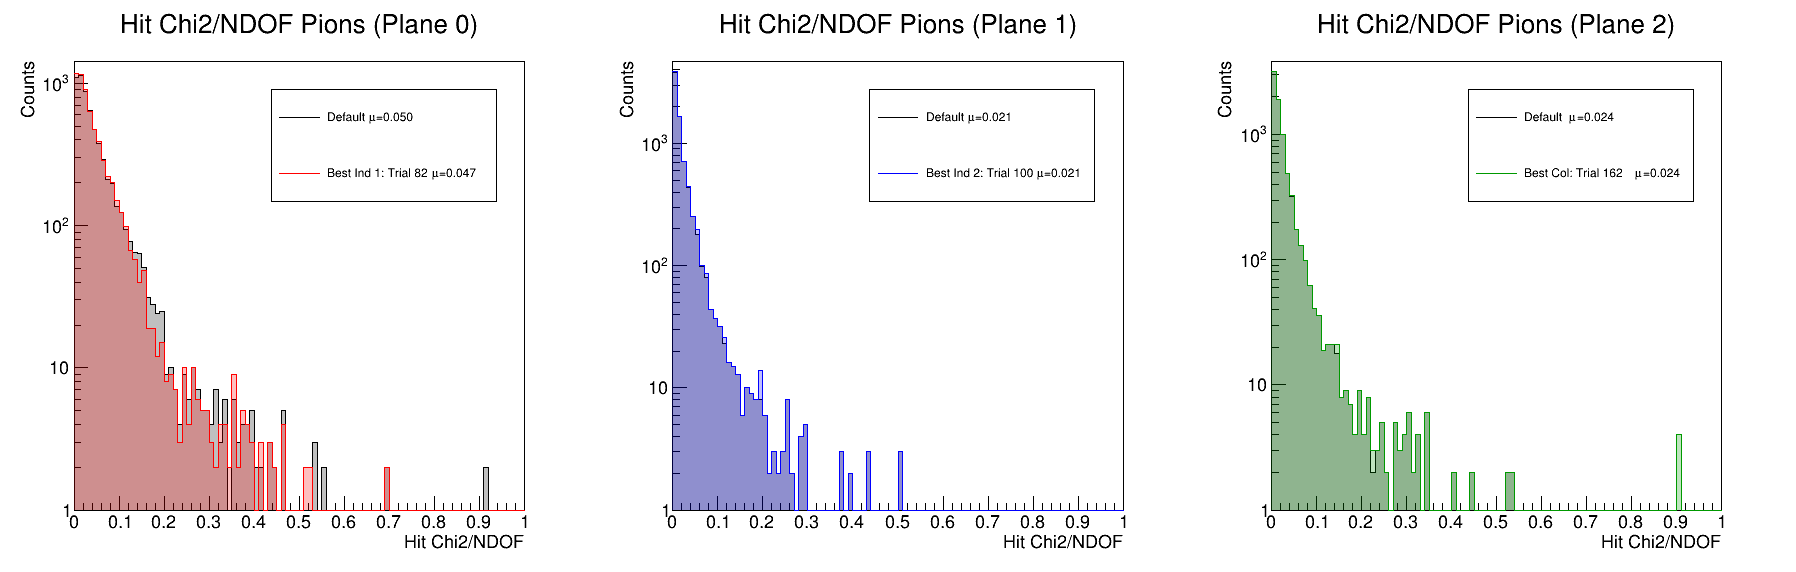

In [100]:
plotName = "Pions/h_hitFit_pi_plane"
particle = "Pions"
c1 = r.TCanvas("c1", "Hit Energy Comparison", 1800, 600)
c1.Divide(3, 1)
labels = ['Default', 'Best Ind 1: Trial 82', 'Best Ind 2: Trial 100', 'Best Col: Trial 162']

h_nom0 = files[0].Get(f"{plotName}0")
h_nom1 = files[0].Get(f"{plotName}1")
h_nom2 = files[0].Get(f"{plotName}2")

h_nom = [h_nom0, h_nom1, h_nom2]

h_0 = f_mod0.Get(f"{plotName}0")
h_1 = f_mod1.Get(f"{plotName}1")
h_2 = f_mod2.Get(f"{plotName}2")

h_mod = [h_0, h_1, h_2]

legends = [r.TLegend(0.45, 0.65, 0.85, 0.85) for _ in range(3)]

for ic in range(3):
    c1.cd(ic+1)
    h_nom[ic].SetLineColor(r.kBlack)
    h_nom[ic].SetFillColorAlpha(r.kBlack, 0.25)
    h_mod[ic].SetFillColorAlpha(colors[ic+1], 0.25)
    h_nom[ic].SetTitle(f"Hit Chi2/NDOF {particle} (Plane {ic});Hit Chi2/NDOF;Counts")
    maxY = max(h_nom[ic].GetMaximum(), h_mod[ic].GetMaximum())
    h_nom[ic].GetYaxis().SetRangeUser(1, maxY*1.2)
    #h_nom[ic].GetXaxis().SetRangeUser(0, 1.2)
    h_nom[ic].Draw("hist")
    h_mod[ic].SetLineColor(colors[ic+1])
    h_mod[ic].Draw("hist same")
    legends[ic].AddEntry(h_nom[ic], f'{labels[0]} #mu={h_nom[ic].GetMean():.3f}', "l")
    legends[ic].AddEntry(h_mod[ic], f'{labels[ic+1]} #mu={h_mod[ic].GetMean():.3f}', "l")
    legends[ic].Draw("same")
    r.gPad.SetLogy()

c1.Draw()

### Input Dataset Particles

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


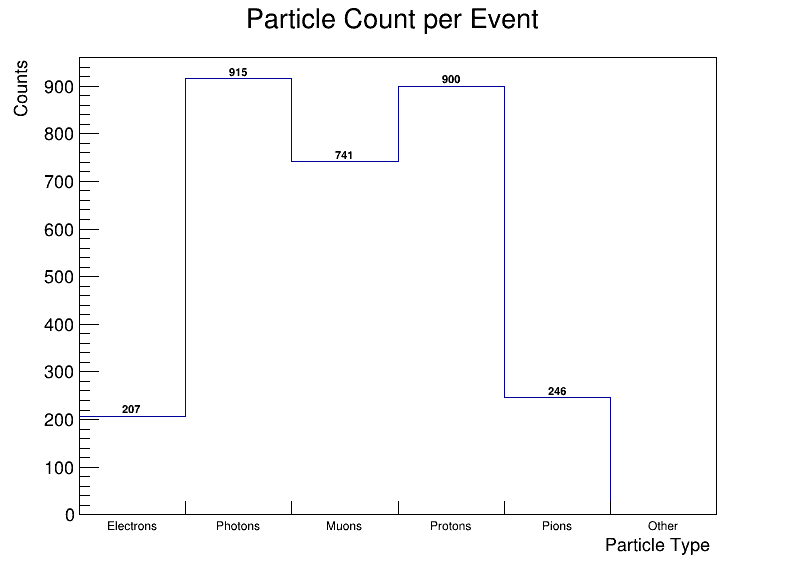

In [104]:
fin = r.TFile.Open('/nashome/m/micarrig/icarus/hitTuning/hist_output_1.root', 'READ')
h = fin.Get("h_particleCount")

binLabels = ['Electrons', 'Photons', 'Muons', 'Protons', 'Pions', 'Other']

c1 = r.TCanvas("c1", "Particle Count", 800, 600)
for i in range(h.GetNbinsX()):
    h.GetXaxis().SetBinLabel(i+1, binLabels[i])
h.Draw("hist text0")

c1.Draw()

### Make event displays

In [120]:
# Some functions that I find useful to reduce error-prone typing.
def read_header(h):
        """Make the ROOT C++ jit compiler read the specified header."""
        r.gROOT.ProcessLine('#include "%s"' % h)

def provide_get_valid_handle(klass):
        """Make the ROOT C++ jit compiler instantiate the
           Event::getValidHandle member template for template
           parameter klass."""
        r.gROOT.ProcessLine('template gallery::ValidHandle<%(name)s> gallery::Event::getValidHandle<%(name)s>(art::InputTag const&) const;' % {'name' : klass})

In [124]:
r.gInterpreter.AddIncludePath('/cvmfs/larsoft.opensciencegrid.org/products/canvas/v3_16_04/include') #$CANVAS_INC
r.gInterpreter.AddIncludePath('/cvmfs/larsoft.opensciencegrid.org/products/gallery/v1_22_06/include') #$GALLERY_INC
r.gInterpreter.AddIncludePath('/cvmfs/larsoft.opensciencegrid.org/products/art/v3_14_04/include') #$ART_INC

read_header('/cvmfs/larsoft.opensciencegrid.org/products/gallery/v1_22_06/include/gallery/ValidHandle.h')

provide_get_valid_handle('std::vector<simb::MCTruth>')

# Ensure art::InputTag is available to the interpreter
read_header('/cvmfs/larsoft.opensciencegrid.org/products/art/v3_14_04/include/art/Utilities/InputTag.h')
mctruths_tag = r.art.InputTag("generator")

filenames = r.std.vector('std::string')('/nashome/m/micarrig/icarus/hitTuning/fclFiles/output_tuneInd1_7.root')

ev = r.gallery.Event(filenames)

# Capture the functions that will get ValidHandles. This avoids some
# inefficiency in constructing the function objects many times.
get_mctruths = ev.getValidHandle(r.vector(r.simb.MCTruth))
while (not ev.atEnd()) :
        mctruths = get_mctruths(mctruths_tag)
        if (not mctruths.empty()):
                npart_hist.Fill(mctruths.product()[0].NParticles())

        # The Assns<> involved in demo.cc appears to be inaccessible
        # from PyROOT at this time, because of PyROOT's incomplete
        # object model.
        ev.next()

TypeError: none of the 7 overloaded methods succeeded. Full details:
  InputTag::InputTag(art::InputTag&&) =>
    TypeError: could not convert argument 1
  InputTag::InputTag() =>
    TypeError: takes at most 0 arguments (1 given)
  art::InputTag constructor failed
  art::InputTag constructor failed
  InputTag::InputTag(const art::InputTag&) =>
    TypeError: could not convert argument 1
  InputTag::InputTag(const string& label, const string& instance, const string& processName = {}) =>
    TypeError: takes at least 2 arguments (1 given)
  InputTag::InputTag(const char* label, const char* instance, const char* processName = "") =>
    TypeError: takes at least 2 arguments (1 given)

In file included from input_line_189:1:
/cvmfs/larsoft.opensciencegrid.org/products/gallery/v1_22_06/include/gallery/ValidHandle.h:8:10: fatal error: 'canvas/Persistency/Provenance/ProductID.h' file not found
#include "canvas/Persistency/Provenance/ProductID.h"
         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
input_line_190:1:10: error: use of undeclared identifier 'gallery'
template gallery::ValidHandle<std::vector<simb::MCTruth>> gallery::Event::getValidHandle<std::vector<simb::MCTruth>>(art::InputTag const&) const;
         ^
input_line_190:1:43: error: use of undeclared identifier 'simb'
template gallery::ValidHandle<std::vector<simb::MCTruth>> gallery::Event::getValidHandle<std::vector<simb::MCTruth>>(art::InputTag const&) const;
                                          ^
input_line_190:1:59: error: use of undeclared identifier 'gallery'
template gallery::ValidHandle<std::vector<simb::MCTruth>> gallery::Event::getValidHandle<std::vector<simb::MCTruth>>(art::InputTag const&) c

In [143]:
idx = df['ratio_total0'].idxmax()

row_a = default.iloc[0]
row_b = df.loc[idx]

for col in df.columns:
    va, vb = row_a[col], row_b[col]
    # Treat NaNs as equal; for numbers use a small tolerance
    if pd.isna(va) and pd.isna(vb):
        continue
    if isinstance(va, (int, float, np.number)) and isinstance(vb, (int, float, np.number)):
        if not np.isclose(va, vb, rtol=1e-6, atol=1e-9):
            print(f"{col}: {va} -> {vb}")
    else:
        if va != vb:
            print(f"{col}: {va} -> {vb}")

id: 349 -> 35
jobNum: 0 -> 1168
timestamp: 2025-12-11T01:23:40.809491 -> 2025-12-11T03:26:54.741397
fcl_filename: /cvmfs/fifeuser4.opensciencegrid.org/sw/icarus/6bde588ebb9fc1f13c30d2804f9e43ff7ea2366b42e0c86f54e57d30217d8644/gridFcl/hitTuning_gridMC_0.fcl -> /cvmfs/fifeuser4.opensciencegrid.org/sw/icarus/6bde588ebb9fc1f13c30d2804f9e43ff7ea2366b42e0c86f54e57d30217d8644/gridFcl/hitTuning_gridMC_1168.fcl
output_filename: /srv/no_xfer/0/TRANSFERRED_INPUT_FILES/output_0.root -> /srv/no_xfer/0/TRANSFERRED_INPUT_FILES/output_1168.root
roiThreshold_0: 5.0 -> 2.0
roiThreshold_1: 5.0 -> 2.0
roiThreshold_2: 5.0 -> 2.0
PulseWidthCuts_0: 2.0 -> 1.0
PulseWidthCuts_1: 1.5 -> 1.0
MaxMultiHit: 5 -> 8
ratio_total: 0.8245198130607605 -> 0.82829350233078
ratio_total0: 0.8084809184074402 -> 0.8151344656944275
ratio_total1: 0.8230947256088257 -> 0.8265563249588013
ratio_total2: 0.8423967361450195 -> 0.8434446454048157
ratio_ele: 0.7334316372871399 -> 0.7439280152320862
ratio_ele0: 0.7659965753555298 -> 0.7

In [12]:
def maxRows(col):
    return df.index[df[col] == df[col].max()].tolist()


total_max = maxRows('ratio_total')
total0_max = maxRows('ratio_total0')
total1_max = maxRows('ratio_total1')
total2_max = maxRows('ratio_total2')

shared = [x for x in total_max if x in total0_max and x in total1_max and x in total2_max]
total2_max

[82]

In [13]:
ele_max = maxRows('ratio_ele')
ele0_max = maxRows('ratio_ele0')
ele1_max = maxRows('ratio_ele1')
ele2_max = maxRows('ratio_ele2')

shared_ele = [x for x in ele_max if x in ele0_max and x in ele1_max and x in ele2_max]
print(ele2_max)

[112, 353, 392, 448]


In [14]:
mu_max = maxRows('ratio_mu')
mu0_max = maxRows('ratio_mu0')
mu1_max = maxRows('ratio_mu1')
mu2_max = maxRows('ratio_mu2')

shared_mu = [x for x in mu_max if x in mu0_max and x in mu1_max and x in mu2_max]
print(mu0_max)

[263]


In [15]:
gamma_max = maxRows('ratio_gamma')
gamma0_max = maxRows('ratio_gamma0')
gamma1_max = maxRows('ratio_gamma1')
gamma2_max = maxRows('ratio_gamma2')

shared_gamma = [x for x in gamma_max if x in gamma0_max and x in gamma1_max and x in gamma2_max]
print(gamma_max)

[100]


In [16]:
p_max = maxRows('ratio_p')
p0_max = maxRows('ratio_p0')
p1_max = maxRows('ratio_p1')
p2_max = maxRows('ratio_p2')
shared_p = [x for x in p_max if x in p0_max and x in p1_max and x in p2_max]
print(p2_max)

[82]


In [17]:
pi_max = maxRows('ratio_pi')
pi0_max = maxRows('ratio_pi0')
pi1_max = maxRows('ratio_pi1')
pi2_max = maxRows('ratio_pi2')
shared_pi = [x for x in pi_max if x in pi0_max and x in pi1_max and x in pi2_max]
print(pi2_max)

[82]


In [18]:
arrays = [
    total_max, total0_max, total1_max, total2_max,
    ele_max, ele0_max, ele1_max, ele2_max,
    mu_max, mu0_max, mu1_max, mu2_max,
    gamma_max, gamma0_max, gamma1_max, gamma2_max,
    p_max, p0_max, p1_max, p2_max,
    pi_max, pi0_max, pi1_max, pi2_max
]

max_len = max(len(a) for a in arrays)

for i in range(max_len):
    row = [str(a[i]) if i < len(a) else '' for a in arrays]
    print(', '.join(row))

100, 162, 6, 82, 394, 162, 6, 112, 100, 263, 6, 82, 100, 162, 6, 82, 100, 162, 6, 82, 100, 162, 2, 82
, , 100, , , , 100, 353, , , 100, , , , 100, , , , 100, , 162, , 28, 
, , 102, , , , 102, 392, , , 102, , , , 102, , , , 102, , , , 89, 
, , 235, , , , 235, 448, , , 235, , , , 235, , , , 235, , , , 224, 
, , 367, , , , 367, , , , 367, , , , 367, , , , 367, , , , 437, 


In [53]:
best_runs = [23, 68, 76, 105, 156, 174, 320, 371, 475, 548, 568, 598, 760, 
            817, 843, 855, 971, 996, 1121, 1288, 1292, 1410, 1425, 1431, 1575, 
            1715, 1716, 1732, 1768, 1877, 1940, 1953]


selected_rows = df.loc[best_runs]
selected_rows

,id,jobNum,timestamp,fcl_filename,output_filename,hist_filename,roiThreshold_0,roiThreshold_1,roiThreshold_2,minPulseHeight_0,minPulseHeight_1,minPulseHeight_2,minPulseSigma_0,minPulseSigma_1,minPulseSigma_2,LongMaxHits_0,LongMaxHits_1,LongMaxHits_2,LongPulseWidth_0,LongPulseWidth_1,LongPulseWidth_2,PulseHeightCuts_0,PulseHeightCuts_1,PulseHeightCuts_2,PulseWidthCuts_0,PulseWidthCuts_1,PulseWidthCuts_2,PulseRatioCuts_0,PulseRatioCuts_1,PulseRatioCuts_2,MaxMultiHit,Chi2NDF,notes,ratio_total,ratio_total0,ratio_total1,ratio_total2,ratio_ele,ratio_ele0,ratio_ele1,ratio_ele2,ratio_gamma,ratio_gamma0,ratio_gamma1,ratio_gamma2,ratio_mu,ratio_mu0,ratio_mu1,ratio_mu2,ratio_p,ratio_p0,ratio_p1,ratio_p2,ratio_pi,ratio_pi0,ratio_pi1,ratio_pi2
23,24,1782,2025-12-13T00:25:10.114024,/cvmfs/fifeuser4.opensciencegrid.org/sw/icarus...,/srv/no_xfer/0/TRANSFERRED_INPUT_FILES/output_...,None,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1,1,5.0,5.0,5.0,3.0,3.0,3.0,2.0,1.5,1.0,0.35,0.4,0.2,8,2000.0,,0.787463,0.773022,0.787542,0.801836,0.774542,0.760811,0.77823,0.784635,0.786243,0.771454,0.786561,0.800727,0.790491,0.774914,0.79135,0.805224,0.787507,0.772928,0.78812,0.801489,0.766173,0.755473,0.764114,0.778947
68,69,1506,2025-12-12T19:04:12.292606,/cvmfs/fifeuser4.opensciencegrid.org/sw/icarus...,/srv/no_xfer/0/TRANSFERRED_INPUT_FILES/output_...,None,2.0,2.0,2.0,2.0,2.0,2.0,0.3,0.3,0.3,1,1,1,5.0,5.0,5.0,3.0,3.0,3.0,1.0,1.0,1.0,0.35,0.4,0.2,8,2000.0,,0.787463,0.773022,0.787542,0.801836,0.774542,0.760811,0.77823,0.784635,0.786243,0.771454,0.786561,0.800727,0.790491,0.774914,0.79135,0.805224,0.787507,0.772928,0.78812,0.801489,0.766173,0.755473,0.764114,0.778947
76,77,2082,2025-12-13T05:54:35.381180,/cvmfs/fifeuser4.opensciencegrid.org/sw/icarus...,/srv/no_xfer/0/TRANSFERRED_INPUT_FILES/output_...,None,2.0,2.0,2.0,1.0,1.0,1.0,0.3,0.3,0.3,1,1,1,5.0,5.0,5.0,3.0,3.0,3.0,1.0,1.0,1.0,0.35,0.4,0.2,8,2000.0,,0.787463,0.773022,0.787542,0.801836,0.774542,0.760811,0.77823,0.784635,0.786243,0.771454,0.786561,0.800727,0.790491,0.774914,0.79135,0.805224,0.787507,0.772928,0.78812,0.801489,0.766173,0.755473,0.764114,0.778947
105,106,1788,2025-12-13T00:29:46.757564,/cvmfs/fifeuser4.opensciencegrid.org/sw/icarus...,/srv/no_xfer/0/TRANSFERRED_INPUT_FILES/output_...,None,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1,1,5.0,5.0,5.0,3.0,3.0,3.0,2.0,1.5,1.0,0.10,0.2,0.1,8,2000.0,,0.787463,0.773022,0.787542,0.801836,0.774542,0.760811,0.77823,0.784635,0.786243,0.771454,0.786561,0.800727,0.790491,0.774914,0.79135,0.805224,0.787507,0.772928,0.78812,0.801489,0.766173,0.755473,0.764114,0.778947
156,157,1800,2025-12-13T00:48:11.081663,/cvmfs/fifeuser4.opensciencegrid.org/sw/icarus...,/srv/no_xfer/0/TRANSFERRED_INPUT_FILES/output_...,None,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1,1,5.0,5.0,5.0,3.0,3.0,3.0,1.0,1.0,1.0,0.10,0.2,0.1,8,2000.0,,0.787463,0.773022,0.787542,0.801836,0.774542,0.760811,0.77823,0.784635,0.786243,0.771454,0.786561,0.800727,0.790491,0.774914,0.79135,0.805224,0.787507,0.772928,0.78812,0.801489,0.766173,0.755473,0.764114,0.778947
174,175,1230,2025-12-12T14:47:44.942013,/cvmfs/fifeuser4.opensciencegrid.org/sw/icarus...,/srv/no_xfer/0/TRANSFERRED_INPUT_FILES/output_...,None,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1,1,1,5.0,5.0,5.0,1.0,1.0,1.0,2.0,1.5,1.0,0.35,0.4,0.2,8,2000.0,,0.787463,0.773022,0.787542,0.801836,0.774542,0.760811,0.77823,0.784635,0.786243,0.771454,0.786561,0.800727,0.790491,0.774914,0.79135,0.805224,0.787507,0.772928,0.78812,0.801489,0.766173,0.755473,0.764114,0.778947
320,321,2094,2025-12-13T06:08:38.903219,/cvmfs/fifeuser4.opensciencegrid.org/sw/icarus...,/srv/no_xfer/0/TRANSFERRED_INPUT_FILES/output_...,None,2.0,2.0,2.0,1.0,1.0,1.0,0.3,0.3,0.3,1,1,1,5.0,5.0,5.0,1.0,1.0,1.0,2.0,1.5,1.0,0.35,0.4,0.2,8,2000.0,,0.787463,0.773022,0.787542,0.801836,0.774542,0.760811,0.77823,0.784635,0.786243,0.771454,0.786561,0.800727,0.790491,0.774914,0.79135,0.805224,0.787507,0.772928,0.78812,0.801489,0.766173,0.755473,0.764114,0.778947
371,372,1224,2025-12-12T14:41:26.487547,/cvmfs/fifeu

In [54]:
df['shower_ratio'] = (df['ratio_ele'] + df['ratio_gamma']) / 2.0
df['shower_ratio0'] = (df['ratio_ele0'] + df['ratio_gamma0']) / 2.0
df['shower_ratio1'] = (df['ratio_ele1'] + df['ratio_gamma1']) / 2.0
df['shower_ratio2'] = (df['ratio_ele2'] + df['ratio_gamma2']) / 2.0

df['track_ratio'] = (df['ratio_mu'] + df['ratio_p']) / 2.0
df['track_ratio0'] = (df['ratio_mu0'] + df['ratio_p0']) / 2.0
df['track_ratio1'] = (df['ratio_mu1'] + df['ratio_p1']) / 2.0
df['track_ratio2'] = (df['ratio_mu2'] + df['ratio_p2']) / 2.0

df['ratio'] = (df['ratio_ele'] + df['ratio_gamma'] + df['ratio_mu'] + df['ratio_p']) / 4.0
df['ratio0'] = (df['ratio_ele0'] + df['ratio_gamma0'] + df['ratio_mu0'] + df['ratio_p0']) / 4.0
df['ratio1'] = (df['ratio_ele1'] + df['ratio_gamma1'] + df['ratio_mu1'] + df['ratio_p1']) / 4.0
df['ratio2'] = (df['ratio_ele2'] + df['ratio_gamma2'] + df['ratio_mu2'] + df['ratio_p2']) / 4.0

In [55]:
print("Shower Ratio total, Ind0, Ind1, Ind2; Track Ratio total, Ind0, Ind1, Ind2:")
print(df['shower_ratio'].max(), df['shower_ratio0'].max(), df['shower_ratio1'].max(), df['shower_ratio2'].max(), df['track_ratio'].max(), df['track_ratio0'].max(), df['track_ratio1'].max(), df['track_ratio2'].max())
print(f"Runs with max shower ratio {df['shower_ratio'].max()}:", maxRows('shower_ratio'))
print(f"Runs with max shower ratio0 {df['shower_ratio0'].max()}:", maxRows('shower_ratio0'))
print(f"Runs with max shower ratio1 {df['shower_ratio1'].max()}:", maxRows('shower_ratio1'))
print(f"Runs with max shower ratio2 {df['shower_ratio2'].max()}:", maxRows('shower_ratio2'))
print(f"Runs with max track ratio {df['track_ratio'].max()}:", maxRows('track_ratio'))
print(f"Runs with max track ratio0 {df['track_ratio0'].max()}:", maxRows('track_ratio0'))
print(f"Runs with max track ratio1 {df['track_ratio1'].max()}:", maxRows('track_ratio1'))
print(f"Runs with max track ratio2 {df['track_ratio2'].max()}:", maxRows('track_ratio2'))

Shower Ratio total, Ind0, Ind1, Ind2; Track Ratio total, Ind0, Ind1, Ind2:
0.7804981768131256 0.7688358426094055 0.7823956608772278 0.7926811575889587 0.7889990210533142 0.7757675647735596 0.7897662222385406 0.8038650751113892
Runs with max shower ratio 0.7804981768131256: [12, 79, 80, 84, 114, 165, 268, 270, 393, 413, 442, 448, 515, 540, 554, 556, 615, 677, 710, 770, 791, 821, 884, 941, 952, 1008, 1027, 1053, 1080, 1098, 1102, 1126, 1130, 1151, 1167, 1255, 1285, 1293, 1297, 1321, 1339, 1343, 1420, 1440, 1459, 1587, 1622, 1628, 1655, 1696, 1762, 1818, 1844, 1854, 1903, 1911, 1944, 1977, 2075, 2139, 2148, 2221, 2292, 2301]
Runs with max shower ratio0 0.7688358426094055: [12, 79, 80, 84, 114, 165, 268, 270, 393, 413, 442, 448, 515, 540, 554, 556, 615, 677, 710, 770, 791, 821, 884, 941, 952, 1008, 1027, 1053, 1080, 1098, 1102, 1126, 1130, 1151, 1167, 1255, 1285, 1293, 1297, 1321, 1339, 1343, 1420, 1440, 1459, 1587, 1622, 1628, 1655, 1696, 1762, 1818, 1844, 1854, 1903, 1911, 1944, 1977, 20

In [220]:
print(df['ratio'].max(), df['ratio0'].max(), df['ratio1'].max(), df['ratio2'].max())

0.8069571107625961 0.8004941344261169 0.8100359737873077 0.8127321153879166


In [67]:
idx = df['ratio'].idxmax()
df.loc[idx, df.columns.str.contains('ratio')].to_numpy()

array([0.7874630689620972, 0.7730222940444946, 0.7875422835350037,
       0.8018362522125244, 0.7745418548583984, 0.7608107328414917,
       0.7782299518585205, 0.7846350073814392, 0.7862432599067688,
       0.7714542746543884, 0.7865613698959351, 0.8007273077964783,
       0.7904907464981079, 0.7749136686325073, 0.7913500070571899,
       0.8052237033843994, 0.7875072956085205, 0.7729281783103943,
       0.7881197929382324, 0.8014894723892212, 0.7661729454994202,
       0.7554729580879211, 0.764114499092102, 0.7789468765258789,
       0.7803925573825836, 0.7661325037479401, 0.7823956608772278,
       0.7926811575889587, 0.7889990210533142, 0.7739209234714508,
       0.7897348999977112, 0.8033565878868103, 0.7846957892179489,
       0.7700267136096954, 0.7860652804374695, 0.7980188727378845],
      dtype=object)

In [22]:
cols_ratio = df.columns.str.contains('ratio')

idxs = [100, 162, 6, 82, 394, 162, 6, 112, 263, 2]
arrs = [df.loc[i, cols_ratio].to_numpy() for i in idxs]

# arrs = [
#     df.loc[idx, cols_ratio].to_numpy(),
#     df.loc[idx0, cols_ratio].to_numpy(),
#     df.loc[idx1, cols_ratio].to_numpy(),
#     df.loc[idx2, cols_ratio].to_numpy()
# ]
print(arrs)
for i in zip(*arrs):
    str_ = ", ".join(f"{x:.6f}" for x in i)
    print(str_)

[array([0.7892016172409058, 0.7770095467567444, 0.7881925702095032,
       0.8024110794067383, 0.7763147950172424, 0.7649737596511841,
       0.7791274189949036, 0.7848865985870361, 0.7880050539970398,
       0.7754930853843689, 0.7872146964073181, 0.8013123273849487,
       0.7922713756561279, 0.7791058421134949, 0.7918866276741028,
       0.8058342337608337, 0.7892342805862427, 0.7769076228141785,
       0.7887293696403503, 0.8020728230476379, 0.768212616443634,
       0.7606123685836792, 0.7649986147880554, 0.7790356278419495],
      dtype=object), array([0.788415789604187, 0.7775567770004272, 0.7854657173156738,
       0.8022243976593018, 0.7765428423881531, 0.7686988115310669,
       0.7765378355979919, 0.7844157814979553, 0.7872005701065063,
       0.7760345339775085, 0.784440279006958, 0.8011245727539062,
       0.791702151298523, 0.7800521850585938, 0.7892780900001526,
       0.8057804703712463, 0.7884959578514099, 0.7775445580482483,
       0.7860437035560608, 0.80189716815948